In [8]:
# NLP Final Project

# Step 1: Import data
import pandas as pd
import numpy as np

# get the dataset. Here, we import our dataset as a dataframe
initial_data = pd.read_csv("elevator_failure_prediction.csv")

# replace instances of 1 with 2. Value of 1 indicates the start of a failure. Replacing it with a 2 will let us use a binary variable instead. 
initial_data["Status"] = initial_data["Status"].replace(1, 2)
initial_data["Status"].value_counts()

Status
0    40584
2     4056
Name: count, dtype: int64

In [9]:
initial_data.head()

,Time,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status
0,1/1/2020 0:00,31.11716,74.1715,72.0,16.81,76,0.791225,203.793426,0.582975,799.101683,7.149643,15.842287,0
1,1/1/2020 0:01,31.11716,74.1715,72.0,16.81,76,0.791225,203.793426,0.582975,799.101683,7.149643,15.842287,0
2,1/1/2020 0:02,32.08894,74.0803,72.0,17.08,76,0.803988,204.411886,0.575500,834.897700,7.089729,15.739743,0
3,1/1/2020 0:03,31.67221,73.9272,72.0,15.79,76,0.743260,204.363994,0.575500,805.467950,7.135375,15.731202,0
4,1/1/2020 0:04,31.95202,73.7603,72.0,16.84,76,0.792391,203.947834,0.584042,822.142650,7.092582,15.773928,0


In [10]:
# convert the time series to a datetime. This helps us manage it better. 
initial_data['Time'] = pd.to_datetime(initial_data['Time'])


print(initial_data.shape)

(44640, 13)


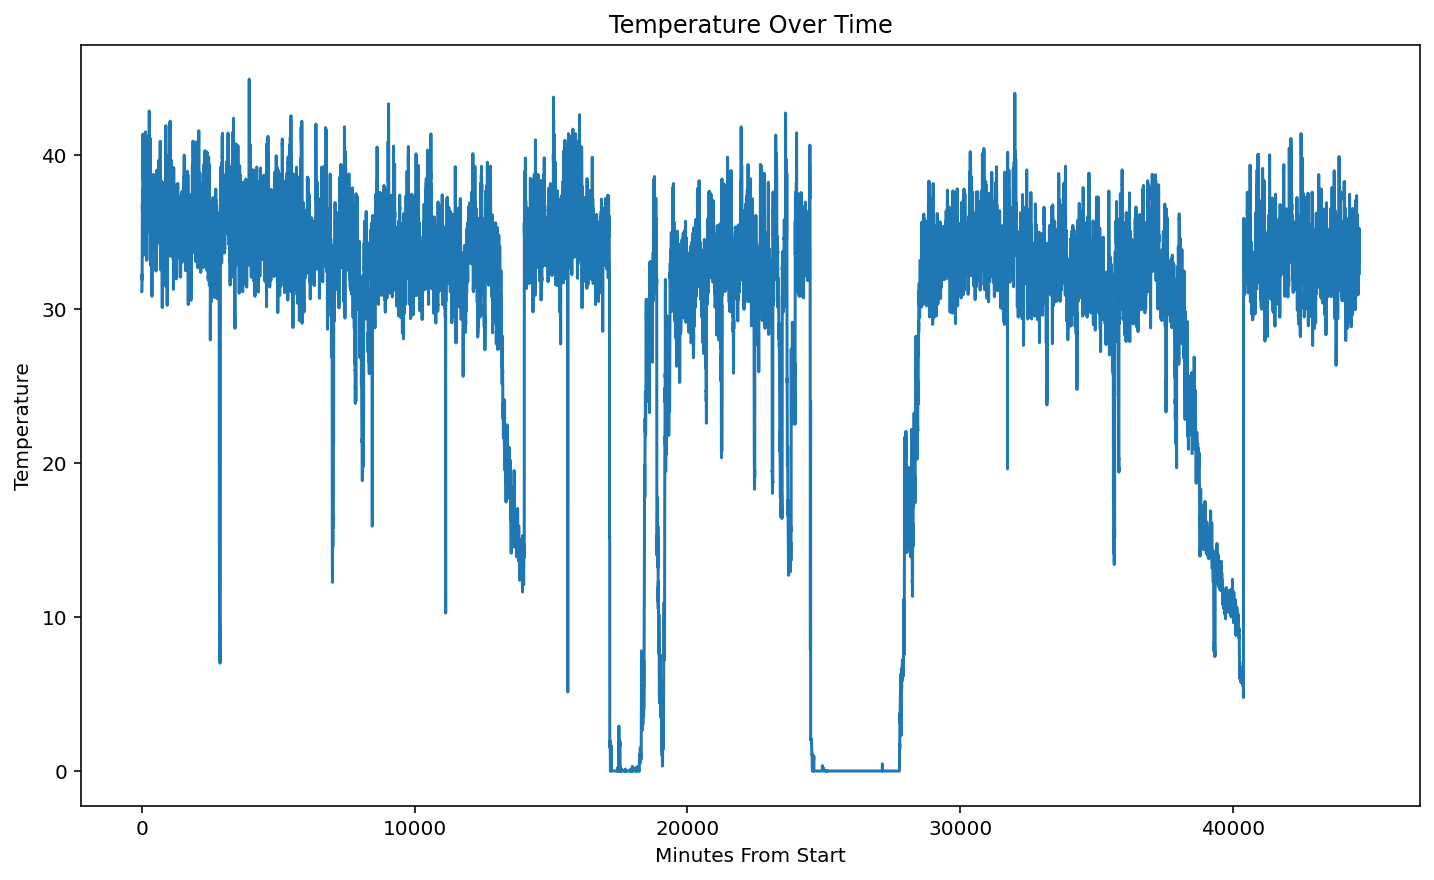

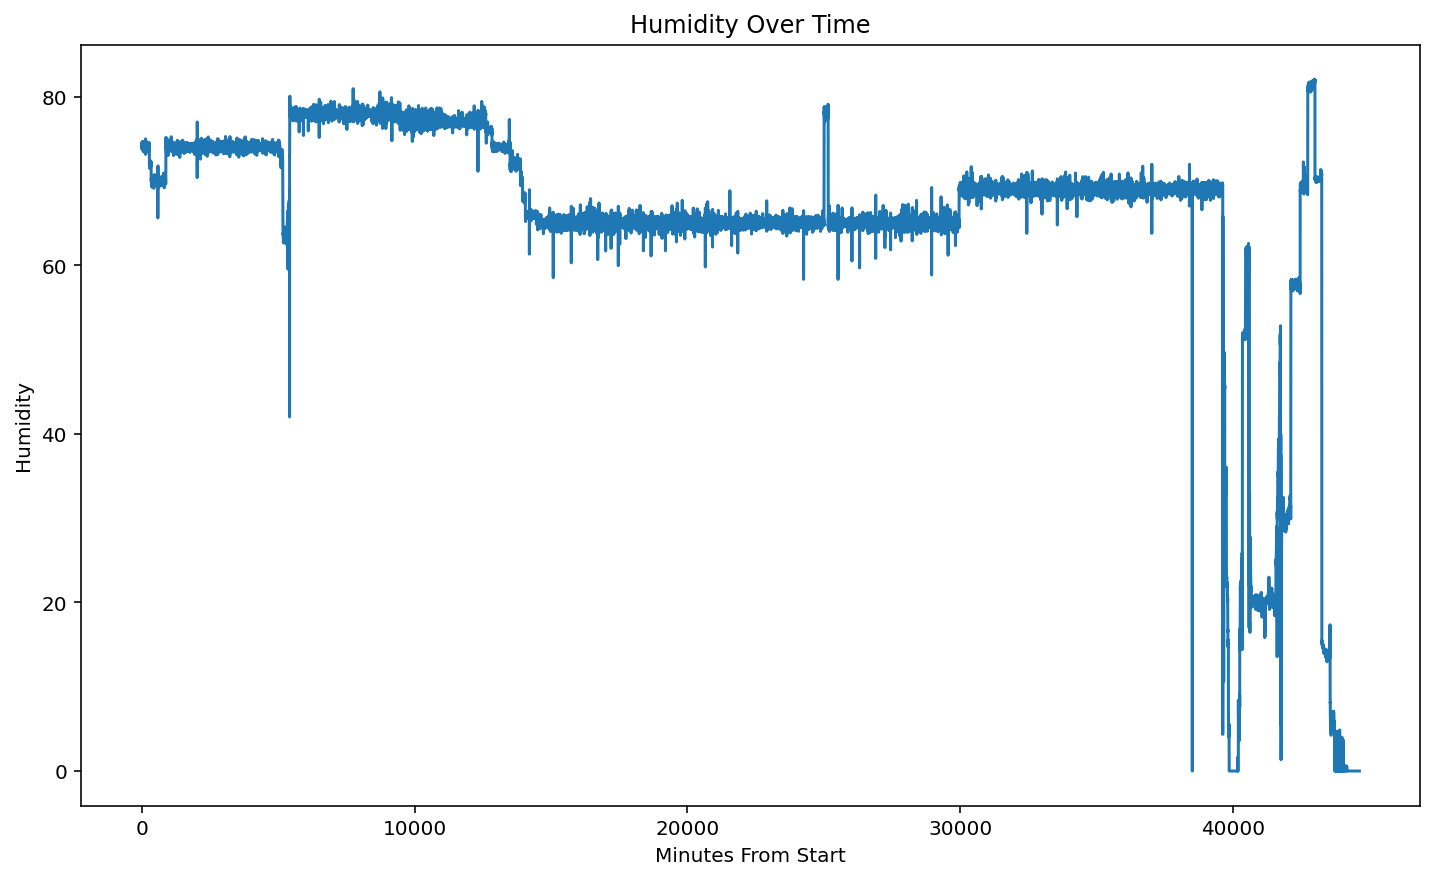

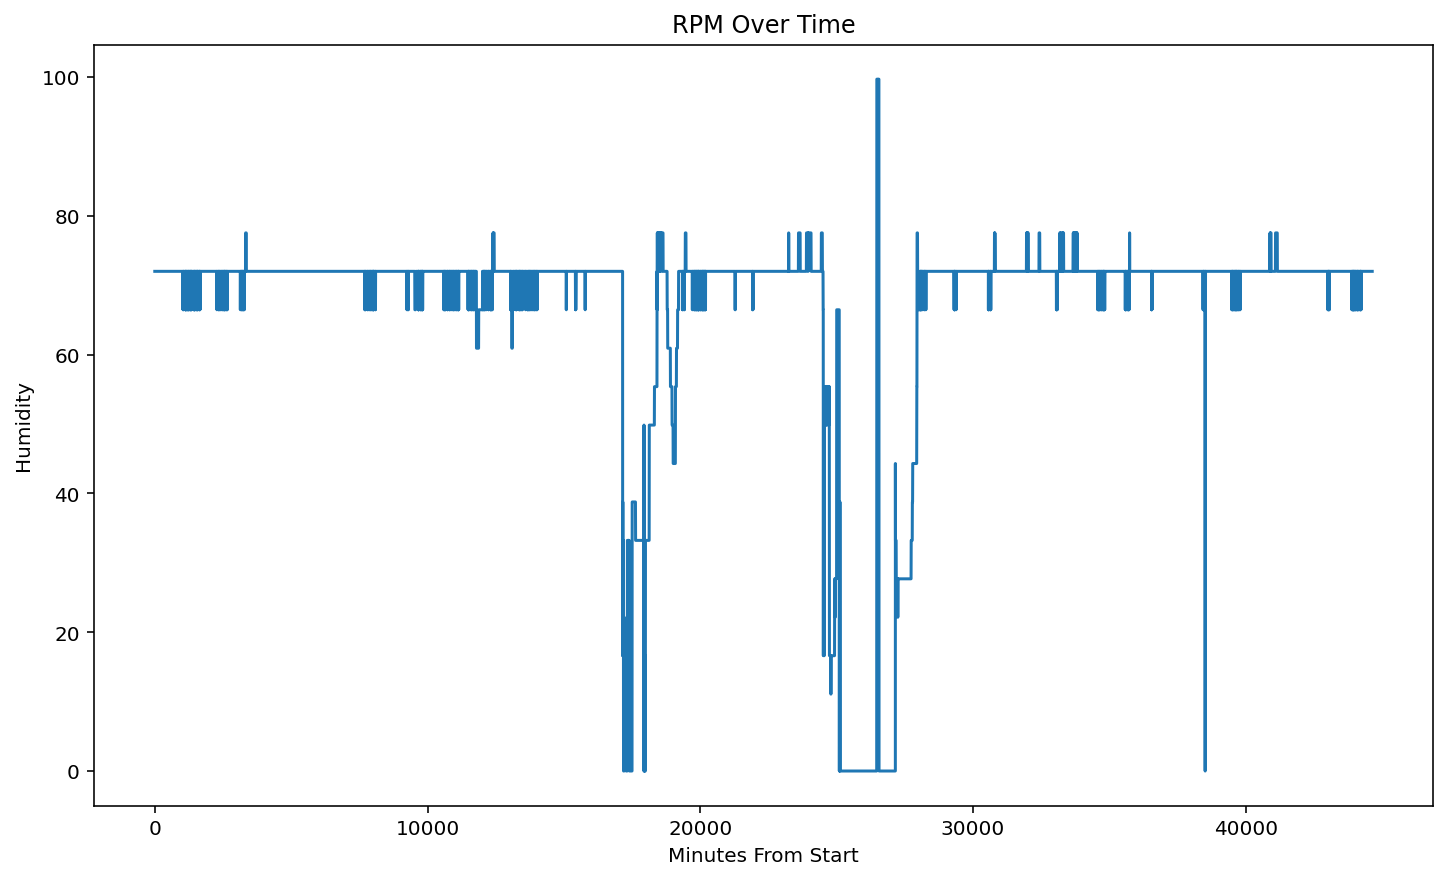

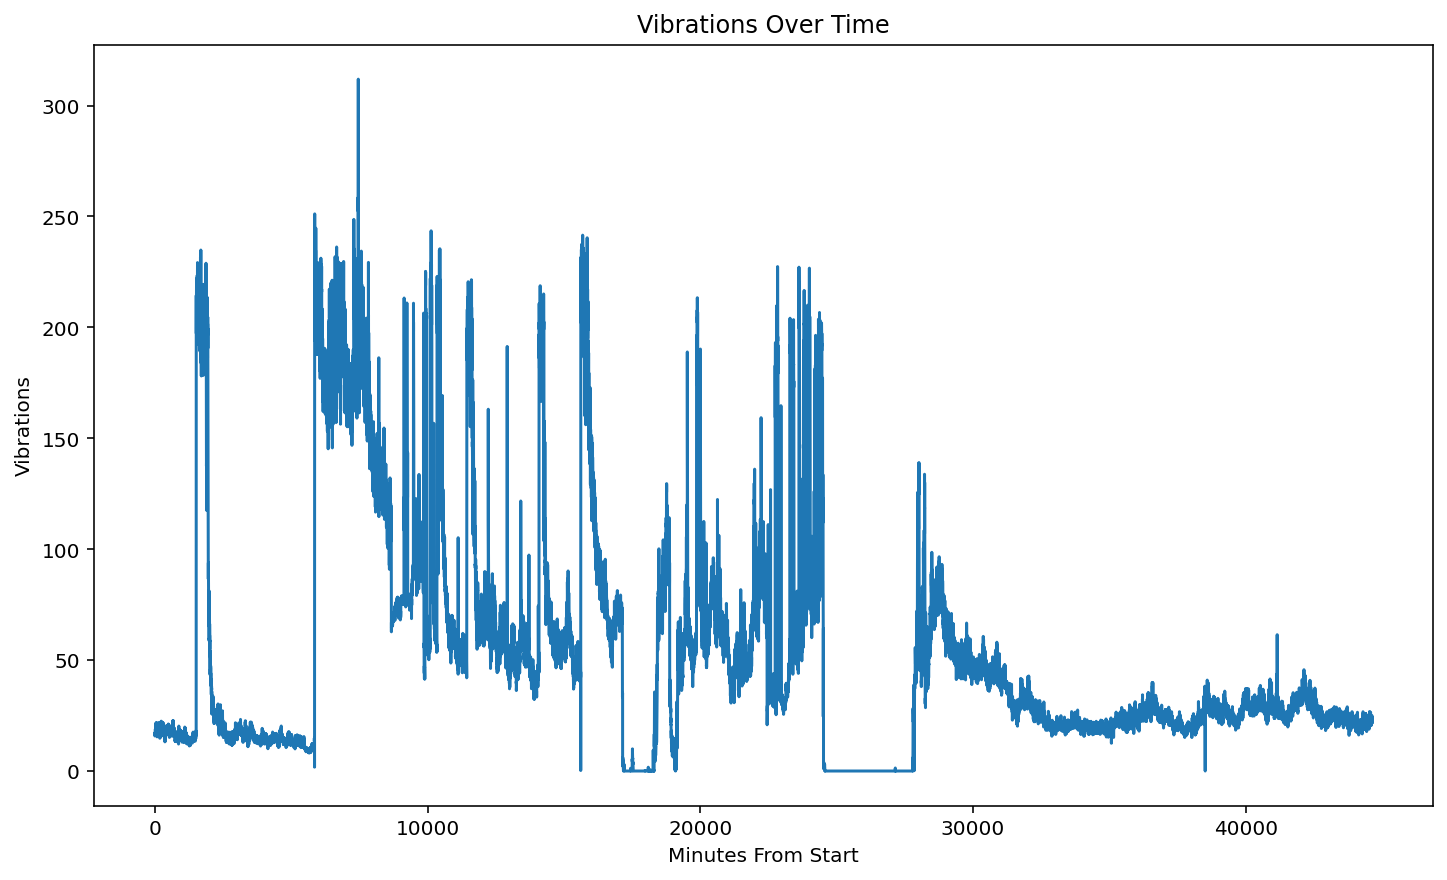

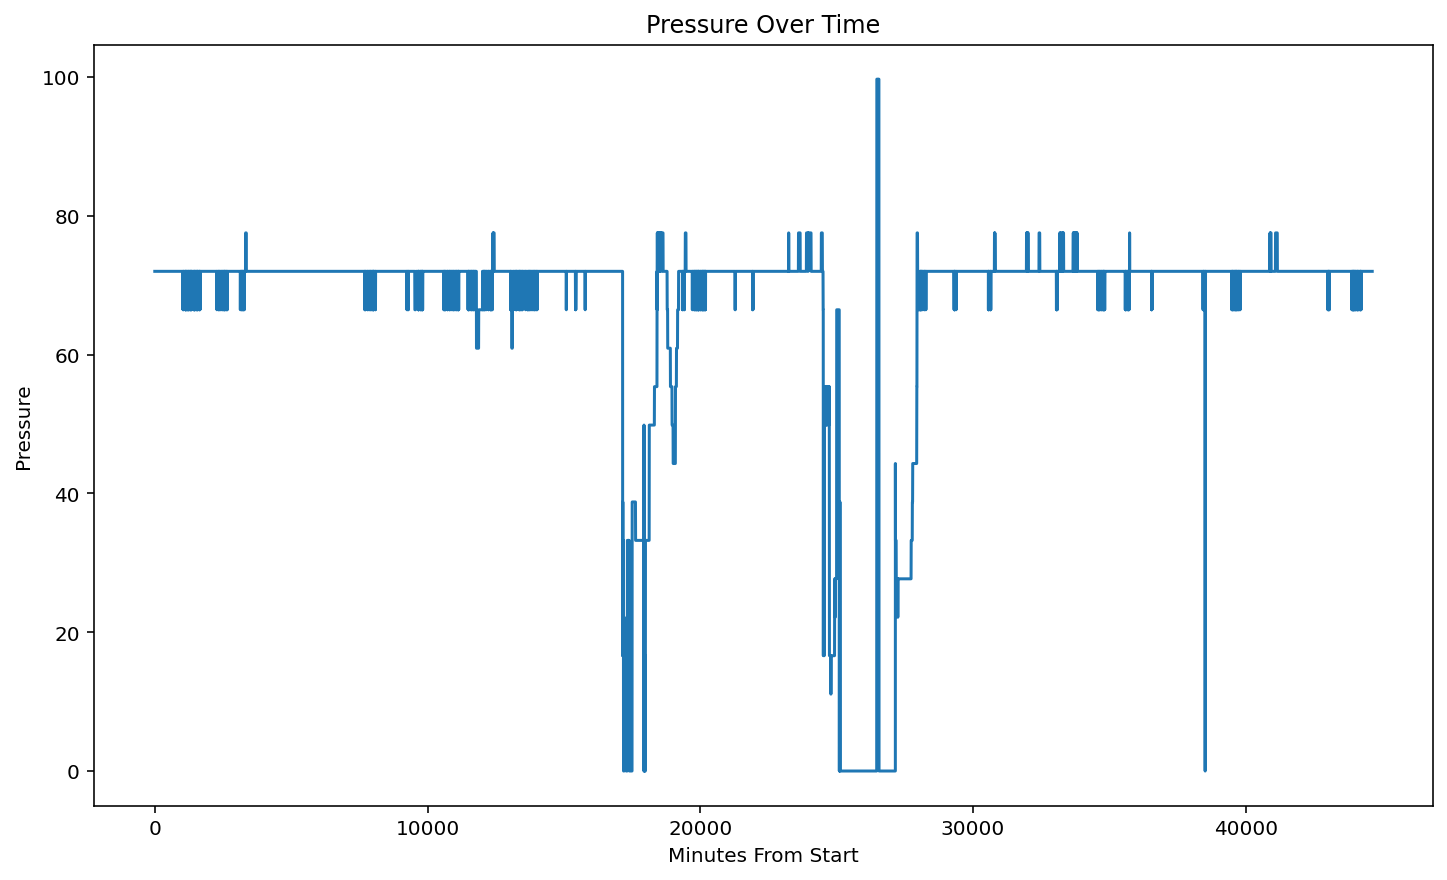

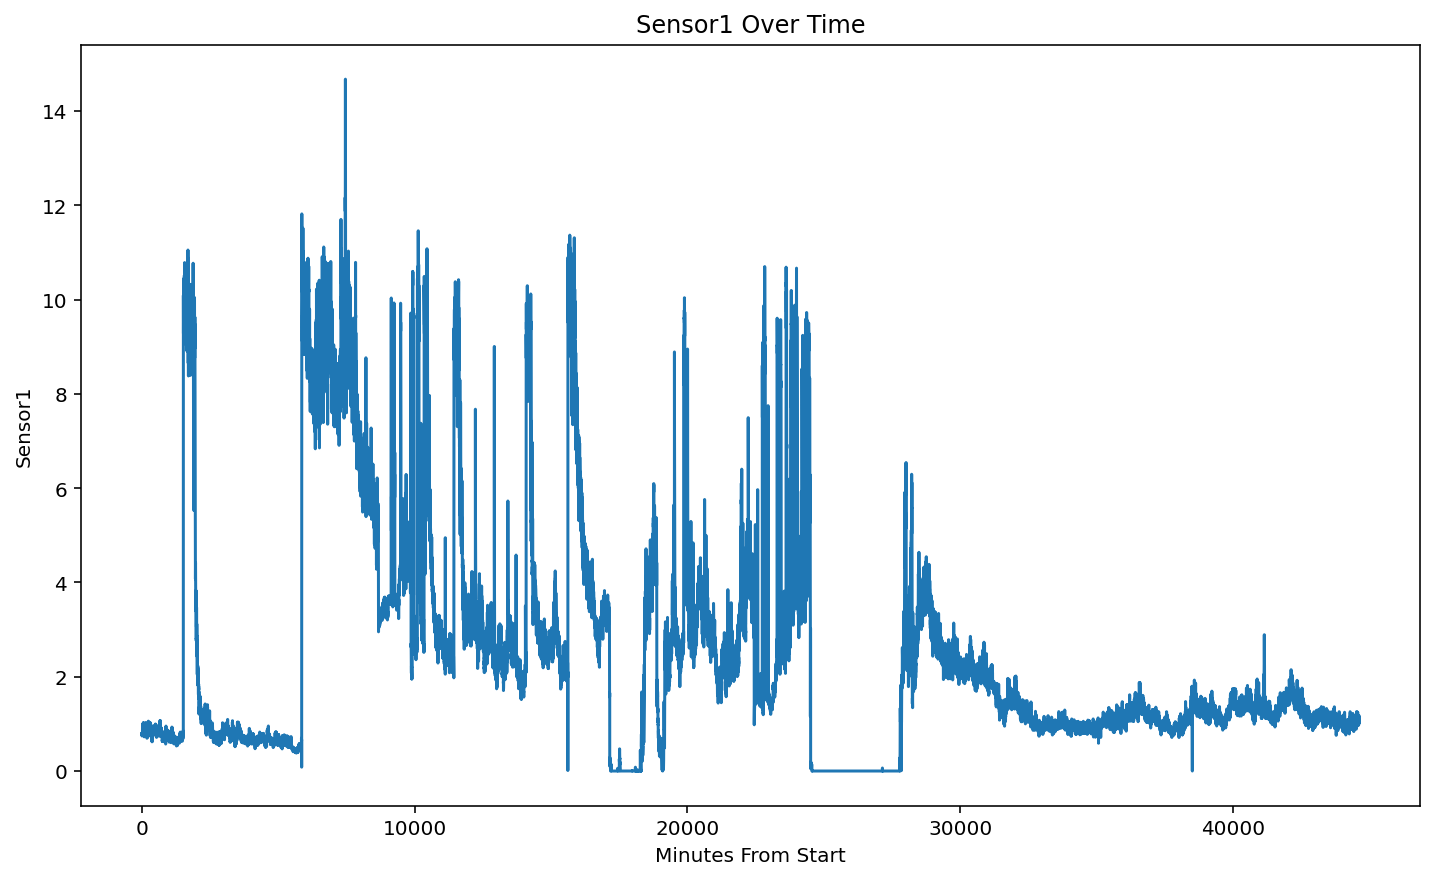

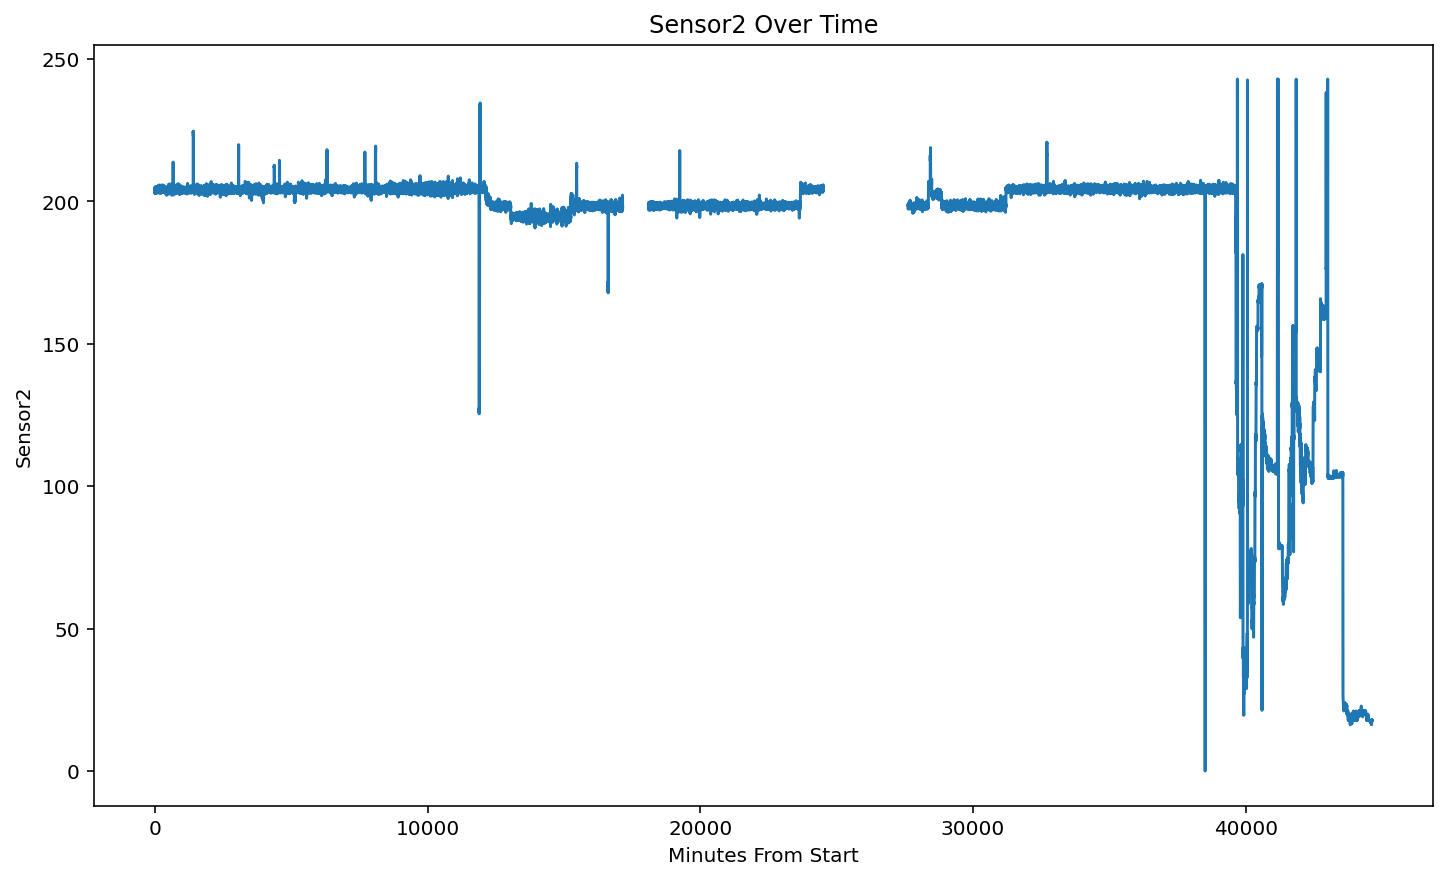

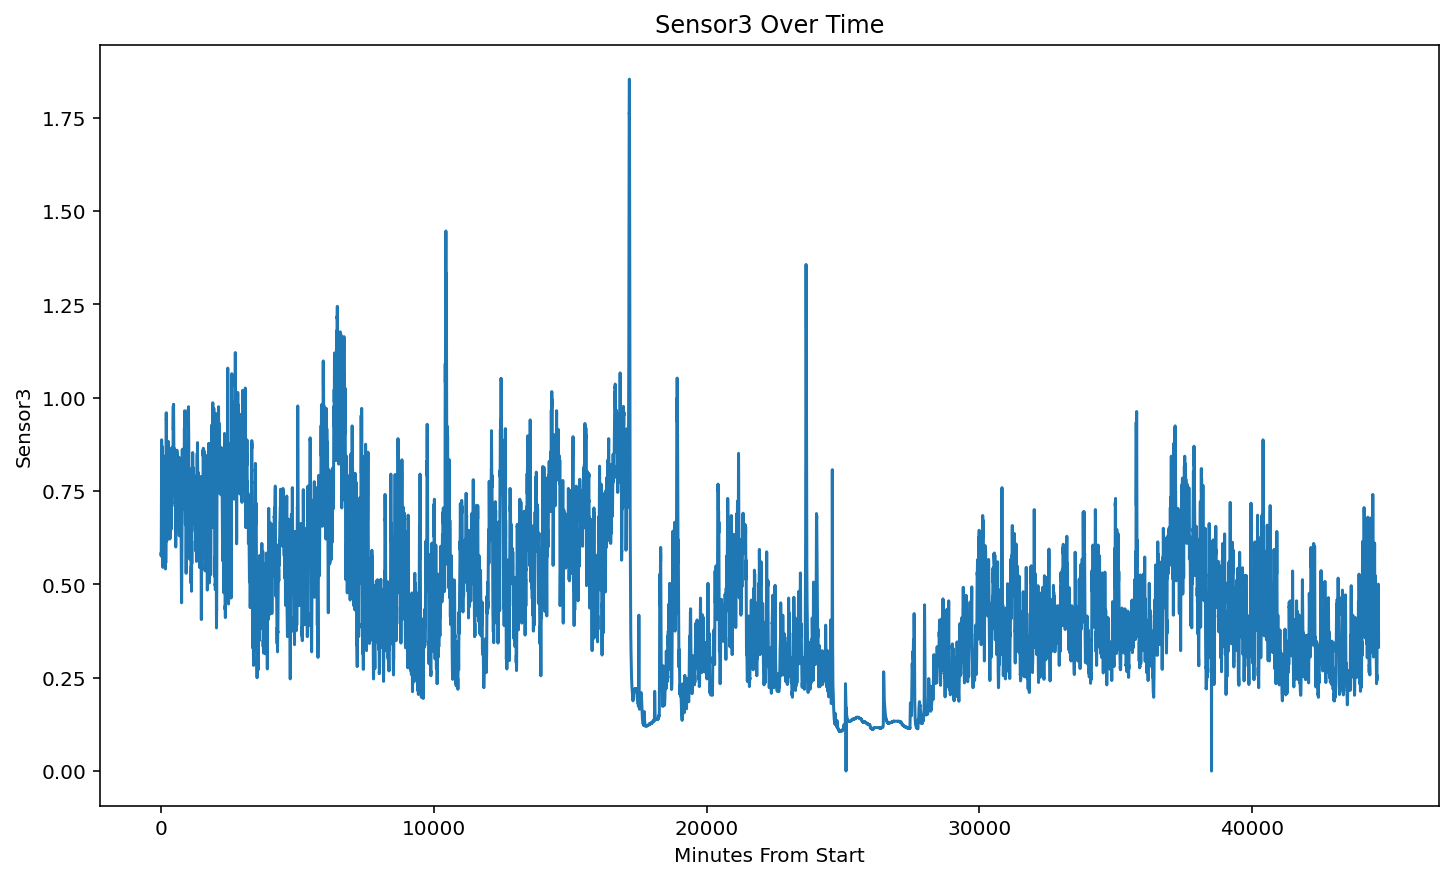

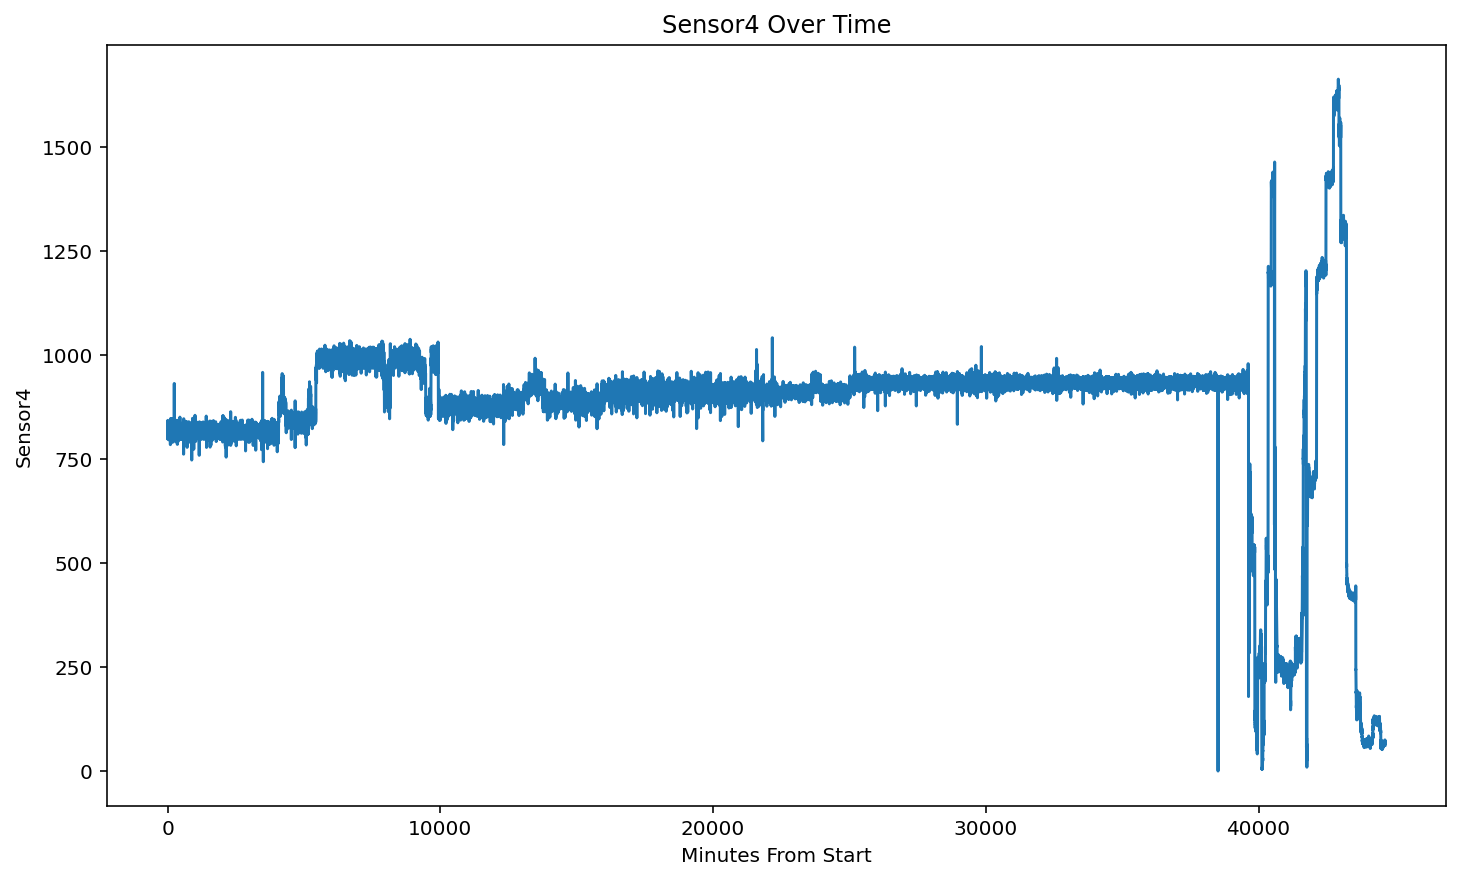

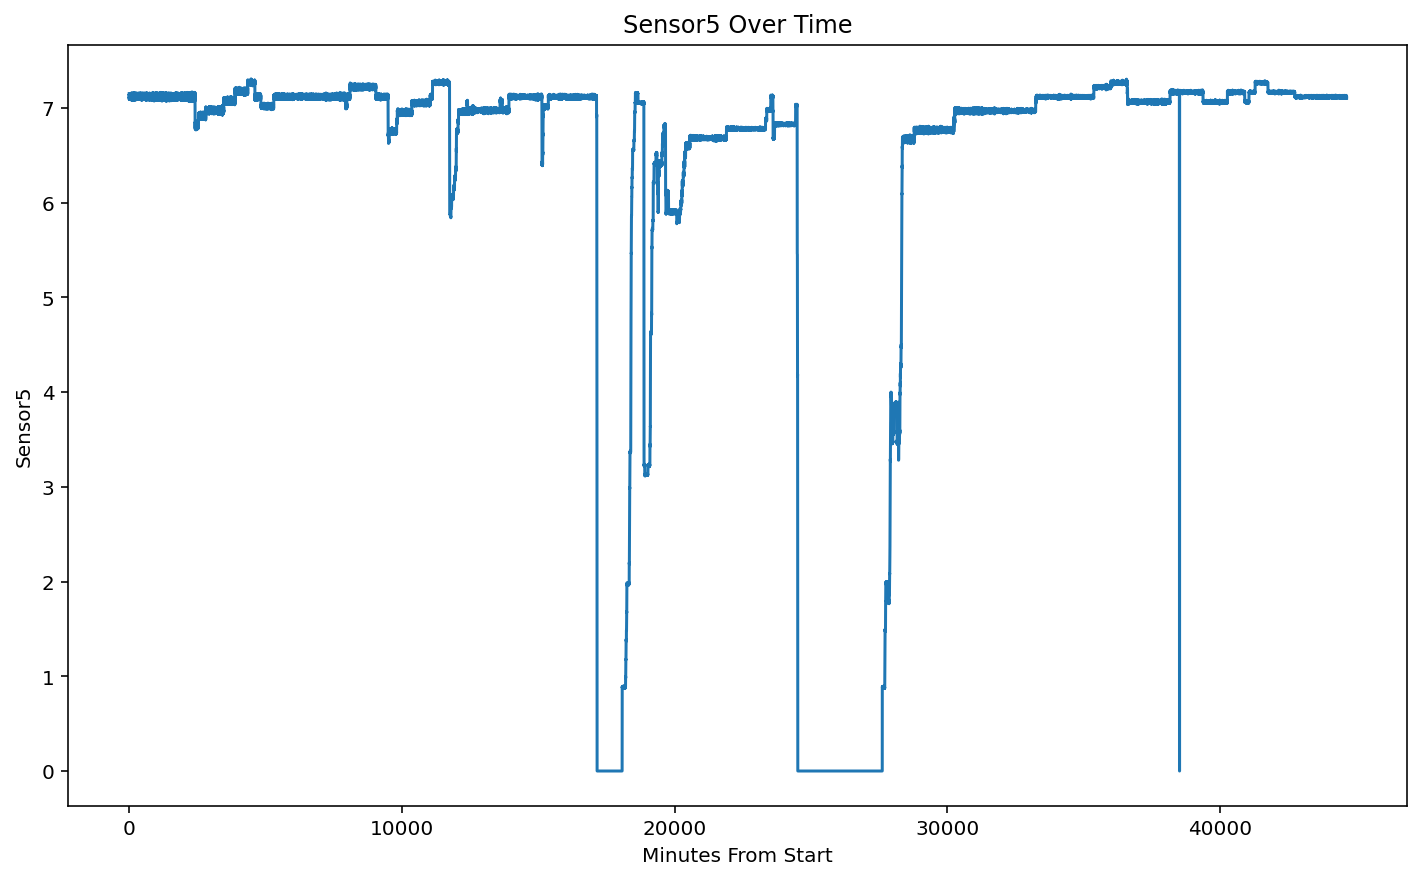

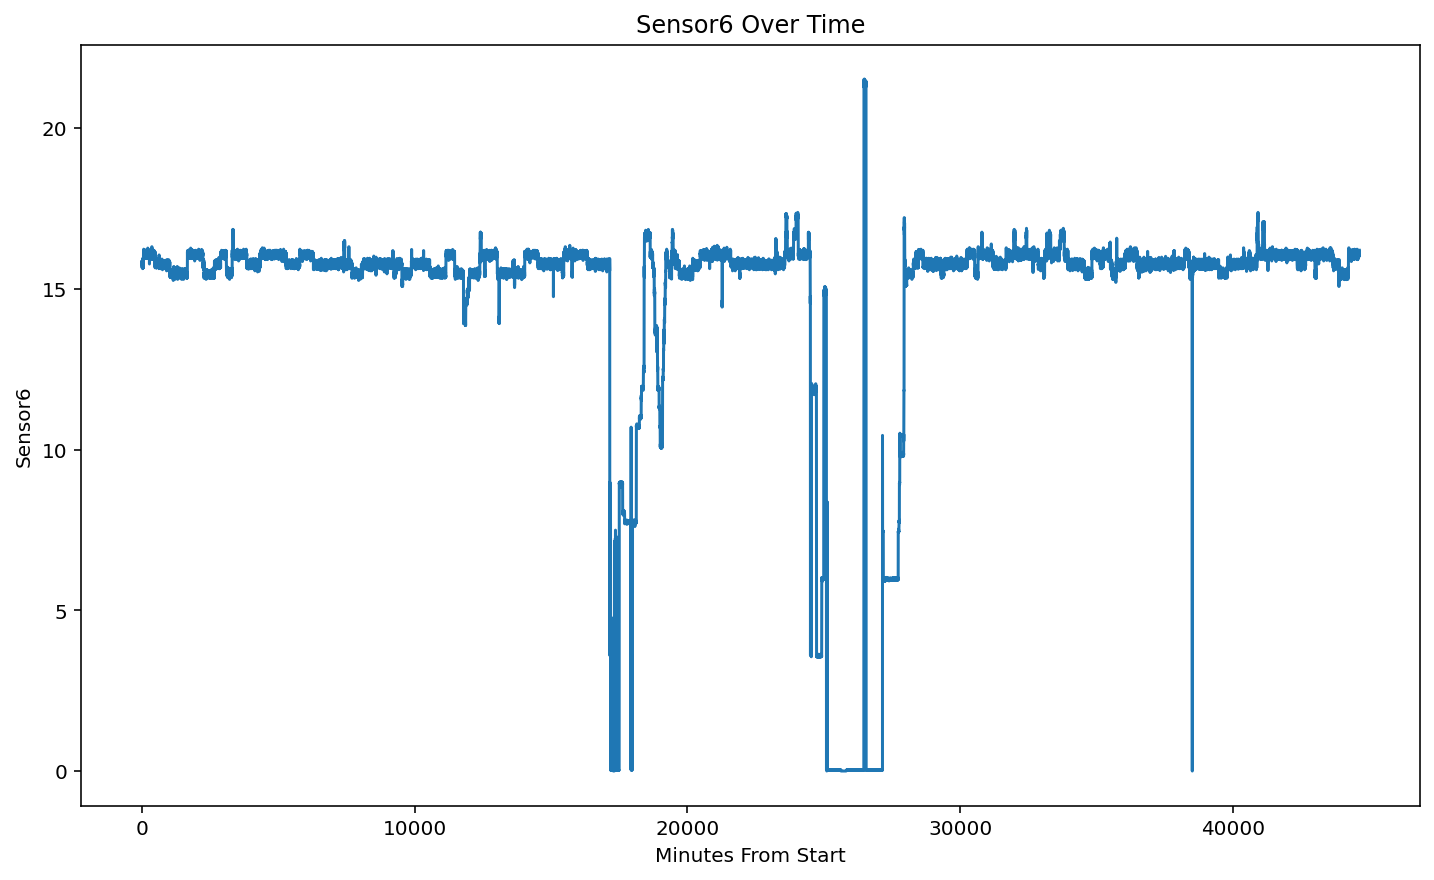

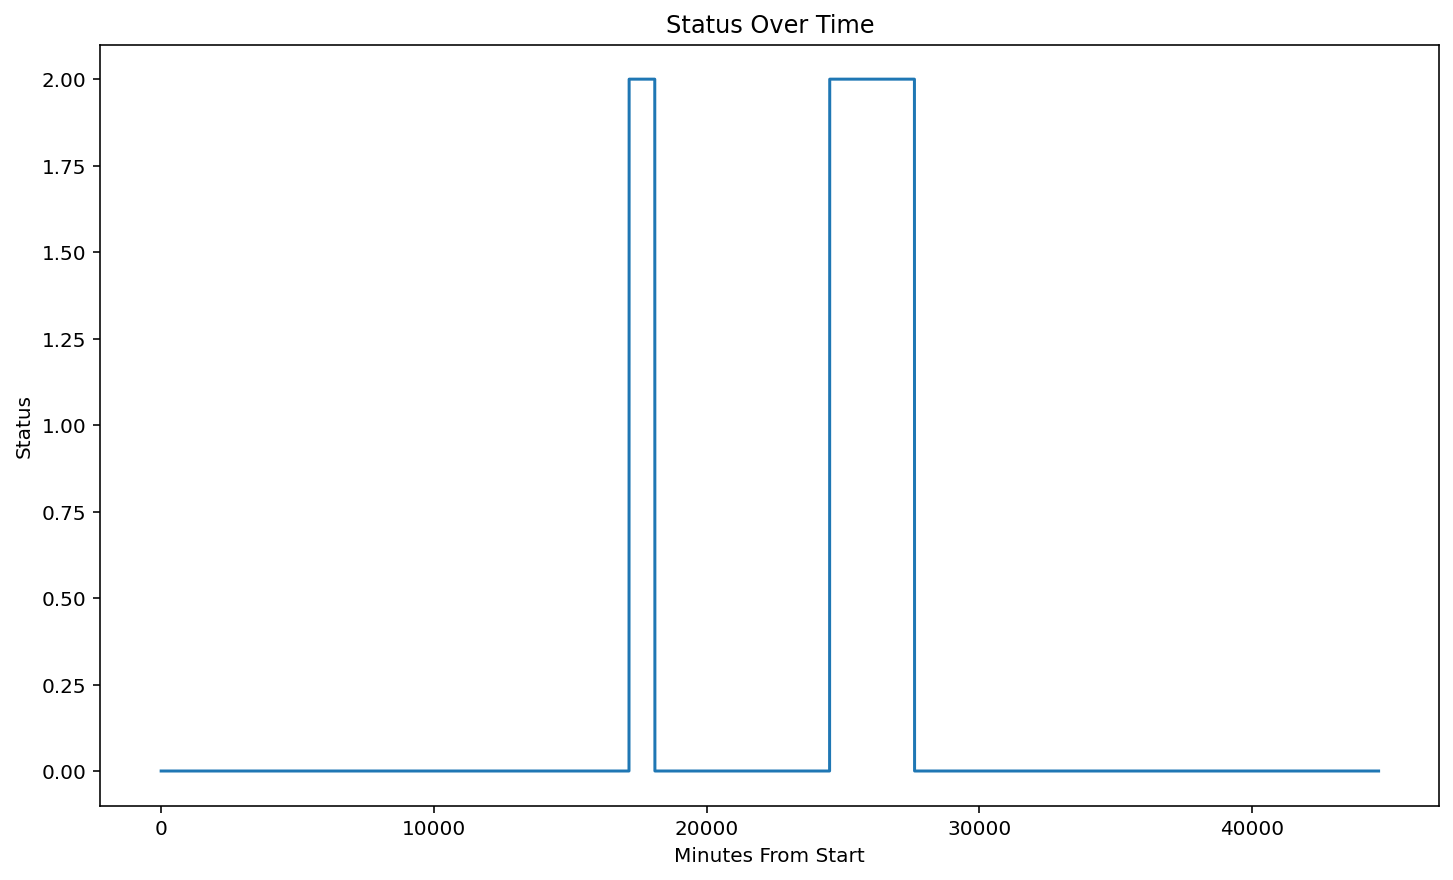

In [11]:
# Explore the relationships over time
import matplotlib.pyplot as plt

# Plot the Temperature  
plt.plot(initial_data["Temperature"])
plt.xlabel("Minutes From Start")
plt.ylabel("Temperature")
plt.title("Temperature Over Time")
plt.show()

# Plot the Humidity
plt.plot(initial_data["Humidity"])
plt.xlabel("Minutes From Start")
plt.ylabel("Humidity")
plt.title("Humidity Over Time")
plt.show()

# Plot the RPM
plt.plot(initial_data["RPM"])
plt.xlabel("Minutes From Start")
plt.ylabel("Humidity")
plt.title("RPM Over Time")
plt.show()

# Plot the vibrations 
plt.plot(initial_data["Vibrations"])
plt.xlabel("Minutes From Start")
plt.ylabel("Vibrations")
plt.title("Vibrations Over Time")
plt.show()

# Plot the Pressure
plt.plot(initial_data["RPM"])
plt.xlabel("Minutes From Start")
plt.ylabel("Pressure")
plt.title("Pressure Over Time")
plt.show()

# Plot the Sensor1
plt.plot(initial_data["Sensor1"])
plt.xlabel("Minutes From Start")
plt.ylabel("Sensor1")
plt.title("Sensor1 Over Time")
plt.show()

# Plot the Sensor2
plt.plot(initial_data["Sensor2"])
plt.xlabel("Minutes From Start")
plt.ylabel("Sensor2")
plt.title("Sensor2 Over Time")
plt.show()

# Plot the Sensor3
plt.plot(initial_data["Sensor3"])
plt.xlabel("Minutes From Start")
plt.ylabel("Sensor3")
plt.title("Sensor3 Over Time")
plt.show()

# Plot the Sensor4
plt.plot(initial_data["Sensor4"])
plt.xlabel("Minutes From Start")
plt.ylabel("Sensor4")
plt.title("Sensor4 Over Time")
plt.show()

# Plot the Sensor5
plt.plot(initial_data["Sensor5"])
plt.xlabel("Minutes From Start")
plt.ylabel("Sensor5")
plt.title("Sensor5 Over Time")
plt.show()

# Plot the Sensor6
plt.plot(initial_data["Sensor6"])
plt.xlabel("Minutes From Start")
plt.ylabel("Sensor6")
plt.title("Sensor6 Over Time")
plt.show()

# Plot the Status
plt.plot(initial_data["Status"])
plt.xlabel("Minutes From Start")
plt.ylabel("Status")
plt.title("Status Over Time")
plt.show()

In [12]:
# Here, we do some preprocessing with the data. We add in a lag of 60, and impute any missing values with 0. This is because we have missing data from some sensors when we go offline. 


def prepare_dataframe_for_lstm(df, n_steps):
    
    df_temp = df
    
    df_temp.set_index('Time', inplace=True)

    for i in range(1, n_steps+1):
        df_temp[f'Status(t-{i})'] = df_temp['Status'].shift(i)
    
    df_temp.fillna(0, inplace=True)

    return df_temp

lookback = 60 # The lookback defines how many minutes in the past we want to consider.

inital_data_result = prepare_dataframe_for_lstm(initial_data, lookback)
print(inital_data_result.shape)


(44640, 72)


In [13]:
keys = inital_data_result.keys()
keys = keys.drop("Status")
keys

Index(['Temperature', 'Humidity', 'RPM', 'Vibrations', 'Pressure', 'Sensor1',
       'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6', 'Status(t-1)',
       'Status(t-2)', 'Status(t-3)', 'Status(t-4)', 'Status(t-5)',
       'Status(t-6)', 'Status(t-7)', 'Status(t-8)', 'Status(t-9)',
       'Status(t-10)', 'Status(t-11)', 'Status(t-12)', 'Status(t-13)',
       'Status(t-14)', 'Status(t-15)', 'Status(t-16)', 'Status(t-17)',
       'Status(t-18)', 'Status(t-19)', 'Status(t-20)', 'Status(t-21)',
       'Status(t-22)', 'Status(t-23)', 'Status(t-24)', 'Status(t-25)',
       'Status(t-26)', 'Status(t-27)', 'Status(t-28)', 'Status(t-29)',
       'Status(t-30)', 'Status(t-31)', 'Status(t-32)', 'Status(t-33)',
       'Status(t-34)', 'Status(t-35)', 'Status(t-36)', 'Status(t-37)',
       'Status(t-38)', 'Status(t-39)', 'Status(t-40)', 'Status(t-41)',
       'Status(t-42)', 'Status(t-43)', 'Status(t-44)', 'Status(t-45)',
       'Status(t-46)', 'Status(t-47)', 'Status(t-48)', 'Status(t-49)',
 

In [14]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as deepcopy

In [16]:
# Here, we get our mins and maxes for the model that we use to scale it. 

shifted_df_as_np = inital_data_result.to_numpy()
max = shifted_df_as_np.max()
min = shifted_df_as_np.min()

print(shifted_df_as_np)

# We scale the model, and normalize each variable to mitigate the impact of different values
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# Get our testing and training data. We isolate just our status as the y values, and all the other variables as our x values
X = np.concatenate((shifted_df_as_np[:, :11], shifted_df_as_np[:, 12:]), axis = 1)
#X = deepcopy(np.flip(X, axis=1))
y = shifted_df_as_np[:, 11]

# We calculate our split index here. We need to use a value of 0.5 for our split index because there are only 2 places where the elevator goes offline; we need ot have the first place in the training data, and the second to be in the testing data
split_index = int(len(X) * 0.50)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

[[31.11716 74.1715  72.      ...  0.       0.       0.     ]
 [31.11716 74.1715  72.      ...  0.       0.       0.     ]
 [32.08894 74.0803  72.      ...  0.       0.       0.     ]
 ...
 [32.88938  0.      72.      ...  0.       0.       0.     ]
 [33.11005  0.      72.      ...  0.       0.       0.     ]
 [33.67804  0.      72.      ...  0.       0.       0.     ]]


((22320, 71), (22320, 71), (22320,), (22320,))

In [17]:
# Here, we reshape our values into tensors to prepare it for training. 
lb = 71
X_train = X_train.reshape((-1, lb, 1))
X_test = X_test.reshape((-1, lb, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([22320, 71, 1]),
 torch.Size([22320, 71, 1]),
 torch.Size([22320, 1]),
 torch.Size([22320, 1]))

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build the LSTM model
model = Sequential()
# First LSTM layer with tanh activation
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))  # Dropout layer for regularization
# Second LSTM layer with tanh activation
model.add(LSTM(100, activation='tanh', return_sequences=False))#, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 71, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


   1/1395 ━━━━━━━━━━━━━━━━━━━━ 55:54 2s/step - accuracy: 0.0000e+00 - loss: 1.4130

   2/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 106ms/step - accuracy: 0.0000e+00 - loss: 1.2855

   3/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 112ms/step - accuracy: 0.0000e+00 - loss: 1.1741

   4/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 103ms/step - accuracy: 0.0000e+00 - loss: 1.0757

   5/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 100ms/step - accuracy: 0.0000e+00 - loss: 0.9883

   6/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 99ms/step - accuracy: 0.0017 - loss: 0.9131     

   7/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 100ms/step - accuracy: 0.0028 - loss: 0.8514

   8/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 99ms/step - accuracy: 0.0044 - loss: 0.7997 

   9/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 101ms/step - accuracy: 0.0054 - loss: 0.7550

  10/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 100ms/step - accuracy: 0.0074 - loss: 0.7154

  11/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 100ms/step - accuracy: 0.0093 - loss: 0.6822

  12/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 101ms/step - accuracy: 0.0111 - loss: 0.6522

  13/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 100ms/step - accuracy: 0.0129 - loss: 0.6251

  14/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 99ms/step - accuracy: 0.0148 - loss: 0.6006 

  15/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 99ms/step - accuracy: 0.0166 - loss: 0.5791

  16/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 96ms/step - accuracy: 0.0180 - loss: 0.5595

  17/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 99ms/step - accuracy: 0.0191 - loss: 0.5415

  18/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 98ms/step - accuracy: 0.0202 - loss: 0.5254

  19/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 96ms/step - accuracy: 0.0210 - loss: 0.5104

  20/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 96ms/step - accuracy: 0.0217 - loss: 0.4963

  21/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 96ms/step - accuracy: 0.0223 - loss: 0.4831

  22/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 97ms/step - accuracy: 0.0230 - loss: 0.4706

  23/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 97ms/step - accuracy: 0.0237 - loss: 0.4589

  24/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 97ms/step - accuracy: 0.0243 - loss: 0.4477

  25/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 97ms/step - accuracy: 0.0249 - loss: 0.4372

  26/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 97ms/step - accuracy: 0.0255 - loss: 0.4272

  27/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 98ms/step - accuracy: 0.0261 - loss: 0.4177

  28/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 97ms/step - accuracy: 0.0266 - loss: 0.4087

  29/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 98ms/step - accuracy: 0.0271 - loss: 0.4002

  30/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 97ms/step - accuracy: 0.0277 - loss: 0.3920

  31/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 97ms/step - accuracy: 0.0282 - loss: 0.3842

  32/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 97ms/step - accuracy: 0.0286 - loss: 0.3768

  33/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 98ms/step - accuracy: 0.0291 - loss: 0.3697

  34/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 98ms/step - accuracy: 0.0295 - loss: 0.3628

  35/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 98ms/step - accuracy: 0.0299 - loss: 0.3563

  36/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 100ms/step - accuracy: 0.0302 - loss: 0.3500

  37/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 98ms/step - accuracy: 0.0306 - loss: 0.3439 

  38/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 98ms/step - accuracy: 0.0308 - loss: 0.3381

  39/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 99ms/step - accuracy: 0.0311 - loss: 0.3327

  40/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 99ms/step - accuracy: 0.0313 - loss: 0.3275

  41/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 99ms/step - accuracy: 0.0315 - loss: 0.3224

  42/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 98ms/step - accuracy: 0.0317 - loss: 0.3175

  43/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 98ms/step - accuracy: 0.0318 - loss: 0.3128

  44/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 98ms/step - accuracy: 0.0319 - loss: 0.3083

  45/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 98ms/step - accuracy: 0.0321 - loss: 0.3039

  46/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 98ms/step - accuracy: 0.0322 - loss: 0.2996

  47/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 98ms/step - accuracy: 0.0322 - loss: 0.2955

  48/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 98ms/step - accuracy: 0.0324 - loss: 0.2915

  49/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 100ms/step - accuracy: 0.0325 - loss: 0.2876

  50/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 100ms/step - accuracy: 0.0326 - loss: 0.2838

  51/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 100ms/step - accuracy: 0.0327 - loss: 0.2801

  52/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 102ms/step - accuracy: 0.0328 - loss: 0.2766

  54/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 100ms/step - accuracy: 0.0330 - loss: 0.2698

  55/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 102ms/step - accuracy: 0.0331 - loss: 0.2665

  56/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 104ms/step - accuracy: 0.0332 - loss: 0.2633

  57/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 104ms/step - accuracy: 0.0333 - loss: 0.2602

  58/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 104ms/step - accuracy: 0.0333 - loss: 0.2572

  59/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 104ms/step - accuracy: 0.0334 - loss: 0.2543

  60/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 104ms/step - accuracy: 0.0335 - loss: 0.2514

  61/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 105ms/step - accuracy: 0.0336 - loss: 0.2486

  62/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 105ms/step - accuracy: 0.0337 - loss: 0.2459

  63/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 106ms/step - accuracy: 0.0338 - loss: 0.2433

  64/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 106ms/step - accuracy: 0.0338 - loss: 0.2407

  65/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 106ms/step - accuracy: 0.0339 - loss: 0.2382

  66/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 106ms/step - accuracy: 0.0339 - loss: 0.2357

  67/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 106ms/step - accuracy: 0.0340 - loss: 0.2333

  68/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 105ms/step - accuracy: 0.0341 - loss: 0.2309

  69/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 105ms/step - accuracy: 0.0341 - loss: 0.2286

  70/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 106ms/step - accuracy: 0.0342 - loss: 0.2264

  71/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 106ms/step - accuracy: 0.0342 - loss: 0.2242

  72/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 106ms/step - accuracy: 0.0343 - loss: 0.2220

  73/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 106ms/step - accuracy: 0.0343 - loss: 0.2199

  74/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 106ms/step - accuracy: 0.0344 - loss: 0.2179

  75/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 106ms/step - accuracy: 0.0345 - loss: 0.2159

  76/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 105ms/step - accuracy: 0.0345 - loss: 0.2140

  77/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 105ms/step - accuracy: 0.0346 - loss: 0.2121

  78/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 105ms/step - accuracy: 0.0347 - loss: 0.2102

  79/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 105ms/step - accuracy: 0.0347 - loss: 0.2084

  80/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 105ms/step - accuracy: 0.0348 - loss: 0.2066

  81/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 105ms/step - accuracy: 0.0348 - loss: 0.2049

  82/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 105ms/step - accuracy: 0.0349 - loss: 0.2032

  83/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 105ms/step - accuracy: 0.0349 - loss: 0.2016

  84/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 105ms/step - accuracy: 0.0350 - loss: 0.1999

  85/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 105ms/step - accuracy: 0.0350 - loss: 0.1984

  86/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 105ms/step - accuracy: 0.0351 - loss: 0.1968

  87/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 106ms/step - accuracy: 0.0351 - loss: 0.1953

  88/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 106ms/step - accuracy: 0.0352 - loss: 0.1938

  89/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 106ms/step - accuracy: 0.0352 - loss: 0.1923

  90/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0352 - loss: 0.1909

  91/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0353 - loss: 0.1895

  92/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0353 - loss: 0.1881

  93/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0353 - loss: 0.1867

  94/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0354 - loss: 0.1853

  95/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0354 - loss: 0.1840

  96/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0354 - loss: 0.1827

  97/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 105ms/step - accuracy: 0.0355 - loss: 0.1814

  98/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0355 - loss: 0.1801

  99/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0355 - loss: 0.1789

 100/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0356 - loss: 0.1777

 101/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 106ms/step - accuracy: 0.0356 - loss: 0.1765

 102/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 106ms/step - accuracy: 0.0356 - loss: 0.1753

 103/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 106ms/step - accuracy: 0.0356 - loss: 0.1742

 104/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 106ms/step - accuracy: 0.0356 - loss: 0.1731

 105/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 106ms/step - accuracy: 0.0356 - loss: 0.1719

 106/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 106ms/step - accuracy: 0.0356 - loss: 0.1708

 107/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 106ms/step - accuracy: 0.0356 - loss: 0.1697

 108/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 106ms/step - accuracy: 0.0356 - loss: 0.1687

 109/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 106ms/step - accuracy: 0.0357 - loss: 0.1676

 110/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 106ms/step - accuracy: 0.0357 - loss: 0.1666

 111/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 106ms/step - accuracy: 0.0357 - loss: 0.1656

 112/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 106ms/step - accuracy: 0.0357 - loss: 0.1646

 113/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 106ms/step - accuracy: 0.0357 - loss: 0.1636

 114/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 106ms/step - accuracy: 0.0357 - loss: 0.1626

 115/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 106ms/step - accuracy: 0.0357 - loss: 0.1616

 116/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 105ms/step - accuracy: 0.0358 - loss: 0.1607

 117/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 105ms/step - accuracy: 0.0358 - loss: 0.1598

 118/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 105ms/step - accuracy: 0.0358 - loss: 0.1589

 119/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 105ms/step - accuracy: 0.0358 - loss: 0.1580

 120/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 105ms/step - accuracy: 0.0359 - loss: 0.1571

 121/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 105ms/step - accuracy: 0.0359 - loss: 0.1562

 122/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0359 - loss: 0.1553

 123/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0360 - loss: 0.1545

 124/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0360 - loss: 0.1537

 125/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0360 - loss: 0.1528

 126/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0360 - loss: 0.1520

 127/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0361 - loss: 0.1512

 128/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0361 - loss: 0.1505

 129/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0361 - loss: 0.1497

 130/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0361 - loss: 0.1489

 131/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0362 - loss: 0.1482

 132/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - accuracy: 0.0362 - loss: 0.1475

 133/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 106ms/step - accuracy: 0.0362 - loss: 0.1467

 134/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0362 - loss: 0.1460

 135/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0362 - loss: 0.1453

 136/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0363 - loss: 0.1446

 137/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0363 - loss: 0.1439

 138/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0363 - loss: 0.1432

 139/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0363 - loss: 0.1426

 140/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0364 - loss: 0.1419

 141/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0364 - loss: 0.1412

 142/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0364 - loss: 0.1406

 143/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - accuracy: 0.0364 - loss: 0.1399

 144/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - accuracy: 0.0364 - loss: 0.1393

 145/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - accuracy: 0.0364 - loss: 0.1387

 146/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - accuracy: 0.0364 - loss: 0.1380

 147/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - accuracy: 0.0364 - loss: 0.1374

 148/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - accuracy: 0.0364 - loss: 0.1368

 149/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - accuracy: 0.0364 - loss: 0.1362

 150/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - accuracy: 0.0365 - loss: 0.1356

 151/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - accuracy: 0.0365 - loss: 0.1350

 152/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1344

 153/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1338

 154/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1333

 155/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1327

 156/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1321

 157/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1316

 158/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1310

 159/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1304

 160/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1299

 161/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - accuracy: 0.0365 - loss: 0.1294

 162/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 106ms/step - accuracy: 0.0365 - loss: 0.1288

 163/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 106ms/step - accuracy: 0.0365 - loss: 0.1283

 164/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 106ms/step - accuracy: 0.0365 - loss: 0.1278

 165/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 106ms/step - accuracy: 0.0365 - loss: 0.1273

 166/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 106ms/step - accuracy: 0.0365 - loss: 0.1267

 167/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 106ms/step - accuracy: 0.0365 - loss: 0.1262

 168/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 106ms/step - accuracy: 0.0365 - loss: 0.1257

 169/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1252

 170/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1247

 171/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1242

 172/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1237

 173/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1233

 174/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1228

 175/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1223

 176/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1218

 177/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1214

 178/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1209

 179/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 106ms/step - accuracy: 0.0366 - loss: 0.1204

 180/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.0366 - loss: 0.1200

 181/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.0367 - loss: 0.1195

 182/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.0367 - loss: 0.1191

 183/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.0367 - loss: 0.1187

 184/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.0367 - loss: 0.1182

 185/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.0367 - loss: 0.1178

 186/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.0367 - loss: 0.1173

 187/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.0367 - loss: 0.1169

 188/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 106ms/step - accuracy: 0.0367 - loss: 0.1165

 189/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 107ms/step - accuracy: 0.0368 - loss: 0.1161

 190/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 107ms/step - accuracy: 0.0368 - loss: 0.1156

 191/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 107ms/step - accuracy: 0.0368 - loss: 0.1152

 192/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 107ms/step - accuracy: 0.0368 - loss: 0.1148

 193/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 107ms/step - accuracy: 0.0368 - loss: 0.1144

 194/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 107ms/step - accuracy: 0.0368 - loss: 0.1140

 195/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 107ms/step - accuracy: 0.0368 - loss: 0.1136

 196/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 107ms/step - accuracy: 0.0368 - loss: 0.1132

 197/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1128

 198/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1124

 199/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1120

 200/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1116

 201/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1113

 202/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1109

 203/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1105

 204/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1101

 205/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0369 - loss: 0.1097

 206/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 107ms/step - accuracy: 0.0369 - loss: 0.1094

 207/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 107ms/step - accuracy: 0.0369 - loss: 0.1090

 208/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 107ms/step - accuracy: 0.0370 - loss: 0.1087

 209/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 107ms/step - accuracy: 0.0370 - loss: 0.1083

 210/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 107ms/step - accuracy: 0.0370 - loss: 0.1079

 211/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 107ms/step - accuracy: 0.0370 - loss: 0.1076

 212/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 108ms/step - accuracy: 0.0370 - loss: 0.1072

 213/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 108ms/step - accuracy: 0.0370 - loss: 0.1069

 214/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 108ms/step - accuracy: 0.0370 - loss: 0.1065

 215/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 108ms/step - accuracy: 0.0370 - loss: 0.1062

 216/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 108ms/step - accuracy: 0.0370 - loss: 0.1059

 217/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 108ms/step - accuracy: 0.0370 - loss: 0.1055

 218/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0370 - loss: 0.1052

 219/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0370 - loss: 0.1048

 220/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0371 - loss: 0.1045

 221/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0371 - loss: 0.1042

 222/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0371 - loss: 0.1039

 223/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0371 - loss: 0.1035

 224/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0371 - loss: 0.1032

 225/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0371 - loss: 0.1029

 226/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0372 - loss: 0.1026

 227/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0372 - loss: 0.1023

 228/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0372 - loss: 0.1020

 229/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 108ms/step - accuracy: 0.0372 - loss: 0.1017

 230/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 108ms/step - accuracy: 0.0372 - loss: 0.1014

 231/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 108ms/step - accuracy: 0.0372 - loss: 0.1010

 232/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 108ms/step - accuracy: 0.0372 - loss: 0.1007

 233/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 108ms/step - accuracy: 0.0372 - loss: 0.1005

 234/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 108ms/step - accuracy: 0.0373 - loss: 0.1002

 235/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 108ms/step - accuracy: 0.0373 - loss: 0.0999

 236/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 108ms/step - accuracy: 0.0373 - loss: 0.0996

 237/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0373 - loss: 0.0993

 238/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0373 - loss: 0.0990

 239/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0373 - loss: 0.0987

 240/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0373 - loss: 0.0984

 241/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0373 - loss: 0.0982

 242/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0373 - loss: 0.0979

 243/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0374 - loss: 0.0976

 244/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0374 - loss: 0.0973

 245/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 108ms/step - accuracy: 0.0374 - loss: 0.0971

 246/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0374 - loss: 0.0968

 247/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0374 - loss: 0.0965

 248/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0374 - loss: 0.0963

 249/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0374 - loss: 0.0960

 250/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0374 - loss: 0.0957

 251/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0374 - loss: 0.0955

 252/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0374 - loss: 0.0952

 253/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0375 - loss: 0.0950

 254/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 108ms/step - accuracy: 0.0375 - loss: 0.0947

 255/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0944

 256/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0942

 257/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0939

 258/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0937

 259/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0934

 260/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0932

 261/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0929

 262/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0927

 263/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0375 - loss: 0.0925

 264/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0376 - loss: 0.0922

 265/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0376 - loss: 0.0920

 266/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0376 - loss: 0.0917

 267/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0376 - loss: 0.0915

 268/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 108ms/step - accuracy: 0.0376 - loss: 0.0913

 269/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 108ms/step - accuracy: 0.0376 - loss: 0.0910

 270/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 108ms/step - accuracy: 0.0376 - loss: 0.0908

 271/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 108ms/step - accuracy: 0.0376 - loss: 0.0906

 272/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 108ms/step - accuracy: 0.0376 - loss: 0.0903

 273/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 108ms/step - accuracy: 0.0376 - loss: 0.0901

 274/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 108ms/step - accuracy: 0.0376 - loss: 0.0899

 275/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 108ms/step - accuracy: 0.0376 - loss: 0.0897

 276/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0894

 277/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0892

 278/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0890

 279/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0888

 280/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0886

 281/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0883

 282/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0881

 283/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0879

 284/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.0377 - loss: 0.0877

 285/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - accuracy: 0.0377 - loss: 0.0875

 286/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - accuracy: 0.0377 - loss: 0.0873

 287/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - accuracy: 0.0377 - loss: 0.0871

 288/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - accuracy: 0.0378 - loss: 0.0869

 289/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - accuracy: 0.0378 - loss: 0.0867

 290/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - accuracy: 0.0378 - loss: 0.0865

 291/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - accuracy: 0.0378 - loss: 0.0863

 292/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - accuracy: 0.0378 - loss: 0.0861

 293/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0378 - loss: 0.0859

 294/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0378 - loss: 0.0857

 295/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0378 - loss: 0.0855

 296/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0378 - loss: 0.0853

 297/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0851

 298/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0849

 299/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0847

 300/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0845

 301/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0843

 302/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0841

 303/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0839

 304/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0838

 305/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - accuracy: 0.0379 - loss: 0.0836

 306/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0834

 307/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0832

 308/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0830

 309/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0829

 310/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0827

 311/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0825

 312/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0823

 313/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0822

 314/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - accuracy: 0.0380 - loss: 0.0820

 315/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - accuracy: 0.0380 - loss: 0.0818

 316/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - accuracy: 0.0381 - loss: 0.0816

 317/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - accuracy: 0.0381 - loss: 0.0815

 318/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - accuracy: 0.0381 - loss: 0.0813

 319/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - accuracy: 0.0381 - loss: 0.0811

 320/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - accuracy: 0.0381 - loss: 0.0810

 321/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - accuracy: 0.0381 - loss: 0.0808

 322/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - accuracy: 0.0381 - loss: 0.0807

 323/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0381 - loss: 0.0805

 324/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0381 - loss: 0.0803

 325/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0381 - loss: 0.0802

 326/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0382 - loss: 0.0800

 327/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0382 - loss: 0.0799

 328/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0382 - loss: 0.0797

 329/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0382 - loss: 0.0795

 330/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0382 - loss: 0.0794

 331/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0382 - loss: 0.0792

 332/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0382 - loss: 0.0791

 333/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0382 - loss: 0.0789

 334/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 108ms/step - accuracy: 0.0382 - loss: 0.0788

 335/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0382 - loss: 0.0786

 336/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0382 - loss: 0.0785

 337/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0383 - loss: 0.0783

 338/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0383 - loss: 0.0782

 339/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0383 - loss: 0.0780

 340/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0383 - loss: 0.0779

 341/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0383 - loss: 0.0777

 342/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 108ms/step - accuracy: 0.0383 - loss: 0.0776

 343/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0383 - loss: 0.0774

 344/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0383 - loss: 0.0773

 345/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0383 - loss: 0.0772

 346/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0383 - loss: 0.0770

 347/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0383 - loss: 0.0769

 348/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0383 - loss: 0.0767

 349/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0383 - loss: 0.0766

 350/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0383 - loss: 0.0764

 351/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 108ms/step - accuracy: 0.0384 - loss: 0.0763

 352/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 108ms/step - accuracy: 0.0384 - loss: 0.0762

 353/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 108ms/step - accuracy: 0.0384 - loss: 0.0760

 354/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 108ms/step - accuracy: 0.0384 - loss: 0.0759

 355/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 108ms/step - accuracy: 0.0384 - loss: 0.0758

 356/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 108ms/step - accuracy: 0.0384 - loss: 0.0756

 357/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 108ms/step - accuracy: 0.0384 - loss: 0.0755

 358/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 108ms/step - accuracy: 0.0384 - loss: 0.0753

 359/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 108ms/step - accuracy: 0.0384 - loss: 0.0752

 360/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 108ms/step - accuracy: 0.0384 - loss: 0.0751

 361/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 108ms/step - accuracy: 0.0384 - loss: 0.0749

 362/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 108ms/step - accuracy: 0.0384 - loss: 0.0748

 363/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 109ms/step - accuracy: 0.0384 - loss: 0.0747

 364/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0746

 365/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0744

 366/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0743

 367/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0742

 368/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0740

 369/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0739

 370/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0738

 371/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0737

 372/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 109ms/step - accuracy: 0.0385 - loss: 0.0735

 373/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0385 - loss: 0.0734

 374/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0385 - loss: 0.0733

 375/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0385 - loss: 0.0731

 376/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0385 - loss: 0.0730

 377/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0385 - loss: 0.0729

 378/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0385 - loss: 0.0728

 379/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0385 - loss: 0.0727

 380/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 108ms/step - accuracy: 0.0386 - loss: 0.0725

 381/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 108ms/step - accuracy: 0.0386 - loss: 0.0724

 382/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 108ms/step - accuracy: 0.0386 - loss: 0.0723

 383/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 108ms/step - accuracy: 0.0386 - loss: 0.0722

 384/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0721

 385/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0719

 386/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0386 - loss: 0.0718

 387/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0386 - loss: 0.0717

 388/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0386 - loss: 0.0716

 389/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 109ms/step - accuracy: 0.0386 - loss: 0.0715

 390/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0714

 391/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0712

 392/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0711

 393/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0710

 394/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0709

 395/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0708

 396/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0707

 397/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0706

 398/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 109ms/step - accuracy: 0.0386 - loss: 0.0704

 399/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 109ms/step - accuracy: 0.0387 - loss: 0.0703

 400/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 110ms/step - accuracy: 0.0387 - loss: 0.0702

 401/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 110ms/step - accuracy: 0.0387 - loss: 0.0701

 402/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 110ms/step - accuracy: 0.0387 - loss: 0.0700

 403/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 110ms/step - accuracy: 0.0387 - loss: 0.0699

 404/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 110ms/step - accuracy: 0.0387 - loss: 0.0698

 405/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 110ms/step - accuracy: 0.0387 - loss: 0.0697

 406/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 110ms/step - accuracy: 0.0387 - loss: 0.0696

 407/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 110ms/step - accuracy: 0.0387 - loss: 0.0695

 408/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 110ms/step - accuracy: 0.0387 - loss: 0.0694

 409/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 110ms/step - accuracy: 0.0387 - loss: 0.0693

 410/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0387 - loss: 0.0691

 411/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0387 - loss: 0.0690

 412/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0387 - loss: 0.0689

 413/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0387 - loss: 0.0688

 414/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0387 - loss: 0.0687

 415/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0387 - loss: 0.0686

 416/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0388 - loss: 0.0685

 417/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0388 - loss: 0.0684

 418/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 110ms/step - accuracy: 0.0388 - loss: 0.0683

 419/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0682

 420/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0681

 421/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0680

 422/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0679

 423/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0678

 424/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0677

 425/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0676

 426/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0675

 428/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0673

 429/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 110ms/step - accuracy: 0.0388 - loss: 0.0672

 430/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - accuracy: 0.0388 - loss: 0.0671

 431/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - accuracy: 0.0388 - loss: 0.0670

 432/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - accuracy: 0.0388 - loss: 0.0669

 433/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - accuracy: 0.0389 - loss: 0.0668

 434/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - accuracy: 0.0389 - loss: 0.0667

 435/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - accuracy: 0.0389 - loss: 0.0666

 436/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - accuracy: 0.0389 - loss: 0.0665

 437/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - accuracy: 0.0389 - loss: 0.0665

 438/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0664

 439/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0663

 440/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0662

 441/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0661

 442/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0660

 443/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0659

 444/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0658

 445/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0657

 446/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 110ms/step - accuracy: 0.0389 - loss: 0.0656

 447/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0389 - loss: 0.0655

 448/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0654

 449/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0654

 450/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0653

 451/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0652

 452/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0651

 453/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0650

 454/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0649

 455/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0648

 456/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0647

 457/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - accuracy: 0.0390 - loss: 0.0646

 458/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0390 - loss: 0.0646

 459/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0390 - loss: 0.0645

 460/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0390 - loss: 0.0644

 461/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0390 - loss: 0.0643

 462/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0390 - loss: 0.0642

 463/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0390 - loss: 0.0641

 464/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0390 - loss: 0.0640

 465/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0390 - loss: 0.0640

 466/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - accuracy: 0.0391 - loss: 0.0639

 467/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0638

 468/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0637

 469/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0636

 470/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0635

 471/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0634

 472/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0634

 473/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0633

 474/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0632

 475/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0631

 476/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0630

 477/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - accuracy: 0.0391 - loss: 0.0630

 478/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 111ms/step - accuracy: 0.0391 - loss: 0.0629

 479/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 111ms/step - accuracy: 0.0391 - loss: 0.0628

 480/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 111ms/step - accuracy: 0.0391 - loss: 0.0627

 481/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 111ms/step - accuracy: 0.0392 - loss: 0.0626

 482/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 111ms/step - accuracy: 0.0392 - loss: 0.0626

 483/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 111ms/step - accuracy: 0.0392 - loss: 0.0625

 484/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 111ms/step - accuracy: 0.0392 - loss: 0.0624

 485/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 111ms/step - accuracy: 0.0392 - loss: 0.0623

 486/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 111ms/step - accuracy: 0.0392 - loss: 0.0623

 487/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 111ms/step - accuracy: 0.0392 - loss: 0.0622

 488/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 111ms/step - accuracy: 0.0392 - loss: 0.0621

 489/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 110ms/step - accuracy: 0.0392 - loss: 0.0620

 490/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 110ms/step - accuracy: 0.0392 - loss: 0.0620

 491/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 110ms/step - accuracy: 0.0392 - loss: 0.0619

 492/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 110ms/step - accuracy: 0.0392 - loss: 0.0618

 493/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0392 - loss: 0.0617

 494/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0392 - loss: 0.0617

 495/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0392 - loss: 0.0616

 496/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0392 - loss: 0.0615

 497/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0392 - loss: 0.0614

 498/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0393 - loss: 0.0614

 499/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0393 - loss: 0.0613

 500/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0393 - loss: 0.0612

 501/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 111ms/step - accuracy: 0.0393 - loss: 0.0611

 502/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0611

 503/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0610

 504/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0609

 505/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0608

 506/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0608

 507/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0607

 508/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0606

 509/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0606

 510/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 111ms/step - accuracy: 0.0393 - loss: 0.0605

 511/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0393 - loss: 0.0604

 512/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0393 - loss: 0.0603

 513/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0393 - loss: 0.0603

 514/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0393 - loss: 0.0602

 515/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0393 - loss: 0.0601

 516/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0393 - loss: 0.0601

 517/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0393 - loss: 0.0600

 518/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0394 - loss: 0.0599

 519/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0394 - loss: 0.0599

 520/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0394 - loss: 0.0598

 521/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 111ms/step - accuracy: 0.0394 - loss: 0.0597

 522/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0596

 523/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0596

 524/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0595

 525/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0594

 526/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0594

 527/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0593

 528/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0592

 529/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0592

 530/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0591

 531/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 111ms/step - accuracy: 0.0394 - loss: 0.0590

 532/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0590

 533/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0589

 534/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0588

 535/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0588

 536/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0587

 537/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0586

 538/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0586

 539/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0585

 540/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 111ms/step - accuracy: 0.0394 - loss: 0.0585

 541/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0584

 542/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0583

 543/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0583

 544/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0582

 545/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0582

 546/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0581

 547/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0580

 548/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0580

 549/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0579

 550/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.0394 - loss: 0.0578

 551/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0394 - loss: 0.0578

 552/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0394 - loss: 0.0577

 553/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0394 - loss: 0.0577

 554/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0394 - loss: 0.0576

 555/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0395 - loss: 0.0576

 556/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0395 - loss: 0.0575

 557/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0395 - loss: 0.0574

 558/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0395 - loss: 0.0574

 559/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 111ms/step - accuracy: 0.0395 - loss: 0.0573

 560/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 111ms/step - accuracy: 0.0395 - loss: 0.0573

 561/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 111ms/step - accuracy: 0.0395 - loss: 0.0572

 562/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 111ms/step - accuracy: 0.0395 - loss: 0.0571

 563/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 111ms/step - accuracy: 0.0395 - loss: 0.0571

 564/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 112ms/step - accuracy: 0.0395 - loss: 0.0570

 565/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 112ms/step - accuracy: 0.0395 - loss: 0.0570

 566/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 112ms/step - accuracy: 0.0395 - loss: 0.0569

 567/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 112ms/step - accuracy: 0.0395 - loss: 0.0569

 568/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 112ms/step - accuracy: 0.0395 - loss: 0.0568

 569/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 112ms/step - accuracy: 0.0395 - loss: 0.0567

 570/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 112ms/step - accuracy: 0.0395 - loss: 0.0567

 571/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0566

 572/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0566

 573/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0565

 574/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0565

 575/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0564

 576/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0564

 577/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0563

 578/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0562

 579/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 112ms/step - accuracy: 0.0395 - loss: 0.0562

 580/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0561

 581/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0561

 582/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0560

 583/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0560

 584/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0559

 585/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0559

 586/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0558

 587/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0558

 588/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0557

 589/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 112ms/step - accuracy: 0.0395 - loss: 0.0557

 590/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0556

 591/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0556

 592/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0555

 593/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0555

 594/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0554

 595/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0554

 596/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0553

 597/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0553

 598/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0552

 599/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 112ms/step - accuracy: 0.0394 - loss: 0.0552

 600/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - accuracy: 0.0394 - loss: 0.0551

 601/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - accuracy: 0.0394 - loss: 0.0551

 602/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - accuracy: 0.0394 - loss: 0.0550

 603/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - accuracy: 0.0394 - loss: 0.0550

 604/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - accuracy: 0.0394 - loss: 0.0549

 605/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - accuracy: 0.0394 - loss: 0.0549

 606/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - accuracy: 0.0394 - loss: 0.0548

 607/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - accuracy: 0.0394 - loss: 0.0548

 608/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0547

 609/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0547

 610/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0546

 611/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0546

 612/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0545

 613/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0545

 614/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0544

 615/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0544

 616/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - accuracy: 0.0394 - loss: 0.0544

 617/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0543

 618/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0543

 619/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0542

 620/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0542

 621/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0541

 622/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0541

 623/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0540

 624/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0540

 625/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - accuracy: 0.0394 - loss: 0.0539

 626/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0539

 627/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0539

 628/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0538

 629/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0538

 630/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0537

 631/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0537

 632/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0536

 633/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0536

 634/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - accuracy: 0.0394 - loss: 0.0535

 635/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 112ms/step - accuracy: 0.0394 - loss: 0.0535

 636/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 112ms/step - accuracy: 0.0394 - loss: 0.0535

 637/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 112ms/step - accuracy: 0.0394 - loss: 0.0534

 638/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 112ms/step - accuracy: 0.0394 - loss: 0.0534

 639/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 112ms/step - accuracy: 0.0394 - loss: 0.0533

 640/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 112ms/step - accuracy: 0.0394 - loss: 0.0533

 641/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 112ms/step - accuracy: 0.0393 - loss: 0.0532

 642/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 112ms/step - accuracy: 0.0393 - loss: 0.0532

 643/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0531

 644/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0531

 645/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0531

 646/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0530

 647/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0530

 648/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0529

 649/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0529

 650/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0528

 651/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0528

 652/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 112ms/step - accuracy: 0.0393 - loss: 0.0528

 653/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 112ms/step - accuracy: 0.0393 - loss: 0.0527

 654/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 112ms/step - accuracy: 0.0393 - loss: 0.0527

 655/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 112ms/step - accuracy: 0.0393 - loss: 0.0526

 656/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 112ms/step - accuracy: 0.0393 - loss: 0.0526

 657/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 112ms/step - accuracy: 0.0393 - loss: 0.0526

 658/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 112ms/step - accuracy: 0.0393 - loss: 0.0525

 659/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 112ms/step - accuracy: 0.0393 - loss: 0.0525

 660/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 112ms/step - accuracy: 0.0393 - loss: 0.0524

 661/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0524

 662/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0524

 663/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0523

 664/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0523

 665/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0522

 666/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0522

 667/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0522

 668/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0521

 669/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 112ms/step - accuracy: 0.0393 - loss: 0.0521

 670/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0393 - loss: 0.0520

 671/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0393 - loss: 0.0520

 672/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0393 - loss: 0.0520

 673/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0393 - loss: 0.0519

 674/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0393 - loss: 0.0519

 675/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0392 - loss: 0.0518

 676/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0392 - loss: 0.0518

 677/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0392 - loss: 0.0518

 678/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0392 - loss: 0.0517

 679/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0392 - loss: 0.0517

 680/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 112ms/step - accuracy: 0.0392 - loss: 0.0517

 681/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0516

 682/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0516

 683/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0515

 684/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0515

 685/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0515

 686/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0514

 687/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0514

 688/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0514

 689/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 112ms/step - accuracy: 0.0392 - loss: 0.0513

 690/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0513

 691/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0512

 692/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0512

 693/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0512

 694/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0511

 695/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0511

 696/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0511

 697/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0510

 698/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 112ms/step - accuracy: 0.0392 - loss: 0.0510

 699/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0509

 700/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0509

 701/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0509

 702/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0508

 703/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0508

 704/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0508

 705/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0507

 706/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0507

 707/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0507

 708/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0506

 709/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 112ms/step - accuracy: 0.0392 - loss: 0.0506

 710/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0392 - loss: 0.0505

 711/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0392 - loss: 0.0505

 712/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0392 - loss: 0.0505

 713/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0392 - loss: 0.0504

 714/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0392 - loss: 0.0504

 715/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0392 - loss: 0.0504

 716/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0391 - loss: 0.0503

 717/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0391 - loss: 0.0503

 718/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 112ms/step - accuracy: 0.0391 - loss: 0.0503

 719/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0502

 720/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0502

 721/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0502

 722/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0501

 723/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0501

 724/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0500

 725/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0500

 726/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0500

 727/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 112ms/step - accuracy: 0.0391 - loss: 0.0499

 728/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 112ms/step - accuracy: 0.0391 - loss: 0.0499

 729/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 112ms/step - accuracy: 0.0391 - loss: 0.0499

 730/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 112ms/step - accuracy: 0.0391 - loss: 0.0498

 731/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 112ms/step - accuracy: 0.0391 - loss: 0.0498

 732/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 112ms/step - accuracy: 0.0391 - loss: 0.0498

 733/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 112ms/step - accuracy: 0.0391 - loss: 0.0497

 734/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 113ms/step - accuracy: 0.0391 - loss: 0.0497

 735/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 113ms/step - accuracy: 0.0391 - loss: 0.0497

 736/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 113ms/step - accuracy: 0.0391 - loss: 0.0496

 737/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 113ms/step - accuracy: 0.0391 - loss: 0.0496

 738/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 113ms/step - accuracy: 0.0391 - loss: 0.0496

 739/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 113ms/step - accuracy: 0.0391 - loss: 0.0495

 740/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0495

 741/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0495

 742/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0494

 743/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0494

 744/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0494

 745/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0493

 746/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0493

 747/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0493

 748/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0492

 749/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 113ms/step - accuracy: 0.0391 - loss: 0.0492

 750/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0391 - loss: 0.0492

 751/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0391 - loss: 0.0491

 752/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0391 - loss: 0.0491

 753/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0391 - loss: 0.0491

 754/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0391 - loss: 0.0490

 755/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0391 - loss: 0.0490

 756/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0390 - loss: 0.0490

 757/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0390 - loss: 0.0489

 758/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 113ms/step - accuracy: 0.0390 - loss: 0.0489

 759/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.0390 - loss: 0.0489

 760/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.0390 - loss: 0.0488

 761/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.0390 - loss: 0.0488

 762/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.0390 - loss: 0.0488

 763/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.0390 - loss: 0.0487

 764/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.0390 - loss: 0.0487

 765/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.0390 - loss: 0.0487

 766/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.0390 - loss: 0.0486

 767/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - accuracy: 0.0390 - loss: 0.0486

 768/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - accuracy: 0.0390 - loss: 0.0486

 769/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - accuracy: 0.0390 - loss: 0.0485

 770/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - accuracy: 0.0390 - loss: 0.0485

 771/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0485

 772/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0484

 773/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0484

 774/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0484

 775/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0483

 776/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0483

 777/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0483

 778/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0482

 779/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0482

 780/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.0390 - loss: 0.0482

 781/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0481

 782/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0481

 783/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0481

 784/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0481

 785/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0480

 786/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0480

 787/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0480

 788/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0479

 789/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0479

 790/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 114ms/step - accuracy: 0.0390 - loss: 0.0479

 791/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0478

 792/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0478

 793/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0478

 794/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0477

 795/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0477

 796/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0477

 797/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0476

 798/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0476

 799/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 114ms/step - accuracy: 0.0390 - loss: 0.0476

 800/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0476

 801/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0475

 802/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0475

 803/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0475

 804/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0474

 805/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0474

 806/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0474

 807/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0473

 808/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 114ms/step - accuracy: 0.0390 - loss: 0.0473

 809/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0390 - loss: 0.0473

 810/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0390 - loss: 0.0473

 811/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0390 - loss: 0.0472

 812/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0390 - loss: 0.0472

 813/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0390 - loss: 0.0472

 814/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0389 - loss: 0.0471

 815/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0389 - loss: 0.0471

 816/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0389 - loss: 0.0471

 817/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 114ms/step - accuracy: 0.0389 - loss: 0.0470

 818/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0470

 819/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0470

 820/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0470

 821/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0469

 822/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0469

 823/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0469

 824/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0468

 825/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0468

 826/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0468

 827/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.0389 - loss: 0.0468

 828/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.0389 - loss: 0.0467

 829/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.0389 - loss: 0.0467

 830/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.0389 - loss: 0.0467

 831/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.0389 - loss: 0.0466

 832/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.0389 - loss: 0.0466

 833/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.0389 - loss: 0.0466

 834/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.0389 - loss: 0.0466

 835/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.0389 - loss: 0.0465

 836/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 114ms/step - accuracy: 0.0389 - loss: 0.0465

 837/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 114ms/step - accuracy: 0.0389 - loss: 0.0465

 838/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 115ms/step - accuracy: 0.0389 - loss: 0.0465

 839/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 115ms/step - accuracy: 0.0389 - loss: 0.0464

 840/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 115ms/step - accuracy: 0.0389 - loss: 0.0464

 841/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 115ms/step - accuracy: 0.0389 - loss: 0.0464

 842/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 115ms/step - accuracy: 0.0389 - loss: 0.0463

 843/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 115ms/step - accuracy: 0.0389 - loss: 0.0463

 844/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 114ms/step - accuracy: 0.0389 - loss: 0.0463

 845/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 114ms/step - accuracy: 0.0389 - loss: 0.0463

 846/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 114ms/step - accuracy: 0.0389 - loss: 0.0462

 847/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 115ms/step - accuracy: 0.0389 - loss: 0.0462

 848/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 115ms/step - accuracy: 0.0389 - loss: 0.0462

 849/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 115ms/step - accuracy: 0.0389 - loss: 0.0461

 850/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 115ms/step - accuracy: 0.0389 - loss: 0.0461

 851/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 115ms/step - accuracy: 0.0389 - loss: 0.0461

 852/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 115ms/step - accuracy: 0.0389 - loss: 0.0461

 853/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 115ms/step - accuracy: 0.0389 - loss: 0.0460

 854/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0460

 855/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0460

 856/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0460

 857/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0459

 858/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0459

 859/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0459

 860/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0459

 861/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0458

 862/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0458

 863/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 115ms/step - accuracy: 0.0389 - loss: 0.0458

 864/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0457

 865/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0457

 866/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0457

 867/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0457

 868/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0456

 869/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0456

 870/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0456

 871/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0456

 872/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 115ms/step - accuracy: 0.0389 - loss: 0.0455

 873/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0455 

 874/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0455

 875/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0455

 876/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0454

 877/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0454

 878/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0454

 879/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0454

 880/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0453

 881/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.0389 - loss: 0.0453

 882/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0453

 883/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0452

 884/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0452

 885/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0452

 886/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0452

 887/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0451

 888/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0451

 889/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0451

 890/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.0389 - loss: 0.0451

 891/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0450

 892/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0450

 893/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0450

 894/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0450

 895/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0449

 896/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0449

 897/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0449

 898/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0449

 899/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.0389 - loss: 0.0448

 900/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0448

 901/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0448

 902/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0448

 903/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0447

 904/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0447

 905/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0447

 906/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0447

 907/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0446

 908/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.0389 - loss: 0.0446

 909/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0446

 910/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0446

 911/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0445

 912/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0445

 913/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0445

 914/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0445

 915/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0444

 916/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0444

 917/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.0389 - loss: 0.0444

 918/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0444

 919/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0443

 920/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0443

 921/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0443

 922/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0443

 923/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0442

 924/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0442

 925/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0442

 926/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.0389 - loss: 0.0442

 927/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0441

 928/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0441

 929/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0441

 930/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0441

 931/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0440

 932/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0440

 933/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0440

 934/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0440

 935/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.0389 - loss: 0.0440

 936/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.0389 - loss: 0.0439

 937/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.0389 - loss: 0.0439

 938/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.0389 - loss: 0.0439

 939/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - accuracy: 0.0389 - loss: 0.0439

 940/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.0389 - loss: 0.0438

 941/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.0389 - loss: 0.0438

 942/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.0389 - loss: 0.0438

 943/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.0389 - loss: 0.0438

 944/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.0389 - loss: 0.0437

 945/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 115ms/step - accuracy: 0.0389 - loss: 0.0437

 946/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 115ms/step - accuracy: 0.0389 - loss: 0.0437

 947/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 0.0389 - loss: 0.0437

 948/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 0.0389 - loss: 0.0437

 949/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 115ms/step - accuracy: 0.0389 - loss: 0.0436

 950/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 115ms/step - accuracy: 0.0389 - loss: 0.0436

 951/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 0.0389 - loss: 0.0436

 952/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 0.0389 - loss: 0.0436

 953/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 0.0389 - loss: 0.0436

 954/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0389 - loss: 0.0435

 955/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0388 - loss: 0.0435

 956/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0388 - loss: 0.0435

 957/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0388 - loss: 0.0435

 958/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0388 - loss: 0.0434

 959/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0388 - loss: 0.0434

 960/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0388 - loss: 0.0434

 961/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0388 - loss: 0.0434

 962/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.0388 - loss: 0.0434

 963/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0433

 964/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0433

 965/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0433

 966/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0433

 967/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0432

 968/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0432

 969/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0432

 970/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0432

 971/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0432

 972/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 116ms/step - accuracy: 0.0388 - loss: 0.0431

 973/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0431

 974/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0431

 975/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0431

 976/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0431

 977/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0431

 978/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0430

 979/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0430

 980/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0430

 981/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0430

 982/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.0388 - loss: 0.0430

 983/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0429

 984/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0429

 985/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0429

 986/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0429

 987/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0429

 988/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0429

 989/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0428

 990/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0428

 991/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 116ms/step - accuracy: 0.0388 - loss: 0.0428

 992/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.0388 - loss: 0.0428

 993/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.0388 - loss: 0.0428

 994/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.0388 - loss: 0.0427

 995/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.0388 - loss: 0.0427

 996/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.0388 - loss: 0.0427

 997/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - accuracy: 0.0388 - loss: 0.0427

 998/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.0388 - loss: 0.0427

 999/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.0388 - loss: 0.0427

1000/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.0388 - loss: 0.0426

1001/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0426

1002/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0426

1003/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0426

1004/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0426

1005/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0426

1006/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0425

1007/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0425

1008/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0425

1009/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.0388 - loss: 0.0425

1010/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0425

1011/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0425

1012/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0424

1013/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0424

1014/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0424

1015/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0424

1016/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0424

1017/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0424

1018/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.0388 - loss: 0.0423

1019/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.0388 - loss: 0.0423

1020/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.0388 - loss: 0.0423

1021/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.0388 - loss: 0.0423

1022/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.0388 - loss: 0.0423

1023/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.0388 - loss: 0.0423

1024/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.0388 - loss: 0.0423

1025/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.0388 - loss: 0.0422

1026/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.0388 - loss: 0.0422

1027/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0422

1028/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0422

1029/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0422

1030/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0422

1031/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0422

1032/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0422

1033/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0421

1034/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0421

1035/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.0388 - loss: 0.0421

1036/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0388 - loss: 0.0421

1037/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0387 - loss: 0.0421

1038/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0387 - loss: 0.0421

1039/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0387 - loss: 0.0421

1040/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0387 - loss: 0.0420

1041/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0387 - loss: 0.0420

1042/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0387 - loss: 0.0420

1043/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0387 - loss: 0.0420

1044/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.0387 - loss: 0.0420

1045/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0420

1046/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0420

1047/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0419

1048/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0419

1049/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0419

1050/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0419

1051/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0419

1052/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0419

1053/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.0387 - loss: 0.0419

1054/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0418

1055/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0418

1056/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0418

1057/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0418

1058/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0418

1059/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0418

1060/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0418

1061/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0418

1062/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.0387 - loss: 0.0417

1063/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0417

1064/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0417

1065/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0417

1066/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0417

1067/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0417

1068/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0417

1069/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0416

1070/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0416

1071/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0387 - loss: 0.0416

1072/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.0387 - loss: 0.0416

1073/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.0387 - loss: 0.0416

1074/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.0387 - loss: 0.0416

1075/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.0387 - loss: 0.0416

1076/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.0387 - loss: 0.0415

1077/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.0387 - loss: 0.0415

1078/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.0387 - loss: 0.0415

1079/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.0387 - loss: 0.0415

1080/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.0387 - loss: 0.0415

1081/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.0387 - loss: 0.0415

1082/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.0387 - loss: 0.0415

1083/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.0387 - loss: 0.0415

1084/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.0387 - loss: 0.0414

1085/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.0387 - loss: 0.0414

1086/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.0387 - loss: 0.0414

1087/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.0387 - loss: 0.0414

1088/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.0387 - loss: 0.0414

1089/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.0387 - loss: 0.0414

1090/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.0387 - loss: 0.0414

1091/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.0387 - loss: 0.0413

1092/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.0387 - loss: 0.0413

1093/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0387 - loss: 0.0413

1094/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0386 - loss: 0.0413

1095/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0386 - loss: 0.0413

1096/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.0386 - loss: 0.0413

1097/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.0386 - loss: 0.0413

1098/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.0386 - loss: 0.0413

1099/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.0386 - loss: 0.0412

1100/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.0386 - loss: 0.0412

1101/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.0386 - loss: 0.0412

1102/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.0386 - loss: 0.0412

1103/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.0386 - loss: 0.0412

1104/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.0386 - loss: 0.0412

1105/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.0386 - loss: 0.0412

1106/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0411

1107/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0411

1108/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0411

1109/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0411

1110/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0411

1111/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0411

1112/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0411

1113/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0411

1114/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.0386 - loss: 0.0410

1115/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0410

1116/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0410

1117/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0410

1118/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0410

1119/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0410

1120/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0410

1121/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0409

1122/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0409

1123/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0409

1124/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.0386 - loss: 0.0409

1125/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.0386 - loss: 0.0409

1126/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.0386 - loss: 0.0409

1127/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.0386 - loss: 0.0409

1128/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.0386 - loss: 0.0409

1129/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.0386 - loss: 0.0408

1130/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.0386 - loss: 0.0408

1131/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.0386 - loss: 0.0408

1132/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.0386 - loss: 0.0408

1133/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.0386 - loss: 0.0408

1134/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0408

1135/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0408

1136/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0408

1137/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0407

1138/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0407

1139/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0407

1140/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0407

1141/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0407

1142/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.0386 - loss: 0.0407

1143/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0407

1144/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0407

1145/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0406

1146/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0406

1147/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0406

1148/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0406

1149/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0406

1150/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0406

1151/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.0386 - loss: 0.0406

1152/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.0386 - loss: 0.0406

1153/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.0386 - loss: 0.0405

1154/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.0386 - loss: 0.0405

1155/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.0386 - loss: 0.0405

1156/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.0385 - loss: 0.0405

1157/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.0385 - loss: 0.0405

1158/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.0385 - loss: 0.0405

1159/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.0385 - loss: 0.0405

1160/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.0385 - loss: 0.0405

1161/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.0385 - loss: 0.0404

1162/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.0385 - loss: 0.0404

1163/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.0385 - loss: 0.0404

1164/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.0385 - loss: 0.0404

1165/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.0385 - loss: 0.0404

1166/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.0385 - loss: 0.0404

1167/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.0385 - loss: 0.0404

1168/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0404

1169/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0403

1170/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0403

1171/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0403

1172/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0403

1173/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0403

1174/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0403

1175/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0403

1176/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.0385 - loss: 0.0403

1177/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.0385 - loss: 0.0402

1178/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.0385 - loss: 0.0402

1179/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.0385 - loss: 0.0402

1180/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.0385 - loss: 0.0402

1181/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.0385 - loss: 0.0402

1182/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.0385 - loss: 0.0402

1183/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.0385 - loss: 0.0402

1184/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.0385 - loss: 0.0402

1185/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1186/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1187/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1188/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1189/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1190/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1191/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1192/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1193/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0385 - loss: 0.0401

1194/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0400

1195/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0400

1196/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0400

1197/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0400

1198/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0400

1199/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0400

1200/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0400

1201/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0400

1202/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.0385 - loss: 0.0399

1203/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0385 - loss: 0.0399

1204/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0385 - loss: 0.0399

1205/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0385 - loss: 0.0399

1206/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0385 - loss: 0.0399

1207/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0385 - loss: 0.0399

1208/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0385 - loss: 0.0399

1209/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0385 - loss: 0.0399

1210/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.0385 - loss: 0.0398

1211/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.0385 - loss: 0.0398

1212/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.0385 - loss: 0.0398

1213/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.0385 - loss: 0.0398

1214/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.0385 - loss: 0.0398

1215/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.0385 - loss: 0.0398

1216/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.0385 - loss: 0.0398

1217/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.0385 - loss: 0.0398

1218/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.0385 - loss: 0.0398

1219/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.0385 - loss: 0.0397

1220/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.0385 - loss: 0.0397

1221/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.0385 - loss: 0.0397

1222/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.0385 - loss: 0.0397

1223/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.0385 - loss: 0.0397

1224/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.0385 - loss: 0.0397

1225/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.0385 - loss: 0.0397

1226/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.0385 - loss: 0.0397

1227/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.0385 - loss: 0.0396

1228/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0385 - loss: 0.0396

1229/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0385 - loss: 0.0396

1230/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0385 - loss: 0.0396

1231/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0385 - loss: 0.0396

1232/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0385 - loss: 0.0396

1233/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0385 - loss: 0.0396

1234/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0385 - loss: 0.0396

1235/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0384 - loss: 0.0396

1236/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1237/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1238/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1239/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1240/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1241/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1242/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1243/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1244/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0384 - loss: 0.0395

1245/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0394

1246/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0394

1247/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0394

1248/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0394

1249/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0394

1250/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0394

1251/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0394

1252/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0394

1253/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1254/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1255/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1256/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1257/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1258/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1259/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1260/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1261/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.0384 - loss: 0.0393

1262/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1263/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1264/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1265/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1266/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1267/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1268/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1269/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1270/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0384 - loss: 0.0392

1271/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1272/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1273/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1274/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1275/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1276/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1277/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1278/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1279/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0384 - loss: 0.0391

1280/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1281/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1282/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1283/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1284/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1285/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1286/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1287/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1288/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0390

1289/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0389

1290/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0389

1291/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0389

1292/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0389

1293/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0389

1294/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0389

1295/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.0384 - loss: 0.0389

1296/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.0384 - loss: 0.0389

1297/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.0384 - loss: 0.0389

1298/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.0384 - loss: 0.0388

1299/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.0384 - loss: 0.0388

1300/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.0384 - loss: 0.0388

1301/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.0384 - loss: 0.0388

1302/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.0384 - loss: 0.0388

1303/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.0384 - loss: 0.0388

1304/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0384 - loss: 0.0388

1305/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.0384 - loss: 0.0388

1306/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0384 - loss: 0.0388

1307/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1308/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1309/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1310/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1311/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1312/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1313/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0384 - loss: 0.0387 

1314/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1315/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1316/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0384 - loss: 0.0387

1317/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1318/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1319/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1320/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1321/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1322/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1323/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1324/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1325/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0384 - loss: 0.0386

1326/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1327/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1328/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1329/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1330/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1331/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1332/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1333/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1334/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0385

1335/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1336/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1337/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1338/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1339/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1340/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1341/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1342/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1343/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1344/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.0384 - loss: 0.0384

1345/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1346/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1347/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1348/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1349/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1350/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1351/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1352/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1353/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.0384 - loss: 0.0383

1354/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1355/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1356/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1357/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1358/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1359/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1360/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1361/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1362/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1363/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0382

1364/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1365/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1366/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1367/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1368/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1369/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1370/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1371/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1372/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1373/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0384 - loss: 0.0381

1374/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1375/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1376/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1377/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1378/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1379/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1380/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1381/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1382/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1383/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0384 - loss: 0.0380

1384/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1385/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1386/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1387/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1388/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1389/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1390/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1391/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1392/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1393/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0379

1394/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0378

1395/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0384 - loss: 0.0378

1395/1395 ━━━━━━━━━━━━━━━━━━━━ 271s 193ms/step - accuracy: 0.0384 - loss: 0.0378 - val_accuracy: 0.1374 - val_loss: 0.0100


Epoch 2/5


   1/1395 ━━━━━━━━━━━━━━━━━━━━ 4:36 198ms/step - accuracy: 0.0000e+00 - loss: 1.9918e-04

   2/1395 ━━━━━━━━━━━━━━━━━━━━ 4:28 193ms/step - accuracy: 0.0000e+00 - loss: 2.3809e-04

   3/1395 ━━━━━━━━━━━━━━━━━━━━ 4:42 203ms/step - accuracy: 0.0069 - loss: 2.6828e-04    

   4/1395 ━━━━━━━━━━━━━━━━━━━━ 4:28 193ms/step - accuracy: 0.0130 - loss: 2.9131e-04

   5/1395 ━━━━━━━━━━━━━━━━━━━━ 4:06 177ms/step - accuracy: 0.0179 - loss: 0.0101    

   6/1395 ━━━━━━━━━━━━━━━━━━━━ 4:03 175ms/step - accuracy: 0.0201 - loss: 0.0152

   7/1395 ━━━━━━━━━━━━━━━━━━━━ 3:49 166ms/step - accuracy: 0.0224 - loss: 0.0181

   8/1395 ━━━━━━━━━━━━━━━━━━━━ 3:39 158ms/step - accuracy: 0.0245 - loss: 0.0197

   9/1395 ━━━━━━━━━━━━━━━━━━━━ 3:45 162ms/step - accuracy: 0.0271 - loss: 0.0236

  10/1395 ━━━━━━━━━━━━━━━━━━━━ 3:49 166ms/step - accuracy: 0.0294 - loss: 0.0262

  11/1395 ━━━━━━━━━━━━━━━━━━━━ 3:40 160ms/step - accuracy: 0.0314 - loss: 0.0279

  12/1395 ━━━━━━━━━━━━━━━━━━━━ 3:34 155ms/step - accuracy: 0.0327 - loss: 0.0305

  13/1395 ━━━━━━━━━━━━━━━━━━━━ 3:32 154ms/step - accuracy: 0.0335 - loss: 0.0323

  14/1395 ━━━━━━━━━━━━━━━━━━━━ 3:29 152ms/step - accuracy: 0.0343 - loss: 0.0337

  15/1395 ━━━━━━━━━━━━━━━━━━━━ 3:25 149ms/step - accuracy: 0.0351 - loss: 0.0346

  16/1395 ━━━━━━━━━━━━━━━━━━━━ 3:21 146ms/step - accuracy: 0.0356 - loss: 0.0352

  17/1395 ━━━━━━━━━━━━━━━━━━━━ 3:26 150ms/step - accuracy: 0.0358 - loss: 0.0356

  18/1395 ━━━━━━━━━━━━━━━━━━━━ 3:23 147ms/step - accuracy: 0.0364 - loss: 0.0359

  19/1395 ━━━━━━━━━━━━━━━━━━━━ 3:24 148ms/step - accuracy: 0.0370 - loss: 0.0360

  20/1395 ━━━━━━━━━━━━━━━━━━━━ 3:21 147ms/step - accuracy: 0.0377 - loss: 0.0360

  21/1395 ━━━━━━━━━━━━━━━━━━━━ 3:19 145ms/step - accuracy: 0.0382 - loss: 0.0359

  22/1395 ━━━━━━━━━━━━━━━━━━━━ 3:17 144ms/step - accuracy: 0.0385 - loss: 0.0357

  23/1395 ━━━━━━━━━━━━━━━━━━━━ 3:17 144ms/step - accuracy: 0.0387 - loss: 0.0355

  24/1395 ━━━━━━━━━━━━━━━━━━━━ 3:16 143ms/step - accuracy: 0.0388 - loss: 0.0353

  25/1395 ━━━━━━━━━━━━━━━━━━━━ 3:18 145ms/step - accuracy: 0.0389 - loss: 0.0350

  26/1395 ━━━━━━━━━━━━━━━━━━━━ 3:21 147ms/step - accuracy: 0.0390 - loss: 0.0348

  27/1395 ━━━━━━━━━━━━━━━━━━━━ 3:18 145ms/step - accuracy: 0.0391 - loss: 0.0345

  28/1395 ━━━━━━━━━━━━━━━━━━━━ 3:16 144ms/step - accuracy: 0.0391 - loss: 0.0341

  29/1395 ━━━━━━━━━━━━━━━━━━━━ 3:14 143ms/step - accuracy: 0.0392 - loss: 0.0338

  30/1395 ━━━━━━━━━━━━━━━━━━━━ 3:13 142ms/step - accuracy: 0.0393 - loss: 0.0335

  31/1395 ━━━━━━━━━━━━━━━━━━━━ 3:11 140ms/step - accuracy: 0.0394 - loss: 0.0332

  32/1395 ━━━━━━━━━━━━━━━━━━━━ 3:12 141ms/step - accuracy: 0.0395 - loss: 0.0328

  33/1395 ━━━━━━━━━━━━━━━━━━━━ 3:10 140ms/step - accuracy: 0.0396 - loss: 0.0325

  34/1395 ━━━━━━━━━━━━━━━━━━━━ 3:12 142ms/step - accuracy: 0.0398 - loss: 0.0322

  35/1395 ━━━━━━━━━━━━━━━━━━━━ 3:12 141ms/step - accuracy: 0.0399 - loss: 0.0318

  36/1395 ━━━━━━━━━━━━━━━━━━━━ 3:12 142ms/step - accuracy: 0.0400 - loss: 0.0315

  37/1395 ━━━━━━━━━━━━━━━━━━━━ 3:11 141ms/step - accuracy: 0.0402 - loss: 0.0312

  38/1395 ━━━━━━━━━━━━━━━━━━━━ 3:10 140ms/step - accuracy: 0.0403 - loss: 0.0309

  39/1395 ━━━━━━━━━━━━━━━━━━━━ 3:08 139ms/step - accuracy: 0.0404 - loss: 0.0305

  40/1395 ━━━━━━━━━━━━━━━━━━━━ 3:07 138ms/step - accuracy: 0.0406 - loss: 0.0302

  41/1395 ━━━━━━━━━━━━━━━━━━━━ 3:06 138ms/step - accuracy: 0.0407 - loss: 0.0299

  42/1395 ━━━━━━━━━━━━━━━━━━━━ 3:08 139ms/step - accuracy: 0.0408 - loss: 0.0296

  43/1395 ━━━━━━━━━━━━━━━━━━━━ 3:10 141ms/step - accuracy: 0.0408 - loss: 0.0293

  44/1395 ━━━━━━━━━━━━━━━━━━━━ 3:08 140ms/step - accuracy: 0.0409 - loss: 0.0290

  45/1395 ━━━━━━━━━━━━━━━━━━━━ 3:07 139ms/step - accuracy: 0.0410 - loss: 0.0287

  46/1395 ━━━━━━━━━━━━━━━━━━━━ 3:08 140ms/step - accuracy: 0.0410 - loss: 0.0286

  47/1395 ━━━━━━━━━━━━━━━━━━━━ 3:07 139ms/step - accuracy: 0.0411 - loss: 0.0284

  48/1395 ━━━━━━━━━━━━━━━━━━━━ 3:06 138ms/step - accuracy: 0.0412 - loss: 0.0282

  49/1395 ━━━━━━━━━━━━━━━━━━━━ 3:05 138ms/step - accuracy: 0.0412 - loss: 0.0281

  50/1395 ━━━━━━━━━━━━━━━━━━━━ 3:08 140ms/step - accuracy: 0.0413 - loss: 0.0279

  51/1395 ━━━━━━━━━━━━━━━━━━━━ 3:07 140ms/step - accuracy: 0.0413 - loss: 0.0277

  52/1395 ━━━━━━━━━━━━━━━━━━━━ 3:07 139ms/step - accuracy: 0.0413 - loss: 0.0276

  53/1395 ━━━━━━━━━━━━━━━━━━━━ 3:06 139ms/step - accuracy: 0.0413 - loss: 0.0274

  54/1395 ━━━━━━━━━━━━━━━━━━━━ 3:05 138ms/step - accuracy: 0.0413 - loss: 0.0272

  55/1395 ━━━━━━━━━━━━━━━━━━━━ 3:05 138ms/step - accuracy: 0.0413 - loss: 0.0270

  56/1395 ━━━━━━━━━━━━━━━━━━━━ 3:04 138ms/step - accuracy: 0.0413 - loss: 0.0269

  57/1395 ━━━━━━━━━━━━━━━━━━━━ 3:03 137ms/step - accuracy: 0.0413 - loss: 0.0267

  58/1395 ━━━━━━━━━━━━━━━━━━━━ 3:04 138ms/step - accuracy: 0.0413 - loss: 0.0265

  59/1395 ━━━━━━━━━━━━━━━━━━━━ 3:04 138ms/step - accuracy: 0.0413 - loss: 0.0264

  60/1395 ━━━━━━━━━━━━━━━━━━━━ 3:04 138ms/step - accuracy: 0.0413 - loss: 0.0262

  61/1395 ━━━━━━━━━━━━━━━━━━━━ 3:04 138ms/step - accuracy: 0.0413 - loss: 0.0260

  62/1395 ━━━━━━━━━━━━━━━━━━━━ 3:03 138ms/step - accuracy: 0.0413 - loss: 0.0259

  63/1395 ━━━━━━━━━━━━━━━━━━━━ 3:02 137ms/step - accuracy: 0.0413 - loss: 0.0257

  64/1395 ━━━━━━━━━━━━━━━━━━━━ 3:01 137ms/step - accuracy: 0.0413 - loss: 0.0255

  65/1395 ━━━━━━━━━━━━━━━━━━━━ 3:01 136ms/step - accuracy: 0.0413 - loss: 0.0254

  66/1395 ━━━━━━━━━━━━━━━━━━━━ 3:01 137ms/step - accuracy: 0.0413 - loss: 0.0252

  67/1395 ━━━━━━━━━━━━━━━━━━━━ 3:02 138ms/step - accuracy: 0.0413 - loss: 0.0251

  68/1395 ━━━━━━━━━━━━━━━━━━━━ 3:02 137ms/step - accuracy: 0.0413 - loss: 0.0249

  69/1395 ━━━━━━━━━━━━━━━━━━━━ 3:01 137ms/step - accuracy: 0.0412 - loss: 0.0247

  70/1395 ━━━━━━━━━━━━━━━━━━━━ 3:00 136ms/step - accuracy: 0.0412 - loss: 0.0246

  71/1395 ━━━━━━━━━━━━━━━━━━━━ 3:00 136ms/step - accuracy: 0.0411 - loss: 0.0244

  72/1395 ━━━━━━━━━━━━━━━━━━━━ 3:00 136ms/step - accuracy: 0.0411 - loss: 0.0243

  73/1395 ━━━━━━━━━━━━━━━━━━━━ 2:59 136ms/step - accuracy: 0.0411 - loss: 0.0241

  74/1395 ━━━━━━━━━━━━━━━━━━━━ 3:00 137ms/step - accuracy: 0.0411 - loss: 0.0240

  75/1395 ━━━━━━━━━━━━━━━━━━━━ 3:00 137ms/step - accuracy: 0.0411 - loss: 0.0238

  76/1395 ━━━━━━━━━━━━━━━━━━━━ 2:59 136ms/step - accuracy: 0.0411 - loss: 0.0237

  77/1395 ━━━━━━━━━━━━━━━━━━━━ 2:59 136ms/step - accuracy: 0.0411 - loss: 0.0236

  78/1395 ━━━━━━━━━━━━━━━━━━━━ 2:59 136ms/step - accuracy: 0.0411 - loss: 0.0234

  79/1395 ━━━━━━━━━━━━━━━━━━━━ 2:58 136ms/step - accuracy: 0.0411 - loss: 0.0233

  80/1395 ━━━━━━━━━━━━━━━━━━━━ 2:57 135ms/step - accuracy: 0.0411 - loss: 0.0231

  81/1395 ━━━━━━━━━━━━━━━━━━━━ 2:57 135ms/step - accuracy: 0.0411 - loss: 0.0230

  82/1395 ━━━━━━━━━━━━━━━━━━━━ 2:57 136ms/step - accuracy: 0.0411 - loss: 0.0229

  83/1395 ━━━━━━━━━━━━━━━━━━━━ 2:57 136ms/step - accuracy: 0.0411 - loss: 0.0227

  84/1395 ━━━━━━━━━━━━━━━━━━━━ 2:58 136ms/step - accuracy: 0.0411 - loss: 0.0226

  85/1395 ━━━━━━━━━━━━━━━━━━━━ 2:57 136ms/step - accuracy: 0.0412 - loss: 0.0225

  86/1395 ━━━━━━━━━━━━━━━━━━━━ 2:57 135ms/step - accuracy: 0.0412 - loss: 0.0223

  87/1395 ━━━━━━━━━━━━━━━━━━━━ 2:56 135ms/step - accuracy: 0.0413 - loss: 0.0222

  88/1395 ━━━━━━━━━━━━━━━━━━━━ 2:56 135ms/step - accuracy: 0.0413 - loss: 0.0221

  89/1395 ━━━━━━━━━━━━━━━━━━━━ 2:57 136ms/step - accuracy: 0.0413 - loss: 0.0220

  90/1395 ━━━━━━━━━━━━━━━━━━━━ 2:57 136ms/step - accuracy: 0.0413 - loss: 0.0218

  91/1395 ━━━━━━━━━━━━━━━━━━━━ 2:56 136ms/step - accuracy: 0.0413 - loss: 0.0217

  92/1395 ━━━━━━━━━━━━━━━━━━━━ 2:56 135ms/step - accuracy: 0.0414 - loss: 0.0216

  93/1395 ━━━━━━━━━━━━━━━━━━━━ 2:56 135ms/step - accuracy: 0.0414 - loss: 0.0215

  94/1395 ━━━━━━━━━━━━━━━━━━━━ 2:55 135ms/step - accuracy: 0.0414 - loss: 0.0214

  95/1395 ━━━━━━━━━━━━━━━━━━━━ 2:55 135ms/step - accuracy: 0.0415 - loss: 0.0212

  96/1395 ━━━━━━━━━━━━━━━━━━━━ 2:55 135ms/step - accuracy: 0.0415 - loss: 0.0211

  97/1395 ━━━━━━━━━━━━━━━━━━━━ 2:55 135ms/step - accuracy: 0.0416 - loss: 0.0210

  98/1395 ━━━━━━━━━━━━━━━━━━━━ 2:55 135ms/step - accuracy: 0.0416 - loss: 0.0209

  99/1395 ━━━━━━━━━━━━━━━━━━━━ 2:54 135ms/step - accuracy: 0.0416 - loss: 0.0208

 100/1395 ━━━━━━━━━━━━━━━━━━━━ 2:55 135ms/step - accuracy: 0.0417 - loss: 0.0207

 101/1395 ━━━━━━━━━━━━━━━━━━━━ 2:54 135ms/step - accuracy: 0.0417 - loss: 0.0206

 102/1395 ━━━━━━━━━━━━━━━━━━━━ 2:54 135ms/step - accuracy: 0.0417 - loss: 0.0205

 103/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 134ms/step - accuracy: 0.0417 - loss: 0.0204

 104/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 134ms/step - accuracy: 0.0418 - loss: 0.0203

 105/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 134ms/step - accuracy: 0.0418 - loss: 0.0202

 106/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 135ms/step - accuracy: 0.0418 - loss: 0.0201

 107/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 135ms/step - accuracy: 0.0418 - loss: 0.0200

 108/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 135ms/step - accuracy: 0.0419 - loss: 0.0199

 109/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 135ms/step - accuracy: 0.0419 - loss: 0.0198

 110/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 135ms/step - accuracy: 0.0419 - loss: 0.0197

 111/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 134ms/step - accuracy: 0.0419 - loss: 0.0196

 112/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 134ms/step - accuracy: 0.0419 - loss: 0.0196

 113/1395 ━━━━━━━━━━━━━━━━━━━━ 2:51 134ms/step - accuracy: 0.0420 - loss: 0.0195

 114/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 135ms/step - accuracy: 0.0420 - loss: 0.0194

 115/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 135ms/step - accuracy: 0.0420 - loss: 0.0194

 116/1395 ━━━━━━━━━━━━━━━━━━━━ 2:51 134ms/step - accuracy: 0.0420 - loss: 0.0193

 117/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 135ms/step - accuracy: 0.0421 - loss: 0.0192

 118/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 136ms/step - accuracy: 0.0421 - loss: 0.0192

 119/1395 ━━━━━━━━━━━━━━━━━━━━ 2:53 136ms/step - accuracy: 0.0421 - loss: 0.0191

 120/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 135ms/step - accuracy: 0.0421 - loss: 0.0190

 121/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 135ms/step - accuracy: 0.0422 - loss: 0.0190

 122/1395 ━━━━━━━━━━━━━━━━━━━━ 2:51 135ms/step - accuracy: 0.0422 - loss: 0.0189

 123/1395 ━━━━━━━━━━━━━━━━━━━━ 2:51 135ms/step - accuracy: 0.0422 - loss: 0.0189

 124/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 136ms/step - accuracy: 0.0422 - loss: 0.0188

 125/1395 ━━━━━━━━━━━━━━━━━━━━ 2:52 136ms/step - accuracy: 0.0422 - loss: 0.0188

 126/1395 ━━━━━━━━━━━━━━━━━━━━ 2:51 135ms/step - accuracy: 0.0422 - loss: 0.0187

 127/1395 ━━━━━━━━━━━━━━━━━━━━ 2:51 135ms/step - accuracy: 0.0422 - loss: 0.0187

 128/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - accuracy: 0.0423 - loss: 0.0186

 129/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - accuracy: 0.0423 - loss: 0.0186

 130/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - accuracy: 0.0423 - loss: 0.0185

 131/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - accuracy: 0.0423 - loss: 0.0185

 132/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 134ms/step - accuracy: 0.0424 - loss: 0.0185

 133/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - accuracy: 0.0424 - loss: 0.0184

 134/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - accuracy: 0.0424 - loss: 0.0184

 135/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - accuracy: 0.0424 - loss: 0.0184

 136/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 135ms/step - accuracy: 0.0424 - loss: 0.0184

 137/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 135ms/step - accuracy: 0.0425 - loss: 0.0183

 138/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 135ms/step - accuracy: 0.0425 - loss: 0.0183

 139/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 135ms/step - accuracy: 0.0425 - loss: 0.0183

 140/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 135ms/step - accuracy: 0.0425 - loss: 0.0182

 141/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 135ms/step - accuracy: 0.0425 - loss: 0.0182

 142/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0426 - loss: 0.0182

 143/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0426 - loss: 0.0181

 144/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0426 - loss: 0.0181

 145/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0426 - loss: 0.0181

 146/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0426 - loss: 0.0181

 147/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0426 - loss: 0.0180

 148/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0426 - loss: 0.0180

 149/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0426 - loss: 0.0180

 150/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 136ms/step - accuracy: 0.0427 - loss: 0.0179

 151/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 137ms/step - accuracy: 0.0427 - loss: 0.0179

 152/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 137ms/step - accuracy: 0.0427 - loss: 0.0179

 153/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 137ms/step - accuracy: 0.0427 - loss: 0.0178

 154/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 137ms/step - accuracy: 0.0427 - loss: 0.0178

 155/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 137ms/step - accuracy: 0.0427 - loss: 0.0178

 156/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 137ms/step - accuracy: 0.0427 - loss: 0.0177

 157/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 137ms/step - accuracy: 0.0428 - loss: 0.0177

 158/1395 ━━━━━━━━━━━━━━━━━━━━ 2:50 138ms/step - accuracy: 0.0428 - loss: 0.0177

 159/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 137ms/step - accuracy: 0.0428 - loss: 0.0176

 160/1395 ━━━━━━━━━━━━━━━━━━━━ 2:49 137ms/step - accuracy: 0.0428 - loss: 0.0176

 161/1395 ━━━━━━━━━━━━━━━━━━━━ 2:48 137ms/step - accuracy: 0.0429 - loss: 0.0176

 162/1395 ━━━━━━━━━━━━━━━━━━━━ 2:48 137ms/step - accuracy: 0.0429 - loss: 0.0175

 163/1395 ━━━━━━━━━━━━━━━━━━━━ 2:48 137ms/step - accuracy: 0.0429 - loss: 0.0175

 164/1395 ━━━━━━━━━━━━━━━━━━━━ 2:48 136ms/step - accuracy: 0.0429 - loss: 0.0175

 165/1395 ━━━━━━━━━━━━━━━━━━━━ 2:48 137ms/step - accuracy: 0.0429 - loss: 0.0174

 166/1395 ━━━━━━━━━━━━━━━━━━━━ 2:48 137ms/step - accuracy: 0.0430 - loss: 0.0174

 167/1395 ━━━━━━━━━━━━━━━━━━━━ 2:48 137ms/step - accuracy: 0.0430 - loss: 0.0174

 168/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0430 - loss: 0.0173

 169/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0430 - loss: 0.0173

 170/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0430 - loss: 0.0173

 171/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 136ms/step - accuracy: 0.0430 - loss: 0.0172

 172/1395 ━━━━━━━━━━━━━━━━━━━━ 2:46 136ms/step - accuracy: 0.0430 - loss: 0.0172

 173/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0431 - loss: 0.0172

 174/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0431 - loss: 0.0171

 175/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0431 - loss: 0.0171

 176/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0431 - loss: 0.0171

 177/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0431 - loss: 0.0170

 178/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 137ms/step - accuracy: 0.0431 - loss: 0.0170

 179/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 138ms/step - accuracy: 0.0431 - loss: 0.0170

 180/1395 ━━━━━━━━━━━━━━━━━━━━ 2:46 137ms/step - accuracy: 0.0432 - loss: 0.0169

 181/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 138ms/step - accuracy: 0.0432 - loss: 0.0169

 182/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 138ms/step - accuracy: 0.0432 - loss: 0.0169

 183/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 138ms/step - accuracy: 0.0432 - loss: 0.0168

 184/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 138ms/step - accuracy: 0.0432 - loss: 0.0168

 185/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 138ms/step - accuracy: 0.0432 - loss: 0.0168

 186/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 138ms/step - accuracy: 0.0433 - loss: 0.0167

 187/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 139ms/step - accuracy: 0.0433 - loss: 0.0167

 188/1395 ━━━━━━━━━━━━━━━━━━━━ 2:47 138ms/step - accuracy: 0.0433 - loss: 0.0167

 189/1395 ━━━━━━━━━━━━━━━━━━━━ 2:46 138ms/step - accuracy: 0.0433 - loss: 0.0167

 190/1395 ━━━━━━━━━━━━━━━━━━━━ 2:46 138ms/step - accuracy: 0.0433 - loss: 0.0166

 191/1395 ━━━━━━━━━━━━━━━━━━━━ 2:46 138ms/step - accuracy: 0.0433 - loss: 0.0166

 192/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0433 - loss: 0.0166

 193/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0433 - loss: 0.0165

 194/1395 ━━━━━━━━━━━━━━━━━━━━ 2:46 138ms/step - accuracy: 0.0434 - loss: 0.0165

 195/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0434 - loss: 0.0165

 196/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0434 - loss: 0.0164

 197/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0434 - loss: 0.0164

 198/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0434 - loss: 0.0164

 199/1395 ━━━━━━━━━━━━━━━━━━━━ 2:44 138ms/step - accuracy: 0.0434 - loss: 0.0163

 200/1395 ━━━━━━━━━━━━━━━━━━━━ 2:44 138ms/step - accuracy: 0.0434 - loss: 0.0163

 201/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0434 - loss: 0.0163

 202/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0434 - loss: 0.0162

 203/1395 ━━━━━━━━━━━━━━━━━━━━ 2:45 138ms/step - accuracy: 0.0434 - loss: 0.0162

 204/1395 ━━━━━━━━━━━━━━━━━━━━ 2:44 138ms/step - accuracy: 0.0434 - loss: 0.0162

 205/1395 ━━━━━━━━━━━━━━━━━━━━ 2:44 138ms/step - accuracy: 0.0435 - loss: 0.0161

 206/1395 ━━━━━━━━━━━━━━━━━━━━ 2:44 138ms/step - accuracy: 0.0435 - loss: 0.0161

 207/1395 ━━━━━━━━━━━━━━━━━━━━ 2:44 138ms/step - accuracy: 0.0435 - loss: 0.0161

 208/1395 ━━━━━━━━━━━━━━━━━━━━ 2:44 139ms/step - accuracy: 0.0435 - loss: 0.0161

 209/1395 ━━━━━━━━━━━━━━━━━━━━ 2:44 138ms/step - accuracy: 0.0435 - loss: 0.0160

 210/1395 ━━━━━━━━━━━━━━━━━━━━ 2:43 138ms/step - accuracy: 0.0435 - loss: 0.0160

 211/1395 ━━━━━━━━━━━━━━━━━━━━ 2:43 138ms/step - accuracy: 0.0435 - loss: 0.0160

 212/1395 ━━━━━━━━━━━━━━━━━━━━ 2:43 138ms/step - accuracy: 0.0435 - loss: 0.0159

 213/1395 ━━━━━━━━━━━━━━━━━━━━ 2:43 138ms/step - accuracy: 0.0435 - loss: 0.0159

 214/1395 ━━━━━━━━━━━━━━━━━━━━ 2:43 138ms/step - accuracy: 0.0435 - loss: 0.0159

 215/1395 ━━━━━━━━━━━━━━━━━━━━ 2:43 139ms/step - accuracy: 0.0435 - loss: 0.0159

 216/1395 ━━━━━━━━━━━━━━━━━━━━ 2:43 139ms/step - accuracy: 0.0435 - loss: 0.0158

 217/1395 ━━━━━━━━━━━━━━━━━━━━ 2:43 138ms/step - accuracy: 0.0435 - loss: 0.0158

 218/1395 ━━━━━━━━━━━━━━━━━━━━ 2:42 138ms/step - accuracy: 0.0435 - loss: 0.0158

 219/1395 ━━━━━━━━━━━━━━━━━━━━ 2:42 138ms/step - accuracy: 0.0435 - loss: 0.0158

 220/1395 ━━━━━━━━━━━━━━━━━━━━ 2:42 138ms/step - accuracy: 0.0435 - loss: 0.0157

 221/1395 ━━━━━━━━━━━━━━━━━━━━ 2:41 138ms/step - accuracy: 0.0435 - loss: 0.0157

 222/1395 ━━━━━━━━━━━━━━━━━━━━ 2:41 138ms/step - accuracy: 0.0435 - loss: 0.0157

 223/1395 ━━━━━━━━━━━━━━━━━━━━ 2:42 138ms/step - accuracy: 0.0435 - loss: 0.0157

 224/1395 ━━━━━━━━━━━━━━━━━━━━ 2:41 138ms/step - accuracy: 0.0435 - loss: 0.0157

 225/1395 ━━━━━━━━━━━━━━━━━━━━ 2:41 138ms/step - accuracy: 0.0435 - loss: 0.0156

 226/1395 ━━━━━━━━━━━━━━━━━━━━ 2:41 138ms/step - accuracy: 0.0435 - loss: 0.0156

 227/1395 ━━━━━━━━━━━━━━━━━━━━ 2:41 138ms/step - accuracy: 0.0435 - loss: 0.0156

 228/1395 ━━━━━━━━━━━━━━━━━━━━ 2:40 138ms/step - accuracy: 0.0435 - loss: 0.0156

 229/1395 ━━━━━━━━━━━━━━━━━━━━ 2:41 138ms/step - accuracy: 0.0436 - loss: 0.0155

 230/1395 ━━━━━━━━━━━━━━━━━━━━ 2:41 138ms/step - accuracy: 0.0436 - loss: 0.0155

 231/1395 ━━━━━━━━━━━━━━━━━━━━ 2:40 138ms/step - accuracy: 0.0436 - loss: 0.0155

 232/1395 ━━━━━━━━━━━━━━━━━━━━ 2:40 138ms/step - accuracy: 0.0436 - loss: 0.0155

 233/1395 ━━━━━━━━━━━━━━━━━━━━ 2:40 138ms/step - accuracy: 0.0436 - loss: 0.0155

 234/1395 ━━━━━━━━━━━━━━━━━━━━ 2:40 138ms/step - accuracy: 0.0436 - loss: 0.0154

 235/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0154

 236/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0154

 237/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0154

 238/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0154

 239/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0153

 240/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0153

 241/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0153

 242/1395 ━━━━━━━━━━━━━━━━━━━━ 2:38 138ms/step - accuracy: 0.0436 - loss: 0.0153

 243/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0152

 244/1395 ━━━━━━━━━━━━━━━━━━━━ 2:39 138ms/step - accuracy: 0.0436 - loss: 0.0152

 245/1395 ━━━━━━━━━━━━━━━━━━━━ 2:38 138ms/step - accuracy: 0.0436 - loss: 0.0152

 246/1395 ━━━━━━━━━━━━━━━━━━━━ 2:38 138ms/step - accuracy: 0.0436 - loss: 0.0152

 247/1395 ━━━━━━━━━━━━━━━━━━━━ 2:38 138ms/step - accuracy: 0.0436 - loss: 0.0152

 248/1395 ━━━━━━━━━━━━━━━━━━━━ 2:38 138ms/step - accuracy: 0.0436 - loss: 0.0151

 249/1395 ━━━━━━━━━━━━━━━━━━━━ 2:37 138ms/step - accuracy: 0.0436 - loss: 0.0151

 250/1395 ━━━━━━━━━━━━━━━━━━━━ 2:38 138ms/step - accuracy: 0.0436 - loss: 0.0151

 251/1395 ━━━━━━━━━━━━━━━━━━━━ 2:38 138ms/step - accuracy: 0.0436 - loss: 0.0151

 252/1395 ━━━━━━━━━━━━━━━━━━━━ 2:37 138ms/step - accuracy: 0.0436 - loss: 0.0150

 253/1395 ━━━━━━━━━━━━━━━━━━━━ 2:37 138ms/step - accuracy: 0.0436 - loss: 0.0150

 254/1395 ━━━━━━━━━━━━━━━━━━━━ 2:37 138ms/step - accuracy: 0.0436 - loss: 0.0150

 255/1395 ━━━━━━━━━━━━━━━━━━━━ 2:37 138ms/step - accuracy: 0.0436 - loss: 0.0150

 256/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0150

 257/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0149

 258/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0149

 259/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0149

 260/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0149

 261/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0149

 262/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0148

 263/1395 ━━━━━━━━━━━━━━━━━━━━ 2:35 138ms/step - accuracy: 0.0436 - loss: 0.0148

 264/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0148

 265/1395 ━━━━━━━━━━━━━━━━━━━━ 2:36 138ms/step - accuracy: 0.0436 - loss: 0.0148

 266/1395 ━━━━━━━━━━━━━━━━━━━━ 2:35 138ms/step - accuracy: 0.0436 - loss: 0.0148

 267/1395 ━━━━━━━━━━━━━━━━━━━━ 2:35 138ms/step - accuracy: 0.0436 - loss: 0.0147

 268/1395 ━━━━━━━━━━━━━━━━━━━━ 2:35 138ms/step - accuracy: 0.0436 - loss: 0.0147

 269/1395 ━━━━━━━━━━━━━━━━━━━━ 2:35 138ms/step - accuracy: 0.0436 - loss: 0.0147

 270/1395 ━━━━━━━━━━━━━━━━━━━━ 2:35 138ms/step - accuracy: 0.0436 - loss: 0.0147

 271/1395 ━━━━━━━━━━━━━━━━━━━━ 2:34 138ms/step - accuracy: 0.0436 - loss: 0.0147

 272/1395 ━━━━━━━━━━━━━━━━━━━━ 2:34 138ms/step - accuracy: 0.0436 - loss: 0.0146

 273/1395 ━━━━━━━━━━━━━━━━━━━━ 2:34 138ms/step - accuracy: 0.0436 - loss: 0.0146

 274/1395 ━━━━━━━━━━━━━━━━━━━━ 2:34 138ms/step - accuracy: 0.0436 - loss: 0.0146

 275/1395 ━━━━━━━━━━━━━━━━━━━━ 2:34 138ms/step - accuracy: 0.0436 - loss: 0.0146

 276/1395 ━━━━━━━━━━━━━━━━━━━━ 2:34 138ms/step - accuracy: 0.0436 - loss: 0.0146

 277/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0145

 278/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0145

 279/1395 ━━━━━━━━━━━━━━━━━━━━ 2:34 138ms/step - accuracy: 0.0436 - loss: 0.0145

 280/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0145

 281/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0145

 282/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0144

 283/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0144

 284/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0144

 285/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0144

 286/1395 ━━━━━━━━━━━━━━━━━━━━ 2:32 138ms/step - accuracy: 0.0436 - loss: 0.0144

 287/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0144

 288/1395 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.0436 - loss: 0.0143

 289/1395 ━━━━━━━━━━━━━━━━━━━━ 2:32 138ms/step - accuracy: 0.0436 - loss: 0.0143

 290/1395 ━━━━━━━━━━━━━━━━━━━━ 2:32 138ms/step - accuracy: 0.0436 - loss: 0.0143

 291/1395 ━━━━━━━━━━━━━━━━━━━━ 2:32 138ms/step - accuracy: 0.0436 - loss: 0.0143

 292/1395 ━━━━━━━━━━━━━━━━━━━━ 2:32 138ms/step - accuracy: 0.0436 - loss: 0.0143

 293/1395 ━━━━━━━━━━━━━━━━━━━━ 2:32 138ms/step - accuracy: 0.0436 - loss: 0.0142

 294/1395 ━━━━━━━━━━━━━━━━━━━━ 2:32 138ms/step - accuracy: 0.0436 - loss: 0.0142

 295/1395 ━━━━━━━━━━━━━━━━━━━━ 2:32 138ms/step - accuracy: 0.0436 - loss: 0.0142

 296/1395 ━━━━━━━━━━━━━━━━━━━━ 2:31 138ms/step - accuracy: 0.0436 - loss: 0.0142

 297/1395 ━━━━━━━━━━━━━━━━━━━━ 2:31 138ms/step - accuracy: 0.0436 - loss: 0.0142

 298/1395 ━━━━━━━━━━━━━━━━━━━━ 2:31 138ms/step - accuracy: 0.0436 - loss: 0.0142

 299/1395 ━━━━━━━━━━━━━━━━━━━━ 2:31 139ms/step - accuracy: 0.0436 - loss: 0.0141

 300/1395 ━━━━━━━━━━━━━━━━━━━━ 2:31 138ms/step - accuracy: 0.0436 - loss: 0.0141

 301/1395 ━━━━━━━━━━━━━━━━━━━━ 2:31 138ms/step - accuracy: 0.0436 - loss: 0.0141

 302/1395 ━━━━━━━━━━━━━━━━━━━━ 2:31 138ms/step - accuracy: 0.0436 - loss: 0.0141

 303/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 138ms/step - accuracy: 0.0436 - loss: 0.0141

 304/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 138ms/step - accuracy: 0.0436 - loss: 0.0141

 305/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 138ms/step - accuracy: 0.0436 - loss: 0.0141

 306/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 138ms/step - accuracy: 0.0436 - loss: 0.0140

 307/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 138ms/step - accuracy: 0.0436 - loss: 0.0140

 308/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 138ms/step - accuracy: 0.0436 - loss: 0.0140

 309/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 138ms/step - accuracy: 0.0436 - loss: 0.0140

 310/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 138ms/step - accuracy: 0.0436 - loss: 0.0140

 311/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 139ms/step - accuracy: 0.0436 - loss: 0.0140

 313/1395 ━━━━━━━━━━━━━━━━━━━━ 2:30 139ms/step - accuracy: 0.0436 - loss: 0.0140

 314/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 139ms/step - accuracy: 0.0436 - loss: 0.0139

 315/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 139ms/step - accuracy: 0.0436 - loss: 0.0139

 316/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 139ms/step - accuracy: 0.0436 - loss: 0.0139

 317/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 139ms/step - accuracy: 0.0436 - loss: 0.0139

 318/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 139ms/step - accuracy: 0.0436 - loss: 0.0139

 319/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 139ms/step - accuracy: 0.0436 - loss: 0.0139

 320/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 139ms/step - accuracy: 0.0436 - loss: 0.0139

 321/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 139ms/step - accuracy: 0.0436 - loss: 0.0138

 322/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0138

 323/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0138

 324/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0138

 325/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0138

 326/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0138

 327/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0138

 328/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0138

 329/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0137

 330/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0436 - loss: 0.0137

 331/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0437 - loss: 0.0137

 332/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0437 - loss: 0.0137

 333/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0437 - loss: 0.0137

 334/1395 ━━━━━━━━━━━━━━━━━━━━ 2:29 140ms/step - accuracy: 0.0437 - loss: 0.0137

 335/1395 ━━━━━━━━━━━━━━━━━━━━ 2:28 140ms/step - accuracy: 0.0437 - loss: 0.0137

 336/1395 ━━━━━━━━━━━━━━━━━━━━ 2:28 140ms/step - accuracy: 0.0437 - loss: 0.0137

 337/1395 ━━━━━━━━━━━━━━━━━━━━ 2:28 140ms/step - accuracy: 0.0437 - loss: 0.0136

 338/1395 ━━━━━━━━━━━━━━━━━━━━ 2:28 140ms/step - accuracy: 0.0437 - loss: 0.0136

 339/1395 ━━━━━━━━━━━━━━━━━━━━ 2:28 141ms/step - accuracy: 0.0437 - loss: 0.0136

 340/1395 ━━━━━━━━━━━━━━━━━━━━ 2:28 141ms/step - accuracy: 0.0437 - loss: 0.0136

 341/1395 ━━━━━━━━━━━━━━━━━━━━ 2:28 141ms/step - accuracy: 0.0437 - loss: 0.0136

 342/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 141ms/step - accuracy: 0.0437 - loss: 0.0136

 343/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 140ms/step - accuracy: 0.0437 - loss: 0.0136

 344/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 141ms/step - accuracy: 0.0437 - loss: 0.0136

 345/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 141ms/step - accuracy: 0.0437 - loss: 0.0136

 346/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 141ms/step - accuracy: 0.0437 - loss: 0.0135

 347/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 141ms/step - accuracy: 0.0437 - loss: 0.0135

 348/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 141ms/step - accuracy: 0.0437 - loss: 0.0135

 349/1395 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.0437 - loss: 0.0135

 350/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 141ms/step - accuracy: 0.0437 - loss: 0.0135

 351/1395 ━━━━━━━━━━━━━━━━━━━━ 2:27 141ms/step - accuracy: 0.0437 - loss: 0.0135

 352/1395 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.0437 - loss: 0.0135

 353/1395 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.0437 - loss: 0.0135

 354/1395 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.0437 - loss: 0.0134

 355/1395 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.0437 - loss: 0.0134

 356/1395 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.0437 - loss: 0.0134

 357/1395 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.0437 - loss: 0.0134

 358/1395 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.0437 - loss: 0.0134

 359/1395 ━━━━━━━━━━━━━━━━━━━━ 2:25 141ms/step - accuracy: 0.0437 - loss: 0.0134

 360/1395 ━━━━━━━━━━━━━━━━━━━━ 2:25 141ms/step - accuracy: 0.0437 - loss: 0.0134

 361/1395 ━━━━━━━━━━━━━━━━━━━━ 2:25 141ms/step - accuracy: 0.0437 - loss: 0.0134

 362/1395 ━━━━━━━━━━━━━━━━━━━━ 2:25 141ms/step - accuracy: 0.0437 - loss: 0.0134

 363/1395 ━━━━━━━━━━━━━━━━━━━━ 2:25 141ms/step - accuracy: 0.0437 - loss: 0.0133

 364/1395 ━━━━━━━━━━━━━━━━━━━━ 2:25 141ms/step - accuracy: 0.0437 - loss: 0.0133

 365/1395 ━━━━━━━━━━━━━━━━━━━━ 2:25 141ms/step - accuracy: 0.0436 - loss: 0.0133

 366/1395 ━━━━━━━━━━━━━━━━━━━━ 2:24 141ms/step - accuracy: 0.0436 - loss: 0.0133

 367/1395 ━━━━━━━━━━━━━━━━━━━━ 2:24 141ms/step - accuracy: 0.0436 - loss: 0.0133

 368/1395 ━━━━━━━━━━━━━━━━━━━━ 2:24 141ms/step - accuracy: 0.0436 - loss: 0.0133

 369/1395 ━━━━━━━━━━━━━━━━━━━━ 2:24 141ms/step - accuracy: 0.0436 - loss: 0.0133

 370/1395 ━━━━━━━━━━━━━━━━━━━━ 2:24 141ms/step - accuracy: 0.0436 - loss: 0.0133

 371/1395 ━━━━━━━━━━━━━━━━━━━━ 2:24 141ms/step - accuracy: 0.0436 - loss: 0.0133

 372/1395 ━━━━━━━━━━━━━━━━━━━━ 2:24 141ms/step - accuracy: 0.0436 - loss: 0.0132

 373/1395 ━━━━━━━━━━━━━━━━━━━━ 2:24 141ms/step - accuracy: 0.0436 - loss: 0.0132

 374/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0132

 375/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0132

 376/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0132

 377/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0132

 378/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0132

 379/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0132

 380/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0132

 381/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0131

 382/1395 ━━━━━━━━━━━━━━━━━━━━ 2:23 141ms/step - accuracy: 0.0436 - loss: 0.0131

 383/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 141ms/step - accuracy: 0.0436 - loss: 0.0131

 384/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 141ms/step - accuracy: 0.0436 - loss: 0.0131

 385/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 141ms/step - accuracy: 0.0436 - loss: 0.0131

 386/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 141ms/step - accuracy: 0.0436 - loss: 0.0131

 387/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 142ms/step - accuracy: 0.0436 - loss: 0.0131

 388/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 142ms/step - accuracy: 0.0436 - loss: 0.0131

 389/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 142ms/step - accuracy: 0.0436 - loss: 0.0131

 390/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 142ms/step - accuracy: 0.0435 - loss: 0.0131

 391/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 142ms/step - accuracy: 0.0435 - loss: 0.0130

 392/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 142ms/step - accuracy: 0.0435 - loss: 0.0130

 393/1395 ━━━━━━━━━━━━━━━━━━━━ 2:22 142ms/step - accuracy: 0.0435 - loss: 0.0130

 394/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 142ms/step - accuracy: 0.0435 - loss: 0.0130

 395/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 142ms/step - accuracy: 0.0435 - loss: 0.0130

 396/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 142ms/step - accuracy: 0.0435 - loss: 0.0130

 397/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 142ms/step - accuracy: 0.0435 - loss: 0.0130

 398/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 142ms/step - accuracy: 0.0435 - loss: 0.0130

 399/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 142ms/step - accuracy: 0.0435 - loss: 0.0130

 400/1395 ━━━━━━━━━━━━━━━━━━━━ 2:21 142ms/step - accuracy: 0.0435 - loss: 0.0129

 401/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 142ms/step - accuracy: 0.0435 - loss: 0.0129

 402/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 142ms/step - accuracy: 0.0435 - loss: 0.0129

 403/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 142ms/step - accuracy: 0.0435 - loss: 0.0129

 404/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 142ms/step - accuracy: 0.0435 - loss: 0.0129

 405/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 142ms/step - accuracy: 0.0435 - loss: 0.0129

 406/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 142ms/step - accuracy: 0.0435 - loss: 0.0129

 407/1395 ━━━━━━━━━━━━━━━━━━━━ 2:20 142ms/step - accuracy: 0.0435 - loss: 0.0129

 408/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 142ms/step - accuracy: 0.0435 - loss: 0.0129

 409/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 142ms/step - accuracy: 0.0435 - loss: 0.0129

 410/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 142ms/step - accuracy: 0.0435 - loss: 0.0128

 411/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 142ms/step - accuracy: 0.0435 - loss: 0.0128

 412/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 142ms/step - accuracy: 0.0435 - loss: 0.0128

 413/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 142ms/step - accuracy: 0.0435 - loss: 0.0128

 414/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 142ms/step - accuracy: 0.0435 - loss: 0.0128

 415/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 142ms/step - accuracy: 0.0434 - loss: 0.0128

 416/1395 ━━━━━━━━━━━━━━━━━━━━ 2:19 142ms/step - accuracy: 0.0434 - loss: 0.0128

 417/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 142ms/step - accuracy: 0.0434 - loss: 0.0128

 418/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 142ms/step - accuracy: 0.0434 - loss: 0.0128

 419/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 142ms/step - accuracy: 0.0434 - loss: 0.0128

 420/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 142ms/step - accuracy: 0.0434 - loss: 0.0128

 421/1395 ━━━━━━━━━━━━━━━━━━━━ 2:18 142ms/step - accuracy: 0.0434 - loss: 0.0128

 422/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 423/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 424/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 425/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 426/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 427/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 428/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 429/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 430/1395 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.0434 - loss: 0.0127

 431/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.0434 - loss: 0.0127

 432/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.0433 - loss: 0.0127

 433/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.0433 - loss: 0.0127

 434/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.0433 - loss: 0.0127

 435/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.0433 - loss: 0.0127

 436/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.0433 - loss: 0.0127

 437/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.0433 - loss: 0.0127

 438/1395 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.0433 - loss: 0.0127

 439/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 142ms/step - accuracy: 0.0433 - loss: 0.0127

 440/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 142ms/step - accuracy: 0.0433 - loss: 0.0127

 441/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 142ms/step - accuracy: 0.0433 - loss: 0.0128

 442/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 142ms/step - accuracy: 0.0433 - loss: 0.0128

 443/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 142ms/step - accuracy: 0.0433 - loss: 0.0128

 444/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 142ms/step - accuracy: 0.0432 - loss: 0.0128

 445/1395 ━━━━━━━━━━━━━━━━━━━━ 2:15 142ms/step - accuracy: 0.0432 - loss: 0.0128

 446/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 142ms/step - accuracy: 0.0432 - loss: 0.0128

 447/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 142ms/step - accuracy: 0.0432 - loss: 0.0128

 448/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 142ms/step - accuracy: 0.0432 - loss: 0.0129

 449/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 142ms/step - accuracy: 0.0432 - loss: 0.0129

 450/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 142ms/step - accuracy: 0.0432 - loss: 0.0129

 451/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 142ms/step - accuracy: 0.0432 - loss: 0.0129

 452/1395 ━━━━━━━━━━━━━━━━━━━━ 2:14 142ms/step - accuracy: 0.0432 - loss: 0.0129

 453/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - accuracy: 0.0432 - loss: 0.0130

 454/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - accuracy: 0.0431 - loss: 0.0130

 455/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - accuracy: 0.0431 - loss: 0.0130

 456/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - accuracy: 0.0431 - loss: 0.0130

 457/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - accuracy: 0.0431 - loss: 0.0131

 458/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - accuracy: 0.0431 - loss: 0.0131

 459/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - accuracy: 0.0431 - loss: 0.0131

 460/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - accuracy: 0.0431 - loss: 0.0131

 461/1395 ━━━━━━━━━━━━━━━━━━━━ 2:13 143ms/step - accuracy: 0.0431 - loss: 0.0132

 462/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 143ms/step - accuracy: 0.0431 - loss: 0.0132

 463/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 143ms/step - accuracy: 0.0430 - loss: 0.0132

 464/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 142ms/step - accuracy: 0.0430 - loss: 0.0132

 465/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 142ms/step - accuracy: 0.0430 - loss: 0.0133

 466/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 143ms/step - accuracy: 0.0430 - loss: 0.0133

 467/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 143ms/step - accuracy: 0.0430 - loss: 0.0133

 468/1395 ━━━━━━━━━━━━━━━━━━━━ 2:12 143ms/step - accuracy: 0.0430 - loss: 0.0134

 469/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 143ms/step - accuracy: 0.0430 - loss: 0.0134

 470/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 143ms/step - accuracy: 0.0430 - loss: 0.0134

 471/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 143ms/step - accuracy: 0.0429 - loss: 0.0134

 472/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 143ms/step - accuracy: 0.0429 - loss: 0.0135

 473/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 143ms/step - accuracy: 0.0429 - loss: 0.0135

 474/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 143ms/step - accuracy: 0.0429 - loss: 0.0135

 475/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 143ms/step - accuracy: 0.0429 - loss: 0.0136

 476/1395 ━━━━━━━━━━━━━━━━━━━━ 2:11 143ms/step - accuracy: 0.0429 - loss: 0.0136

 477/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 143ms/step - accuracy: 0.0429 - loss: 0.0136

 478/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 143ms/step - accuracy: 0.0428 - loss: 0.0137

 479/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 143ms/step - accuracy: 0.0428 - loss: 0.0137

 480/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 143ms/step - accuracy: 0.0428 - loss: 0.0138

 481/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 143ms/step - accuracy: 0.0428 - loss: 0.0138

 482/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 143ms/step - accuracy: 0.0428 - loss: 0.0138

 483/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 143ms/step - accuracy: 0.0428 - loss: 0.0139

 484/1395 ━━━━━━━━━━━━━━━━━━━━ 2:10 143ms/step - accuracy: 0.0428 - loss: 0.0139

 485/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.0427 - loss: 0.0140

 486/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.0427 - loss: 0.0140

 487/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.0427 - loss: 0.0140

 488/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.0427 - loss: 0.0141

 489/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.0427 - loss: 0.0141

 490/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.0427 - loss: 0.0142

 491/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.0427 - loss: 0.0142

 492/1395 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.0426 - loss: 0.0143

 493/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 143ms/step - accuracy: 0.0426 - loss: 0.0143

 494/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 143ms/step - accuracy: 0.0426 - loss: 0.0144

 495/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 143ms/step - accuracy: 0.0426 - loss: 0.0144

 496/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 143ms/step - accuracy: 0.0426 - loss: 0.0145

 497/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 143ms/step - accuracy: 0.0426 - loss: 0.0145

 498/1395 ━━━━━━━━━━━━━━━━━━━━ 2:08 143ms/step - accuracy: 0.0426 - loss: 0.0146

 499/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 143ms/step - accuracy: 0.0425 - loss: 0.0146

 500/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 143ms/step - accuracy: 0.0425 - loss: 0.0147

 501/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 143ms/step - accuracy: 0.0425 - loss: 0.0147

 502/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 143ms/step - accuracy: 0.0425 - loss: 0.0148

 503/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 143ms/step - accuracy: 0.0425 - loss: 0.0149

 504/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 143ms/step - accuracy: 0.0425 - loss: 0.0149

 505/1395 ━━━━━━━━━━━━━━━━━━━━ 2:07 143ms/step - accuracy: 0.0424 - loss: 0.0150

 506/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 143ms/step - accuracy: 0.0424 - loss: 0.0150

 507/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 143ms/step - accuracy: 0.0424 - loss: 0.0151

 508/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 143ms/step - accuracy: 0.0424 - loss: 0.0152

 509/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 143ms/step - accuracy: 0.0424 - loss: 0.0152

 510/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 143ms/step - accuracy: 0.0424 - loss: 0.0153

 511/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 143ms/step - accuracy: 0.0423 - loss: 0.0153

 512/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 143ms/step - accuracy: 0.0423 - loss: 0.0154

 513/1395 ━━━━━━━━━━━━━━━━━━━━ 2:06 143ms/step - accuracy: 0.0423 - loss: 0.0155

 514/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 143ms/step - accuracy: 0.0423 - loss: 0.0155

 515/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 143ms/step - accuracy: 0.0423 - loss: 0.0156

 516/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 143ms/step - accuracy: 0.0423 - loss: 0.0156

 517/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 143ms/step - accuracy: 0.0422 - loss: 0.0157

 518/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 143ms/step - accuracy: 0.0422 - loss: 0.0158

 519/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 143ms/step - accuracy: 0.0422 - loss: 0.0158

 520/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 143ms/step - accuracy: 0.0422 - loss: 0.0159

 521/1395 ━━━━━━━━━━━━━━━━━━━━ 2:05 143ms/step - accuracy: 0.0422 - loss: 0.0160

 522/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 143ms/step - accuracy: 0.0422 - loss: 0.0160

 523/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 143ms/step - accuracy: 0.0421 - loss: 0.0161

 524/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 143ms/step - accuracy: 0.0421 - loss: 0.0162

 525/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 143ms/step - accuracy: 0.0421 - loss: 0.0162

 526/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 143ms/step - accuracy: 0.0421 - loss: 0.0163

 527/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 143ms/step - accuracy: 0.0421 - loss: 0.0163

 528/1395 ━━━━━━━━━━━━━━━━━━━━ 2:04 143ms/step - accuracy: 0.0421 - loss: 0.0164

 529/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 143ms/step - accuracy: 0.0420 - loss: 0.0165

 530/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 143ms/step - accuracy: 0.0420 - loss: 0.0165

 531/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 143ms/step - accuracy: 0.0420 - loss: 0.0166

 532/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 143ms/step - accuracy: 0.0420 - loss: 0.0167

 533/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 143ms/step - accuracy: 0.0420 - loss: 0.0167

 534/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 143ms/step - accuracy: 0.0420 - loss: 0.0168

 535/1395 ━━━━━━━━━━━━━━━━━━━━ 2:03 143ms/step - accuracy: 0.0419 - loss: 0.0169

 536/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 143ms/step - accuracy: 0.0419 - loss: 0.0169

 537/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 143ms/step - accuracy: 0.0419 - loss: 0.0170

 538/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 143ms/step - accuracy: 0.0419 - loss: 0.0170

 539/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 143ms/step - accuracy: 0.0419 - loss: 0.0171

 540/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 143ms/step - accuracy: 0.0418 - loss: 0.0172

 541/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 143ms/step - accuracy: 0.0418 - loss: 0.0172

 542/1395 ━━━━━━━━━━━━━━━━━━━━ 2:02 143ms/step - accuracy: 0.0418 - loss: 0.0173

 543/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 143ms/step - accuracy: 0.0418 - loss: 0.0174

 544/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 143ms/step - accuracy: 0.0418 - loss: 0.0174

 545/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 143ms/step - accuracy: 0.0418 - loss: 0.0175

 546/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 143ms/step - accuracy: 0.0417 - loss: 0.0175

 547/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 143ms/step - accuracy: 0.0417 - loss: 0.0176

 548/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 143ms/step - accuracy: 0.0417 - loss: 0.0177

 549/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 143ms/step - accuracy: 0.0417 - loss: 0.0177

 550/1395 ━━━━━━━━━━━━━━━━━━━━ 2:01 143ms/step - accuracy: 0.0417 - loss: 0.0178

 551/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 143ms/step - accuracy: 0.0416 - loss: 0.0179

 552/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 143ms/step - accuracy: 0.0416 - loss: 0.0179

 553/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 143ms/step - accuracy: 0.0416 - loss: 0.0180

 554/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 143ms/step - accuracy: 0.0416 - loss: 0.0180

 555/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 143ms/step - accuracy: 0.0416 - loss: 0.0181

 556/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 143ms/step - accuracy: 0.0416 - loss: 0.0182

 557/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 143ms/step - accuracy: 0.0415 - loss: 0.0182

 558/1395 ━━━━━━━━━━━━━━━━━━━━ 2:00 143ms/step - accuracy: 0.0415 - loss: 0.0183

 559/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 143ms/step - accuracy: 0.0415 - loss: 0.0184

 560/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 143ms/step - accuracy: 0.0415 - loss: 0.0184

 561/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 143ms/step - accuracy: 0.0415 - loss: 0.0185

 562/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 143ms/step - accuracy: 0.0414 - loss: 0.0185

 563/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 143ms/step - accuracy: 0.0414 - loss: 0.0186

 564/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 143ms/step - accuracy: 0.0414 - loss: 0.0187

 565/1395 ━━━━━━━━━━━━━━━━━━━━ 1:59 143ms/step - accuracy: 0.0414 - loss: 0.0187

 566/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 143ms/step - accuracy: 0.0414 - loss: 0.0188

 567/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 143ms/step - accuracy: 0.0413 - loss: 0.0189

 568/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 143ms/step - accuracy: 0.0413 - loss: 0.0189

 569/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 143ms/step - accuracy: 0.0413 - loss: 0.0190

 570/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 143ms/step - accuracy: 0.0413 - loss: 0.0191

 571/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 143ms/step - accuracy: 0.0413 - loss: 0.0191

 572/1395 ━━━━━━━━━━━━━━━━━━━━ 1:58 143ms/step - accuracy: 0.0413 - loss: 0.0192

 573/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 143ms/step - accuracy: 0.0412 - loss: 0.0192

 574/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 143ms/step - accuracy: 0.0412 - loss: 0.0193

 575/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 144ms/step - accuracy: 0.0412 - loss: 0.0194

 576/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 143ms/step - accuracy: 0.0412 - loss: 0.0194

 577/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 143ms/step - accuracy: 0.0412 - loss: 0.0195

 578/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 143ms/step - accuracy: 0.0411 - loss: 0.0196

 579/1395 ━━━━━━━━━━━━━━━━━━━━ 1:57 143ms/step - accuracy: 0.0411 - loss: 0.0196

 580/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 143ms/step - accuracy: 0.0411 - loss: 0.0197

 581/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 144ms/step - accuracy: 0.0411 - loss: 0.0197

 582/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 144ms/step - accuracy: 0.0411 - loss: 0.0198

 583/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 143ms/step - accuracy: 0.0410 - loss: 0.0199

 584/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 144ms/step - accuracy: 0.0410 - loss: 0.0199

 585/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 143ms/step - accuracy: 0.0410 - loss: 0.0200

 586/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 144ms/step - accuracy: 0.0410 - loss: 0.0201

 587/1395 ━━━━━━━━━━━━━━━━━━━━ 1:56 144ms/step - accuracy: 0.0410 - loss: 0.0201

 588/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0409 - loss: 0.0202

 589/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0409 - loss: 0.0202

 590/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0409 - loss: 0.0203

 591/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0409 - loss: 0.0204

 592/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0409 - loss: 0.0204

 593/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0408 - loss: 0.0205

 594/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0408 - loss: 0.0206

 595/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0408 - loss: 0.0206

 596/1395 ━━━━━━━━━━━━━━━━━━━━ 1:55 144ms/step - accuracy: 0.0408 - loss: 0.0207

 597/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 144ms/step - accuracy: 0.0408 - loss: 0.0208

 598/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 144ms/step - accuracy: 0.0407 - loss: 0.0208

 599/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 144ms/step - accuracy: 0.0407 - loss: 0.0209

 600/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 144ms/step - accuracy: 0.0407 - loss: 0.0210

 601/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 144ms/step - accuracy: 0.0407 - loss: 0.0210

 602/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 144ms/step - accuracy: 0.0407 - loss: 0.0211

 603/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 144ms/step - accuracy: 0.0407 - loss: 0.0212

 604/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 145ms/step - accuracy: 0.0406 - loss: 0.0212

 605/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 145ms/step - accuracy: 0.0406 - loss: 0.0213

 606/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 145ms/step - accuracy: 0.0406 - loss: 0.0213

 607/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 145ms/step - accuracy: 0.0406 - loss: 0.0214

 608/1395 ━━━━━━━━━━━━━━━━━━━━ 1:54 145ms/step - accuracy: 0.0406 - loss: 0.0215

 609/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 145ms/step - accuracy: 0.0405 - loss: 0.0215

 610/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 145ms/step - accuracy: 0.0405 - loss: 0.0216

 611/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 145ms/step - accuracy: 0.0405 - loss: 0.0217

 612/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 145ms/step - accuracy: 0.0405 - loss: 0.0217

 613/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0405 - loss: 0.0218

 614/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0404 - loss: 0.0219

 615/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0404 - loss: 0.0219

 616/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0404 - loss: 0.0220

 617/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0404 - loss: 0.0220

 618/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0404 - loss: 0.0221

 619/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0403 - loss: 0.0222

 620/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0403 - loss: 0.0222

 621/1395 ━━━━━━━━━━━━━━━━━━━━ 1:53 146ms/step - accuracy: 0.0403 - loss: 0.0223

 622/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 146ms/step - accuracy: 0.0403 - loss: 0.0224

 623/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 146ms/step - accuracy: 0.0403 - loss: 0.0224

 624/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 146ms/step - accuracy: 0.0402 - loss: 0.0225

 625/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 146ms/step - accuracy: 0.0402 - loss: 0.0225

 626/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 147ms/step - accuracy: 0.0402 - loss: 0.0226

 627/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 147ms/step - accuracy: 0.0402 - loss: 0.0227

 628/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 147ms/step - accuracy: 0.0402 - loss: 0.0227

 629/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 147ms/step - accuracy: 0.0401 - loss: 0.0228

 630/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 147ms/step - accuracy: 0.0401 - loss: 0.0229

 631/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 147ms/step - accuracy: 0.0401 - loss: 0.0229

 632/1395 ━━━━━━━━━━━━━━━━━━━━ 1:52 147ms/step - accuracy: 0.0401 - loss: 0.0230

 633/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 147ms/step - accuracy: 0.0401 - loss: 0.0230

 634/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 147ms/step - accuracy: 0.0400 - loss: 0.0231

 635/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 147ms/step - accuracy: 0.0400 - loss: 0.0232

 636/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 147ms/step - accuracy: 0.0400 - loss: 0.0232

 637/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 147ms/step - accuracy: 0.0400 - loss: 0.0233

 638/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 147ms/step - accuracy: 0.0400 - loss: 0.0233

 639/1395 ━━━━━━━━━━━━━━━━━━━━ 1:51 147ms/step - accuracy: 0.0399 - loss: 0.0234

 640/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 147ms/step - accuracy: 0.0399 - loss: 0.0234

 641/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 147ms/step - accuracy: 0.0399 - loss: 0.0235

 642/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 147ms/step - accuracy: 0.0399 - loss: 0.0236

 643/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 147ms/step - accuracy: 0.0399 - loss: 0.0236

 644/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 147ms/step - accuracy: 0.0398 - loss: 0.0237

 645/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 147ms/step - accuracy: 0.0398 - loss: 0.0237

 646/1395 ━━━━━━━━━━━━━━━━━━━━ 1:50 147ms/step - accuracy: 0.0398 - loss: 0.0238

 647/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 147ms/step - accuracy: 0.0398 - loss: 0.0239

 648/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 147ms/step - accuracy: 0.0398 - loss: 0.0239

 649/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 147ms/step - accuracy: 0.0397 - loss: 0.0240

 650/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 147ms/step - accuracy: 0.0397 - loss: 0.0240

 651/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 147ms/step - accuracy: 0.0397 - loss: 0.0241

 652/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 147ms/step - accuracy: 0.0397 - loss: 0.0241

 653/1395 ━━━━━━━━━━━━━━━━━━━━ 1:49 147ms/step - accuracy: 0.0397 - loss: 0.0242

 654/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 147ms/step - accuracy: 0.0396 - loss: 0.0242

 655/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 147ms/step - accuracy: 0.0396 - loss: 0.0243

 656/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 147ms/step - accuracy: 0.0396 - loss: 0.0244

 657/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 147ms/step - accuracy: 0.0396 - loss: 0.0244

 658/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 147ms/step - accuracy: 0.0396 - loss: 0.0245

 659/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 147ms/step - accuracy: 0.0395 - loss: 0.0245

 660/1395 ━━━━━━━━━━━━━━━━━━━━ 1:48 147ms/step - accuracy: 0.0395 - loss: 0.0246

 661/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 147ms/step - accuracy: 0.0395 - loss: 0.0246

 662/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 147ms/step - accuracy: 0.0395 - loss: 0.0247

 663/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 147ms/step - accuracy: 0.0395 - loss: 0.0247

 664/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 147ms/step - accuracy: 0.0394 - loss: 0.0248

 665/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 147ms/step - accuracy: 0.0394 - loss: 0.0248

 666/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 147ms/step - accuracy: 0.0394 - loss: 0.0249

 667/1395 ━━━━━━━━━━━━━━━━━━━━ 1:47 147ms/step - accuracy: 0.0394 - loss: 0.0249

 668/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 147ms/step - accuracy: 0.0394 - loss: 0.0250

 669/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 147ms/step - accuracy: 0.0394 - loss: 0.0250

 670/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 147ms/step - accuracy: 0.0393 - loss: 0.0251

 671/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 147ms/step - accuracy: 0.0393 - loss: 0.0251

 672/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 147ms/step - accuracy: 0.0393 - loss: 0.0252

 673/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 147ms/step - accuracy: 0.0393 - loss: 0.0252

 674/1395 ━━━━━━━━━━━━━━━━━━━━ 1:46 147ms/step - accuracy: 0.0393 - loss: 0.0253

 675/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 147ms/step - accuracy: 0.0392 - loss: 0.0253

 676/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 147ms/step - accuracy: 0.0392 - loss: 0.0254

 677/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 147ms/step - accuracy: 0.0392 - loss: 0.0254

 678/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 147ms/step - accuracy: 0.0392 - loss: 0.0255

 679/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 147ms/step - accuracy: 0.0392 - loss: 0.0255

 680/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 147ms/step - accuracy: 0.0392 - loss: 0.0256

 681/1395 ━━━━━━━━━━━━━━━━━━━━ 1:45 147ms/step - accuracy: 0.0391 - loss: 0.0256

 682/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 147ms/step - accuracy: 0.0391 - loss: 0.0257

 683/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 147ms/step - accuracy: 0.0391 - loss: 0.0257

 684/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 147ms/step - accuracy: 0.0391 - loss: 0.0258

 685/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 147ms/step - accuracy: 0.0391 - loss: 0.0258

 686/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 147ms/step - accuracy: 0.0390 - loss: 0.0259

 687/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 147ms/step - accuracy: 0.0390 - loss: 0.0259

 688/1395 ━━━━━━━━━━━━━━━━━━━━ 1:44 147ms/step - accuracy: 0.0390 - loss: 0.0260

 689/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 147ms/step - accuracy: 0.0390 - loss: 0.0260

 690/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 147ms/step - accuracy: 0.0390 - loss: 0.0261

 691/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 147ms/step - accuracy: 0.0390 - loss: 0.0261

 692/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 147ms/step - accuracy: 0.0389 - loss: 0.0262

 693/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 147ms/step - accuracy: 0.0389 - loss: 0.0262

 694/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 147ms/step - accuracy: 0.0389 - loss: 0.0262

 695/1395 ━━━━━━━━━━━━━━━━━━━━ 1:43 147ms/step - accuracy: 0.0389 - loss: 0.0263

 696/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 147ms/step - accuracy: 0.0389 - loss: 0.0263

 697/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 147ms/step - accuracy: 0.0389 - loss: 0.0264

 698/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 147ms/step - accuracy: 0.0388 - loss: 0.0264

 699/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 147ms/step - accuracy: 0.0388 - loss: 0.0265

 700/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 147ms/step - accuracy: 0.0388 - loss: 0.0265

 701/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 147ms/step - accuracy: 0.0388 - loss: 0.0266

 702/1395 ━━━━━━━━━━━━━━━━━━━━ 1:42 147ms/step - accuracy: 0.0388 - loss: 0.0266

 703/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.0388 - loss: 0.0266

 704/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.0388 - loss: 0.0267

 705/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.0387 - loss: 0.0267

 706/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.0387 - loss: 0.0268

 707/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.0387 - loss: 0.0268

 708/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.0387 - loss: 0.0269

 709/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.0387 - loss: 0.0269

 710/1395 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.0387 - loss: 0.0269

 711/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 147ms/step - accuracy: 0.0386 - loss: 0.0270

 712/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 147ms/step - accuracy: 0.0386 - loss: 0.0270

 713/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 147ms/step - accuracy: 0.0386 - loss: 0.0271

 714/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 147ms/step - accuracy: 0.0386 - loss: 0.0271

 715/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 147ms/step - accuracy: 0.0386 - loss: 0.0272

 716/1395 ━━━━━━━━━━━━━━━━━━━━ 1:40 148ms/step - accuracy: 0.0386 - loss: 0.0272

 717/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 147ms/step - accuracy: 0.0386 - loss: 0.0272

 718/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 147ms/step - accuracy: 0.0385 - loss: 0.0273

 719/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 147ms/step - accuracy: 0.0385 - loss: 0.0273

 720/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 147ms/step - accuracy: 0.0385 - loss: 0.0274

 721/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 147ms/step - accuracy: 0.0385 - loss: 0.0274

 722/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 147ms/step - accuracy: 0.0385 - loss: 0.0274

 723/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 148ms/step - accuracy: 0.0385 - loss: 0.0275

 724/1395 ━━━━━━━━━━━━━━━━━━━━ 1:39 148ms/step - accuracy: 0.0385 - loss: 0.0275

 725/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 148ms/step - accuracy: 0.0384 - loss: 0.0276

 726/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 148ms/step - accuracy: 0.0384 - loss: 0.0276

 727/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 148ms/step - accuracy: 0.0384 - loss: 0.0276

 728/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 148ms/step - accuracy: 0.0384 - loss: 0.0277

 729/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 148ms/step - accuracy: 0.0384 - loss: 0.0277

 730/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 148ms/step - accuracy: 0.0384 - loss: 0.0278

 731/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 148ms/step - accuracy: 0.0384 - loss: 0.0278

 732/1395 ━━━━━━━━━━━━━━━━━━━━ 1:38 148ms/step - accuracy: 0.0383 - loss: 0.0278

 733/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 148ms/step - accuracy: 0.0383 - loss: 0.0279

 734/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 148ms/step - accuracy: 0.0383 - loss: 0.0279

 735/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 148ms/step - accuracy: 0.0383 - loss: 0.0280

 736/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 148ms/step - accuracy: 0.0383 - loss: 0.0280

 737/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 148ms/step - accuracy: 0.0383 - loss: 0.0280

 738/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 148ms/step - accuracy: 0.0383 - loss: 0.0281

 739/1395 ━━━━━━━━━━━━━━━━━━━━ 1:37 148ms/step - accuracy: 0.0382 - loss: 0.0281

 740/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 148ms/step - accuracy: 0.0382 - loss: 0.0281

 741/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 148ms/step - accuracy: 0.0382 - loss: 0.0282

 742/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 148ms/step - accuracy: 0.0382 - loss: 0.0282

 743/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 148ms/step - accuracy: 0.0382 - loss: 0.0283

 744/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 148ms/step - accuracy: 0.0382 - loss: 0.0283

 745/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 148ms/step - accuracy: 0.0382 - loss: 0.0283

 746/1395 ━━━━━━━━━━━━━━━━━━━━ 1:36 148ms/step - accuracy: 0.0382 - loss: 0.0284

 747/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 148ms/step - accuracy: 0.0381 - loss: 0.0284

 748/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 148ms/step - accuracy: 0.0381 - loss: 0.0284

 749/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 148ms/step - accuracy: 0.0381 - loss: 0.0285

 750/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 148ms/step - accuracy: 0.0381 - loss: 0.0285

 751/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 148ms/step - accuracy: 0.0381 - loss: 0.0286

 752/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 148ms/step - accuracy: 0.0381 - loss: 0.0286

 753/1395 ━━━━━━━━━━━━━━━━━━━━ 1:35 148ms/step - accuracy: 0.0381 - loss: 0.0286

 754/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 148ms/step - accuracy: 0.0381 - loss: 0.0287

 755/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 148ms/step - accuracy: 0.0380 - loss: 0.0287

 756/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 148ms/step - accuracy: 0.0380 - loss: 0.0287

 757/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 148ms/step - accuracy: 0.0380 - loss: 0.0288

 758/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 148ms/step - accuracy: 0.0380 - loss: 0.0288

 759/1395 ━━━━━━━━━━━━━━━━━━━━ 1:34 148ms/step - accuracy: 0.0380 - loss: 0.0288

 760/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 148ms/step - accuracy: 0.0380 - loss: 0.0289

 761/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 148ms/step - accuracy: 0.0380 - loss: 0.0289

 762/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 148ms/step - accuracy: 0.0380 - loss: 0.0289

 763/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 148ms/step - accuracy: 0.0379 - loss: 0.0290

 764/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 148ms/step - accuracy: 0.0379 - loss: 0.0290

 765/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 148ms/step - accuracy: 0.0379 - loss: 0.0290

 766/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 148ms/step - accuracy: 0.0379 - loss: 0.0291

 767/1395 ━━━━━━━━━━━━━━━━━━━━ 1:33 148ms/step - accuracy: 0.0379 - loss: 0.0291

 768/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 148ms/step - accuracy: 0.0379 - loss: 0.0291

 769/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 148ms/step - accuracy: 0.0379 - loss: 0.0292

 770/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 148ms/step - accuracy: 0.0379 - loss: 0.0292

 771/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 148ms/step - accuracy: 0.0379 - loss: 0.0292

 772/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 148ms/step - accuracy: 0.0378 - loss: 0.0293

 773/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 148ms/step - accuracy: 0.0378 - loss: 0.0293

 774/1395 ━━━━━━━━━━━━━━━━━━━━ 1:32 148ms/step - accuracy: 0.0378 - loss: 0.0293

 775/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 148ms/step - accuracy: 0.0378 - loss: 0.0294

 776/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 148ms/step - accuracy: 0.0378 - loss: 0.0294

 777/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 148ms/step - accuracy: 0.0378 - loss: 0.0294

 778/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 148ms/step - accuracy: 0.0378 - loss: 0.0295

 779/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 148ms/step - accuracy: 0.0378 - loss: 0.0295

 780/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 149ms/step - accuracy: 0.0377 - loss: 0.0295

 781/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 149ms/step - accuracy: 0.0377 - loss: 0.0296

 782/1395 ━━━━━━━━━━━━━━━━━━━━ 1:31 149ms/step - accuracy: 0.0377 - loss: 0.0296

 783/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 149ms/step - accuracy: 0.0377 - loss: 0.0296

 784/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 149ms/step - accuracy: 0.0377 - loss: 0.0297

 785/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 149ms/step - accuracy: 0.0377 - loss: 0.0297

 786/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 149ms/step - accuracy: 0.0377 - loss: 0.0297

 787/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 149ms/step - accuracy: 0.0377 - loss: 0.0297

 788/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 149ms/step - accuracy: 0.0377 - loss: 0.0298

 789/1395 ━━━━━━━━━━━━━━━━━━━━ 1:30 149ms/step - accuracy: 0.0377 - loss: 0.0298

 790/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 149ms/step - accuracy: 0.0376 - loss: 0.0298

 791/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 149ms/step - accuracy: 0.0376 - loss: 0.0299

 792/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 149ms/step - accuracy: 0.0376 - loss: 0.0299

 793/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 149ms/step - accuracy: 0.0376 - loss: 0.0299

 794/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 149ms/step - accuracy: 0.0376 - loss: 0.0300

 795/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 149ms/step - accuracy: 0.0376 - loss: 0.0300

 796/1395 ━━━━━━━━━━━━━━━━━━━━ 1:29 149ms/step - accuracy: 0.0376 - loss: 0.0300

 797/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 149ms/step - accuracy: 0.0376 - loss: 0.0300

 798/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 149ms/step - accuracy: 0.0376 - loss: 0.0301

 799/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 149ms/step - accuracy: 0.0376 - loss: 0.0301

 800/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 149ms/step - accuracy: 0.0375 - loss: 0.0301

 801/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 149ms/step - accuracy: 0.0375 - loss: 0.0302

 802/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 149ms/step - accuracy: 0.0375 - loss: 0.0302

 803/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 149ms/step - accuracy: 0.0375 - loss: 0.0302

 804/1395 ━━━━━━━━━━━━━━━━━━━━ 1:28 149ms/step - accuracy: 0.0375 - loss: 0.0302

 805/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 149ms/step - accuracy: 0.0375 - loss: 0.0303

 806/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 149ms/step - accuracy: 0.0375 - loss: 0.0303

 807/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 149ms/step - accuracy: 0.0375 - loss: 0.0303

 808/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 149ms/step - accuracy: 0.0375 - loss: 0.0304

 809/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 149ms/step - accuracy: 0.0375 - loss: 0.0304

 810/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 149ms/step - accuracy: 0.0374 - loss: 0.0304

 811/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 149ms/step - accuracy: 0.0374 - loss: 0.0304

 812/1395 ━━━━━━━━━━━━━━━━━━━━ 1:27 149ms/step - accuracy: 0.0374 - loss: 0.0305

 813/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 149ms/step - accuracy: 0.0374 - loss: 0.0305

 814/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 149ms/step - accuracy: 0.0374 - loss: 0.0305

 815/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 149ms/step - accuracy: 0.0374 - loss: 0.0305

 816/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 149ms/step - accuracy: 0.0374 - loss: 0.0306

 817/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 149ms/step - accuracy: 0.0374 - loss: 0.0306

 818/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 149ms/step - accuracy: 0.0374 - loss: 0.0306

 819/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 149ms/step - accuracy: 0.0374 - loss: 0.0306

 820/1395 ━━━━━━━━━━━━━━━━━━━━ 1:26 150ms/step - accuracy: 0.0374 - loss: 0.0307

 821/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 150ms/step - accuracy: 0.0373 - loss: 0.0307

 822/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 150ms/step - accuracy: 0.0373 - loss: 0.0307

 823/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 150ms/step - accuracy: 0.0373 - loss: 0.0307

 824/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 150ms/step - accuracy: 0.0373 - loss: 0.0308

 825/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 150ms/step - accuracy: 0.0373 - loss: 0.0308

 826/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 150ms/step - accuracy: 0.0373 - loss: 0.0308

 827/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 150ms/step - accuracy: 0.0373 - loss: 0.0309

 828/1395 ━━━━━━━━━━━━━━━━━━━━ 1:25 150ms/step - accuracy: 0.0373 - loss: 0.0309

 829/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 150ms/step - accuracy: 0.0373 - loss: 0.0309

 830/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 150ms/step - accuracy: 0.0373 - loss: 0.0309

 831/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 150ms/step - accuracy: 0.0372 - loss: 0.0310

 832/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 150ms/step - accuracy: 0.0372 - loss: 0.0310

 833/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 150ms/step - accuracy: 0.0372 - loss: 0.0310

 834/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 150ms/step - accuracy: 0.0372 - loss: 0.0310

 835/1395 ━━━━━━━━━━━━━━━━━━━━ 1:24 150ms/step - accuracy: 0.0372 - loss: 0.0310

 836/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 150ms/step - accuracy: 0.0372 - loss: 0.0311

 837/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 150ms/step - accuracy: 0.0372 - loss: 0.0311

 838/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 150ms/step - accuracy: 0.0372 - loss: 0.0311

 839/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 150ms/step - accuracy: 0.0372 - loss: 0.0311

 840/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 150ms/step - accuracy: 0.0372 - loss: 0.0312

 841/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 150ms/step - accuracy: 0.0371 - loss: 0.0312

 842/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 150ms/step - accuracy: 0.0371 - loss: 0.0312

 843/1395 ━━━━━━━━━━━━━━━━━━━━ 1:23 150ms/step - accuracy: 0.0371 - loss: 0.0312

 844/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 150ms/step - accuracy: 0.0371 - loss: 0.0313

 845/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 151ms/step - accuracy: 0.0371 - loss: 0.0313

 846/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 151ms/step - accuracy: 0.0371 - loss: 0.0313

 847/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 151ms/step - accuracy: 0.0371 - loss: 0.0313

 848/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 151ms/step - accuracy: 0.0371 - loss: 0.0314

 849/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 151ms/step - accuracy: 0.0371 - loss: 0.0314

 850/1395 ━━━━━━━━━━━━━━━━━━━━ 1:22 151ms/step - accuracy: 0.0371 - loss: 0.0314

 851/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0371 - loss: 0.0314

 852/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0370 - loss: 0.0314

 853/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0370 - loss: 0.0315

 854/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0370 - loss: 0.0315

 855/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0370 - loss: 0.0315

 856/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0370 - loss: 0.0315

 857/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0370 - loss: 0.0316

 858/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0370 - loss: 0.0316

 859/1395 ━━━━━━━━━━━━━━━━━━━━ 1:21 151ms/step - accuracy: 0.0370 - loss: 0.0316

 860/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 151ms/step - accuracy: 0.0370 - loss: 0.0316

 861/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 151ms/step - accuracy: 0.0370 - loss: 0.0316

 862/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 151ms/step - accuracy: 0.0370 - loss: 0.0317

 863/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 151ms/step - accuracy: 0.0369 - loss: 0.0317

 864/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 151ms/step - accuracy: 0.0369 - loss: 0.0317

 865/1395 ━━━━━━━━━━━━━━━━━━━━ 1:20 151ms/step - accuracy: 0.0369 - loss: 0.0317

 866/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 151ms/step - accuracy: 0.0369 - loss: 0.0317

 867/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 151ms/step - accuracy: 0.0369 - loss: 0.0318

 868/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 151ms/step - accuracy: 0.0369 - loss: 0.0318

 869/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 151ms/step - accuracy: 0.0369 - loss: 0.0318

 870/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 151ms/step - accuracy: 0.0369 - loss: 0.0318

 871/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 151ms/step - accuracy: 0.0369 - loss: 0.0319

 872/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 151ms/step - accuracy: 0.0369 - loss: 0.0319

 873/1395 ━━━━━━━━━━━━━━━━━━━━ 1:19 151ms/step - accuracy: 0.0369 - loss: 0.0319

 874/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 151ms/step - accuracy: 0.0369 - loss: 0.0319

 875/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 151ms/step - accuracy: 0.0368 - loss: 0.0319

 876/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 152ms/step - accuracy: 0.0368 - loss: 0.0320

 877/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 152ms/step - accuracy: 0.0368 - loss: 0.0320

 878/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 152ms/step - accuracy: 0.0368 - loss: 0.0320

 879/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 152ms/step - accuracy: 0.0368 - loss: 0.0320

 880/1395 ━━━━━━━━━━━━━━━━━━━━ 1:18 152ms/step - accuracy: 0.0368 - loss: 0.0320

 881/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 152ms/step - accuracy: 0.0368 - loss: 0.0321

 882/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 152ms/step - accuracy: 0.0368 - loss: 0.0321

 883/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 152ms/step - accuracy: 0.0368 - loss: 0.0321

 884/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 152ms/step - accuracy: 0.0368 - loss: 0.0321

 885/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 152ms/step - accuracy: 0.0368 - loss: 0.0321

 886/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 152ms/step - accuracy: 0.0368 - loss: 0.0321

 887/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 152ms/step - accuracy: 0.0367 - loss: 0.0322

 888/1395 ━━━━━━━━━━━━━━━━━━━━ 1:17 152ms/step - accuracy: 0.0367 - loss: 0.0322

 889/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 152ms/step - accuracy: 0.0367 - loss: 0.0322

 890/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 152ms/step - accuracy: 0.0367 - loss: 0.0322

 891/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 152ms/step - accuracy: 0.0367 - loss: 0.0322

 892/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 152ms/step - accuracy: 0.0367 - loss: 0.0323

 893/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 152ms/step - accuracy: 0.0367 - loss: 0.0323

 894/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 152ms/step - accuracy: 0.0367 - loss: 0.0323

 895/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 152ms/step - accuracy: 0.0367 - loss: 0.0323

 896/1395 ━━━━━━━━━━━━━━━━━━━━ 1:16 152ms/step - accuracy: 0.0367 - loss: 0.0323

 897/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 152ms/step - accuracy: 0.0367 - loss: 0.0324

 898/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 152ms/step - accuracy: 0.0367 - loss: 0.0324

 899/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 152ms/step - accuracy: 0.0367 - loss: 0.0324

 900/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 152ms/step - accuracy: 0.0366 - loss: 0.0324

 901/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 152ms/step - accuracy: 0.0366 - loss: 0.0324

 902/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 153ms/step - accuracy: 0.0366 - loss: 0.0324

 903/1395 ━━━━━━━━━━━━━━━━━━━━ 1:15 153ms/step - accuracy: 0.0366 - loss: 0.0325

 904/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 153ms/step - accuracy: 0.0366 - loss: 0.0325

 905/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 153ms/step - accuracy: 0.0366 - loss: 0.0325

 906/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 153ms/step - accuracy: 0.0366 - loss: 0.0325

 907/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 153ms/step - accuracy: 0.0366 - loss: 0.0325

 908/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 153ms/step - accuracy: 0.0366 - loss: 0.0325

 909/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 153ms/step - accuracy: 0.0366 - loss: 0.0326

 910/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 153ms/step - accuracy: 0.0366 - loss: 0.0326

 911/1395 ━━━━━━━━━━━━━━━━━━━━ 1:14 153ms/step - accuracy: 0.0366 - loss: 0.0326

 912/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 153ms/step - accuracy: 0.0366 - loss: 0.0326

 913/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 153ms/step - accuracy: 0.0366 - loss: 0.0326

 914/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 153ms/step - accuracy: 0.0365 - loss: 0.0326

 915/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 153ms/step - accuracy: 0.0365 - loss: 0.0327

 916/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 153ms/step - accuracy: 0.0365 - loss: 0.0327

 917/1395 ━━━━━━━━━━━━━━━━━━━━ 1:13 153ms/step - accuracy: 0.0365 - loss: 0.0327

 918/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 153ms/step - accuracy: 0.0365 - loss: 0.0327

 919/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 153ms/step - accuracy: 0.0365 - loss: 0.0327

 920/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 153ms/step - accuracy: 0.0365 - loss: 0.0327

 921/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 153ms/step - accuracy: 0.0365 - loss: 0.0328

 922/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 153ms/step - accuracy: 0.0365 - loss: 0.0328

 923/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 153ms/step - accuracy: 0.0365 - loss: 0.0328

 924/1395 ━━━━━━━━━━━━━━━━━━━━ 1:12 153ms/step - accuracy: 0.0365 - loss: 0.0328

 925/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 153ms/step - accuracy: 0.0365 - loss: 0.0328

 926/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 153ms/step - accuracy: 0.0365 - loss: 0.0328

 927/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 153ms/step - accuracy: 0.0365 - loss: 0.0329

 928/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 153ms/step - accuracy: 0.0365 - loss: 0.0329

 929/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 153ms/step - accuracy: 0.0364 - loss: 0.0329

 930/1395 ━━━━━━━━━━━━━━━━━━━━ 1:11 153ms/step - accuracy: 0.0364 - loss: 0.0329

 931/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 153ms/step - accuracy: 0.0364 - loss: 0.0329

 932/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 153ms/step - accuracy: 0.0364 - loss: 0.0329

 933/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 153ms/step - accuracy: 0.0364 - loss: 0.0329

 934/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 153ms/step - accuracy: 0.0364 - loss: 0.0330

 935/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 153ms/step - accuracy: 0.0364 - loss: 0.0330

 936/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 153ms/step - accuracy: 0.0364 - loss: 0.0330

 937/1395 ━━━━━━━━━━━━━━━━━━━━ 1:10 153ms/step - accuracy: 0.0364 - loss: 0.0330

 938/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 153ms/step - accuracy: 0.0364 - loss: 0.0330

 939/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 153ms/step - accuracy: 0.0364 - loss: 0.0330

 940/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 153ms/step - accuracy: 0.0364 - loss: 0.0330

 941/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 153ms/step - accuracy: 0.0364 - loss: 0.0331

 942/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 153ms/step - accuracy: 0.0364 - loss: 0.0331

 943/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 153ms/step - accuracy: 0.0364 - loss: 0.0331

 944/1395 ━━━━━━━━━━━━━━━━━━━━ 1:09 153ms/step - accuracy: 0.0364 - loss: 0.0331

 945/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 153ms/step - accuracy: 0.0363 - loss: 0.0331

 946/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 153ms/step - accuracy: 0.0363 - loss: 0.0331

 947/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 153ms/step - accuracy: 0.0363 - loss: 0.0332

 948/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 153ms/step - accuracy: 0.0363 - loss: 0.0332

 949/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 153ms/step - accuracy: 0.0363 - loss: 0.0332

 950/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 153ms/step - accuracy: 0.0363 - loss: 0.0332

 951/1395 ━━━━━━━━━━━━━━━━━━━━ 1:08 153ms/step - accuracy: 0.0363 - loss: 0.0332

 952/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 153ms/step - accuracy: 0.0363 - loss: 0.0332

 953/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 153ms/step - accuracy: 0.0363 - loss: 0.0333

 954/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 153ms/step - accuracy: 0.0363 - loss: 0.0333

 955/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 153ms/step - accuracy: 0.0363 - loss: 0.0333

 956/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 153ms/step - accuracy: 0.0363 - loss: 0.0333

 957/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 153ms/step - accuracy: 0.0363 - loss: 0.0333

 958/1395 ━━━━━━━━━━━━━━━━━━━━ 1:07 153ms/step - accuracy: 0.0363 - loss: 0.0333

 959/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 153ms/step - accuracy: 0.0363 - loss: 0.0334

 960/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 153ms/step - accuracy: 0.0363 - loss: 0.0334

 961/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 154ms/step - accuracy: 0.0362 - loss: 0.0334

 962/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 154ms/step - accuracy: 0.0362 - loss: 0.0334

 963/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 154ms/step - accuracy: 0.0362 - loss: 0.0334

 964/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 154ms/step - accuracy: 0.0362 - loss: 0.0334

 965/1395 ━━━━━━━━━━━━━━━━━━━━ 1:06 154ms/step - accuracy: 0.0362 - loss: 0.0335

 966/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 154ms/step - accuracy: 0.0362 - loss: 0.0335

 967/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 154ms/step - accuracy: 0.0362 - loss: 0.0335

 968/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 154ms/step - accuracy: 0.0362 - loss: 0.0335

 969/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 154ms/step - accuracy: 0.0362 - loss: 0.0335

 970/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 154ms/step - accuracy: 0.0362 - loss: 0.0335

 971/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 154ms/step - accuracy: 0.0362 - loss: 0.0336

 972/1395 ━━━━━━━━━━━━━━━━━━━━ 1:05 154ms/step - accuracy: 0.0362 - loss: 0.0336

 973/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 154ms/step - accuracy: 0.0362 - loss: 0.0336

 974/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 154ms/step - accuracy: 0.0362 - loss: 0.0336

 975/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 154ms/step - accuracy: 0.0362 - loss: 0.0336

 976/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 154ms/step - accuracy: 0.0361 - loss: 0.0336

 977/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 154ms/step - accuracy: 0.0361 - loss: 0.0337

 978/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 154ms/step - accuracy: 0.0361 - loss: 0.0337

 979/1395 ━━━━━━━━━━━━━━━━━━━━ 1:04 154ms/step - accuracy: 0.0361 - loss: 0.0337

 980/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 154ms/step - accuracy: 0.0361 - loss: 0.0337

 981/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 154ms/step - accuracy: 0.0361 - loss: 0.0338

 982/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 154ms/step - accuracy: 0.0361 - loss: 0.0338

 983/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 154ms/step - accuracy: 0.0361 - loss: 0.0338

 984/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 154ms/step - accuracy: 0.0361 - loss: 0.0338

 985/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 154ms/step - accuracy: 0.0361 - loss: 0.0338

 986/1395 ━━━━━━━━━━━━━━━━━━━━ 1:03 154ms/step - accuracy: 0.0361 - loss: 0.0339

 987/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 154ms/step - accuracy: 0.0361 - loss: 0.0339

 988/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 154ms/step - accuracy: 0.0361 - loss: 0.0339

 989/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 154ms/step - accuracy: 0.0361 - loss: 0.0339

 990/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 154ms/step - accuracy: 0.0361 - loss: 0.0340

 991/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 154ms/step - accuracy: 0.0360 - loss: 0.0340

 992/1395 ━━━━━━━━━━━━━━━━━━━━ 1:02 154ms/step - accuracy: 0.0360 - loss: 0.0340

 993/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 154ms/step - accuracy: 0.0360 - loss: 0.0340

 994/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 154ms/step - accuracy: 0.0360 - loss: 0.0340

 995/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 154ms/step - accuracy: 0.0360 - loss: 0.0341

 996/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 154ms/step - accuracy: 0.0360 - loss: 0.0341

 997/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 154ms/step - accuracy: 0.0360 - loss: 0.0341

 998/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 154ms/step - accuracy: 0.0360 - loss: 0.0341

 999/1395 ━━━━━━━━━━━━━━━━━━━━ 1:01 154ms/step - accuracy: 0.0360 - loss: 0.0342

1000/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 154ms/step - accuracy: 0.0360 - loss: 0.0342

1001/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 154ms/step - accuracy: 0.0360 - loss: 0.0342

1002/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 154ms/step - accuracy: 0.0360 - loss: 0.0342

1003/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 154ms/step - accuracy: 0.0360 - loss: 0.0342

1004/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 155ms/step - accuracy: 0.0360 - loss: 0.0343

1005/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 154ms/step - accuracy: 0.0359 - loss: 0.0343

1006/1395 ━━━━━━━━━━━━━━━━━━━━ 1:00 155ms/step - accuracy: 0.0359 - loss: 0.0343

1007/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - accuracy: 0.0359 - loss: 0.0343 

1008/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 154ms/step - accuracy: 0.0359 - loss: 0.0344

1009/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - accuracy: 0.0359 - loss: 0.0344

1010/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - accuracy: 0.0359 - loss: 0.0344

1011/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - accuracy: 0.0359 - loss: 0.0344

1012/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - accuracy: 0.0359 - loss: 0.0344

1013/1395 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - accuracy: 0.0359 - loss: 0.0345

1014/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.0359 - loss: 0.0345

1015/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.0359 - loss: 0.0345

1016/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.0359 - loss: 0.0345

1017/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.0359 - loss: 0.0346

1018/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.0359 - loss: 0.0346

1019/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.0358 - loss: 0.0346

1020/1395 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.0358 - loss: 0.0346

1021/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - accuracy: 0.0358 - loss: 0.0346

1022/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - accuracy: 0.0358 - loss: 0.0347

1023/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - accuracy: 0.0358 - loss: 0.0347

1024/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - accuracy: 0.0358 - loss: 0.0347

1025/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - accuracy: 0.0358 - loss: 0.0347

1026/1395 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - accuracy: 0.0358 - loss: 0.0348

1027/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.0358 - loss: 0.0348

1028/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.0358 - loss: 0.0348

1029/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.0358 - loss: 0.0348

1030/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.0358 - loss: 0.0348

1031/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.0358 - loss: 0.0349

1032/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.0358 - loss: 0.0349

1033/1395 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.0357 - loss: 0.0349

1034/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.0357 - loss: 0.0349

1035/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.0357 - loss: 0.0349

1036/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.0357 - loss: 0.0350

1037/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.0357 - loss: 0.0350

1038/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.0357 - loss: 0.0350

1039/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.0357 - loss: 0.0350

1040/1395 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.0357 - loss: 0.0351

1041/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.0357 - loss: 0.0351

1042/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.0357 - loss: 0.0351

1043/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.0357 - loss: 0.0351

1044/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.0357 - loss: 0.0351

1045/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.0357 - loss: 0.0352

1046/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.0356 - loss: 0.0352

1047/1395 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.0356 - loss: 0.0352

1048/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 155ms/step - accuracy: 0.0356 - loss: 0.0352

1049/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 155ms/step - accuracy: 0.0356 - loss: 0.0352

1050/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 155ms/step - accuracy: 0.0356 - loss: 0.0353

1051/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 156ms/step - accuracy: 0.0356 - loss: 0.0353

1052/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 156ms/step - accuracy: 0.0356 - loss: 0.0353

1053/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 156ms/step - accuracy: 0.0356 - loss: 0.0353

1054/1395 ━━━━━━━━━━━━━━━━━━━━ 53s 156ms/step - accuracy: 0.0356 - loss: 0.0354

1055/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - accuracy: 0.0356 - loss: 0.0354

1056/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - accuracy: 0.0356 - loss: 0.0354

1057/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - accuracy: 0.0356 - loss: 0.0354

1058/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - accuracy: 0.0356 - loss: 0.0354

1059/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - accuracy: 0.0355 - loss: 0.0355

1060/1395 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - accuracy: 0.0355 - loss: 0.0355

1061/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.0355 - loss: 0.0355

1062/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.0355 - loss: 0.0355

1063/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.0355 - loss: 0.0355

1064/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.0355 - loss: 0.0356

1065/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.0355 - loss: 0.0356

1066/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.0355 - loss: 0.0356

1067/1395 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.0355 - loss: 0.0356

1068/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 156ms/step - accuracy: 0.0355 - loss: 0.0357

1069/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 156ms/step - accuracy: 0.0355 - loss: 0.0357

1070/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 156ms/step - accuracy: 0.0355 - loss: 0.0357

1071/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 156ms/step - accuracy: 0.0355 - loss: 0.0357

1072/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 156ms/step - accuracy: 0.0354 - loss: 0.0357

1073/1395 ━━━━━━━━━━━━━━━━━━━━ 50s 156ms/step - accuracy: 0.0354 - loss: 0.0358

1074/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.0354 - loss: 0.0358

1075/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.0354 - loss: 0.0358

1076/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.0354 - loss: 0.0358

1077/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.0354 - loss: 0.0359

1078/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.0354 - loss: 0.0359

1079/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.0354 - loss: 0.0359

1080/1395 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.0354 - loss: 0.0359

1081/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.0354 - loss: 0.0359

1082/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.0354 - loss: 0.0360

1083/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.0354 - loss: 0.0360

1084/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.0354 - loss: 0.0360

1085/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.0353 - loss: 0.0360

1086/1395 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.0353 - loss: 0.0360

1087/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.0353 - loss: 0.0361

1088/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.0353 - loss: 0.0361

1089/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.0353 - loss: 0.0361

1090/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.0353 - loss: 0.0361

1091/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.0353 - loss: 0.0362

1092/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.0353 - loss: 0.0362

1093/1395 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.0353 - loss: 0.0362

1094/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.0353 - loss: 0.0362

1095/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.0353 - loss: 0.0362

1096/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.0353 - loss: 0.0363

1097/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.0352 - loss: 0.0363

1098/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.0352 - loss: 0.0363

1099/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.0352 - loss: 0.0363

1100/1395 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.0352 - loss: 0.0363

1101/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.0352 - loss: 0.0364

1102/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.0352 - loss: 0.0364

1103/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.0352 - loss: 0.0364

1104/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.0352 - loss: 0.0364

1105/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.0352 - loss: 0.0365

1106/1395 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.0352 - loss: 0.0365

1107/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.0352 - loss: 0.0365

1108/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.0352 - loss: 0.0365

1109/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.0352 - loss: 0.0365

1110/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.0351 - loss: 0.0366

1111/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.0351 - loss: 0.0366

1112/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.0351 - loss: 0.0366

1113/1395 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.0351 - loss: 0.0366

1114/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.0351 - loss: 0.0366

1115/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.0351 - loss: 0.0367

1116/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.0351 - loss: 0.0367

1117/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.0351 - loss: 0.0367

1118/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.0351 - loss: 0.0367

1119/1395 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.0351 - loss: 0.0368

1120/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.0351 - loss: 0.0368

1121/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.0351 - loss: 0.0368

1122/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.0350 - loss: 0.0368

1123/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.0350 - loss: 0.0368

1124/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.0350 - loss: 0.0369

1125/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.0350 - loss: 0.0369

1126/1395 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.0350 - loss: 0.0369

1127/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.0350 - loss: 0.0369

1128/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.0350 - loss: 0.0370

1129/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.0350 - loss: 0.0370

1130/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.0350 - loss: 0.0370

1131/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.0350 - loss: 0.0370

1132/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.0350 - loss: 0.0370

1133/1395 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.0350 - loss: 0.0371

1134/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.0349 - loss: 0.0371

1135/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.0349 - loss: 0.0371

1136/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.0349 - loss: 0.0371

1137/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.0349 - loss: 0.0371

1138/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.0349 - loss: 0.0372

1139/1395 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.0349 - loss: 0.0372

1140/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.0349 - loss: 0.0372

1141/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.0349 - loss: 0.0372

1142/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.0349 - loss: 0.0373

1143/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.0349 - loss: 0.0373

1144/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.0349 - loss: 0.0373

1145/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.0349 - loss: 0.0373

1146/1395 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.0348 - loss: 0.0373

1147/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.0348 - loss: 0.0374

1148/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.0348 - loss: 0.0374

1149/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.0348 - loss: 0.0374

1150/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.0348 - loss: 0.0374

1151/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.0348 - loss: 0.0375

1152/1395 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.0348 - loss: 0.0375

1153/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.0348 - loss: 0.0375

1154/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.0348 - loss: 0.0375

1155/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.0348 - loss: 0.0375

1156/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.0348 - loss: 0.0376

1157/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.0348 - loss: 0.0376

1158/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.0347 - loss: 0.0376

1159/1395 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.0347 - loss: 0.0376

1160/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.0347 - loss: 0.0376

1161/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.0347 - loss: 0.0377

1162/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.0347 - loss: 0.0377

1163/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.0347 - loss: 0.0377

1164/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.0347 - loss: 0.0377

1165/1395 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.0347 - loss: 0.0378

1166/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.0347 - loss: 0.0378

1167/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.0347 - loss: 0.0378

1168/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.0347 - loss: 0.0378

1169/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.0347 - loss: 0.0378

1170/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.0346 - loss: 0.0379

1171/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.0346 - loss: 0.0379

1172/1395 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.0346 - loss: 0.0379

1173/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0346 - loss: 0.0379

1174/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0346 - loss: 0.0380

1175/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0346 - loss: 0.0380

1176/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0346 - loss: 0.0380

1177/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0346 - loss: 0.0380

1178/1395 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0346 - loss: 0.0380

1179/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.0346 - loss: 0.0381

1180/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.0346 - loss: 0.0381

1181/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.0346 - loss: 0.0381

1182/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.0345 - loss: 0.0381

1183/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.0345 - loss: 0.0381

1184/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.0345 - loss: 0.0382

1185/1395 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.0345 - loss: 0.0382

1186/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.0345 - loss: 0.0382

1187/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.0345 - loss: 0.0382

1188/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.0345 - loss: 0.0382

1189/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.0345 - loss: 0.0383

1190/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.0345 - loss: 0.0383

1191/1395 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.0345 - loss: 0.0383

1192/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.0345 - loss: 0.0383

1193/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.0345 - loss: 0.0384

1194/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.0344 - loss: 0.0384

1195/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.0344 - loss: 0.0384

1196/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.0344 - loss: 0.0384

1197/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.0344 - loss: 0.0384

1198/1395 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.0344 - loss: 0.0385

1199/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.0344 - loss: 0.0385

1200/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.0344 - loss: 0.0385

1201/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.0344 - loss: 0.0385

1202/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.0344 - loss: 0.0385

1203/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.0344 - loss: 0.0386

1204/1395 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.0344 - loss: 0.0386

1205/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.0343 - loss: 0.0386

1206/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.0343 - loss: 0.0386

1207/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.0343 - loss: 0.0386

1208/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.0343 - loss: 0.0387

1209/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.0343 - loss: 0.0387

1210/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.0343 - loss: 0.0387

1211/1395 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.0343 - loss: 0.0387

1212/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.0343 - loss: 0.0387

1213/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.0343 - loss: 0.0388

1214/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.0343 - loss: 0.0388

1215/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.0343 - loss: 0.0388

1216/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.0343 - loss: 0.0388

1217/1395 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.0342 - loss: 0.0388

1218/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.0342 - loss: 0.0389

1219/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.0342 - loss: 0.0389

1220/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.0342 - loss: 0.0389

1221/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.0342 - loss: 0.0389

1222/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.0342 - loss: 0.0389

1223/1395 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.0342 - loss: 0.0390

1224/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.0342 - loss: 0.0390

1225/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.0342 - loss: 0.0390

1226/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.0342 - loss: 0.0390

1227/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.0342 - loss: 0.0390

1228/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.0342 - loss: 0.0391

1229/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.0341 - loss: 0.0391

1230/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.0341 - loss: 0.0391

1231/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.0341 - loss: 0.0391

1232/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.0341 - loss: 0.0391

1234/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.0341 - loss: 0.0392

1235/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.0341 - loss: 0.0392

1236/1395 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.0341 - loss: 0.0392

1237/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.0341 - loss: 0.0392

1238/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.0341 - loss: 0.0392

1239/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.0341 - loss: 0.0393

1240/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.0341 - loss: 0.0393

1241/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.0340 - loss: 0.0393

1242/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.0340 - loss: 0.0393

1243/1395 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.0340 - loss: 0.0393

1244/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.0340 - loss: 0.0393

1245/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.0340 - loss: 0.0394

1246/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.0340 - loss: 0.0394

1247/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.0340 - loss: 0.0394

1248/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.0340 - loss: 0.0394

1249/1395 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.0340 - loss: 0.0394

1250/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.0340 - loss: 0.0395

1251/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.0340 - loss: 0.0395

1252/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.0340 - loss: 0.0395

1253/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.0339 - loss: 0.0395

1254/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.0339 - loss: 0.0395

1255/1395 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.0339 - loss: 0.0395

1256/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0339 - loss: 0.0396

1257/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0339 - loss: 0.0396

1258/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0339 - loss: 0.0396

1259/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0339 - loss: 0.0396

1260/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0339 - loss: 0.0396

1261/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0339 - loss: 0.0397

1262/1395 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0339 - loss: 0.0397

1263/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.0339 - loss: 0.0397

1264/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.0339 - loss: 0.0397

1265/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.0339 - loss: 0.0397

1266/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.0338 - loss: 0.0397

1267/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.0338 - loss: 0.0398

1268/1395 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.0338 - loss: 0.0398

1269/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.0338 - loss: 0.0398

1270/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.0338 - loss: 0.0398

1271/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.0338 - loss: 0.0398

1272/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.0338 - loss: 0.0399

1273/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.0338 - loss: 0.0399

1274/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.0338 - loss: 0.0399

1275/1395 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.0338 - loss: 0.0399

1276/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.0338 - loss: 0.0399

1277/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.0338 - loss: 0.0399

1278/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.0337 - loss: 0.0400

1279/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.0337 - loss: 0.0400

1280/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.0337 - loss: 0.0400

1281/1395 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.0337 - loss: 0.0400

1282/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.0337 - loss: 0.0400

1283/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.0337 - loss: 0.0400

1284/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.0337 - loss: 0.0401

1285/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.0337 - loss: 0.0401

1286/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.0337 - loss: 0.0401

1287/1395 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.0337 - loss: 0.0401

1288/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.0337 - loss: 0.0401

1289/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.0337 - loss: 0.0402

1290/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.0336 - loss: 0.0402

1291/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.0336 - loss: 0.0402

1292/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.0336 - loss: 0.0402

1293/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.0336 - loss: 0.0402

1294/1395 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.0336 - loss: 0.0402

1295/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.0336 - loss: 0.0403

1296/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.0336 - loss: 0.0403

1297/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.0336 - loss: 0.0403

1298/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.0336 - loss: 0.0403

1299/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.0336 - loss: 0.0403

1300/1395 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.0336 - loss: 0.0403

1301/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.0336 - loss: 0.0404

1302/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.0336 - loss: 0.0404

1303/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.0335 - loss: 0.0404

1304/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.0335 - loss: 0.0404

1305/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.0335 - loss: 0.0404

1306/1395 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.0335 - loss: 0.0404

1307/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.0335 - loss: 0.0405

1308/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.0335 - loss: 0.0405

1309/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.0335 - loss: 0.0405

1310/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.0335 - loss: 0.0405

1311/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.0335 - loss: 0.0405

1312/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.0335 - loss: 0.0406

1313/1395 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.0335 - loss: 0.0406

1314/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.0335 - loss: 0.0406

1315/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.0334 - loss: 0.0406

1316/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.0334 - loss: 0.0406

1317/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.0334 - loss: 0.0406

1318/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.0334 - loss: 0.0407

1319/1395 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.0334 - loss: 0.0407

1320/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.0334 - loss: 0.0407

1321/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.0334 - loss: 0.0407

1322/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.0334 - loss: 0.0407

1323/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.0334 - loss: 0.0407

1324/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.0334 - loss: 0.0408

1325/1395 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.0334 - loss: 0.0408

1326/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.0334 - loss: 0.0408

1327/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.0333 - loss: 0.0408

1328/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.0333 - loss: 0.0408

1329/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.0333 - loss: 0.0408

1330/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.0333 - loss: 0.0409

1331/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.0333 - loss: 0.0409

1332/1395 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.0333 - loss: 0.0409

1333/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0333 - loss: 0.0409 

1334/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0333 - loss: 0.0409

1335/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0333 - loss: 0.0409

1336/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0333 - loss: 0.0409

1337/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0333 - loss: 0.0410

1338/1395 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0333 - loss: 0.0410

1339/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.0333 - loss: 0.0410

1340/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.0332 - loss: 0.0410

1341/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.0332 - loss: 0.0410

1342/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.0332 - loss: 0.0410

1343/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.0332 - loss: 0.0411

1344/1395 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.0332 - loss: 0.0411

1345/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.0332 - loss: 0.0411

1346/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.0332 - loss: 0.0411

1347/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.0332 - loss: 0.0411

1348/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.0332 - loss: 0.0411

1349/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.0332 - loss: 0.0412

1350/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.0332 - loss: 0.0412

1351/1395 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.0332 - loss: 0.0412

1352/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.0332 - loss: 0.0412

1353/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.0331 - loss: 0.0412

1354/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.0331 - loss: 0.0412

1355/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.0331 - loss: 0.0412

1356/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.0331 - loss: 0.0413

1357/1395 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.0331 - loss: 0.0413

1358/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.0331 - loss: 0.0413

1359/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.0331 - loss: 0.0413

1360/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.0331 - loss: 0.0413

1361/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.0331 - loss: 0.0413

1362/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.0331 - loss: 0.0413

1363/1395 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.0331 - loss: 0.0414

1364/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.0331 - loss: 0.0414

1365/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.0331 - loss: 0.0414

1366/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.0331 - loss: 0.0414

1367/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.0330 - loss: 0.0414

1368/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.0330 - loss: 0.0414

1369/1395 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.0330 - loss: 0.0414

1370/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.0330 - loss: 0.0415

1371/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.0330 - loss: 0.0415

1372/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.0330 - loss: 0.0415

1373/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.0330 - loss: 0.0415

1374/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.0330 - loss: 0.0415

1375/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.0330 - loss: 0.0415

1376/1395 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.0330 - loss: 0.0415

1377/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.0330 - loss: 0.0416

1378/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.0330 - loss: 0.0416

1379/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.0330 - loss: 0.0416

1380/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.0330 - loss: 0.0416

1381/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.0330 - loss: 0.0416

1382/1395 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.0329 - loss: 0.0416

1383/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.0329 - loss: 0.0416

1384/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.0329 - loss: 0.0417

1385/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.0329 - loss: 0.0417

1386/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.0329 - loss: 0.0417

1387/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.0329 - loss: 0.0417

1388/1395 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.0329 - loss: 0.0417

1389/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0329 - loss: 0.0417

1390/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0329 - loss: 0.0417

1391/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0329 - loss: 0.0418

1392/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0329 - loss: 0.0418

1393/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0329 - loss: 0.0418

1394/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0329 - loss: 0.0418

1395/1395 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0329 - loss: 0.0418

1395/1395 ━━━━━━━━━━━━━━━━━━━━ 265s 190ms/step - accuracy: 0.0329 - loss: 0.0418 - val_accuracy: 0.1374 - val_loss: 0.0098


Epoch 3/5


   1/1395 ━━━━━━━━━━━━━━━━━━━━ 22:15:20 57s/step - accuracy: 0.0000e+00 - loss: 6.3078e-06

   2/1395 ━━━━━━━━━━━━━━━━━━━━ 4:36 198ms/step - accuracy: 0.0000e+00 - loss: 5.2231e-06  

   3/1395 ━━━━━━━━━━━━━━━━━━━━ 3:35 155ms/step - accuracy: 0.0000e+00 - loss: 4.4754e-06

   4/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 167ms/step - accuracy: 0.0039 - loss: 3.2598e-05    

   5/1395 ━━━━━━━━━━━━━━━━━━━━ 4:03 175ms/step - accuracy: 0.0106 - loss: 7.5947e-05

   6/1395 ━━━━━━━━━━━━━━━━━━━━ 4:12 182ms/step - accuracy: 0.0141 - loss: 9.7947e-05

   7/1395 ━━━━━━━━━━━━━━━━━━━━ 4:14 184ms/step - accuracy: 0.0184 - loss: 1.1830e-04

   8/1395 ━━━━━━━━━━━━━━━━━━━━ 4:19 187ms/step - accuracy: 0.0220 - loss: 1.3092e-04

   9/1395 ━━━━━━━━━━━━━━━━━━━━ 4:16 185ms/step - accuracy: 0.0257 - loss: 1.4031e-04

  10/1395 ━━━━━━━━━━━━━━━━━━━━ 4:20 188ms/step - accuracy: 0.0281 - loss: 1.4573e-04

  11/1395 ━━━━━━━━━━━━━━━━━━━━ 4:10 181ms/step - accuracy: 0.0297 - loss: 1.4881e-04

  12/1395 ━━━━━━━━━━━━━━━━━━━━ 4:11 182ms/step - accuracy: 0.0307 - loss: 1.5033e-04

  13/1395 ━━━━━━━━━━━━━━━━━━━━ 4:10 181ms/step - accuracy: 0.0317 - loss: 1.5341e-04

  14/1395 ━━━━━━━━━━━━━━━━━━━━ 4:07 179ms/step - accuracy: 0.0326 - loss: 1.5779e-04

  15/1395 ━━━━━━━━━━━━━━━━━━━━ 4:06 178ms/step - accuracy: 0.0332 - loss: 1.6064e-04

  16/1395 ━━━━━━━━━━━━━━━━━━━━ 4:06 179ms/step - accuracy: 0.0336 - loss: 1.6247e-04

  17/1395 ━━━━━━━━━━━━━━━━━━━━ 4:01 175ms/step - accuracy: 0.0338 - loss: 1.6350e-04

  18/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 176ms/step - accuracy: 0.0338 - loss: 1.6388e-04

  19/1395 ━━━━━━━━━━━━━━━━━━━━ 4:04 178ms/step - accuracy: 0.0339 - loss: 1.6460e-04

  20/1395 ━━━━━━━━━━━━━━━━━━━━ 4:05 179ms/step - accuracy: 0.0340 - loss: 1.6483e-04

  21/1395 ━━━━━━━━━━━━━━━━━━━━ 4:00 175ms/step - accuracy: 0.0339 - loss: 1.6468e-04

  22/1395 ━━━━━━━━━━━━━━━━━━━━ 4:00 175ms/step - accuracy: 0.0339 - loss: 1.9523e-04

  23/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 173ms/step - accuracy: 0.0339 - loss: 2.2155e-04

  24/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 173ms/step - accuracy: 0.0339 - loss: 2.6655e-04

  25/1395 ━━━━━━━━━━━━━━━━━━━━ 3:58 174ms/step - accuracy: 0.0339 - loss: 3.0597e-04

  26/1395 ━━━━━━━━━━━━━━━━━━━━ 4:00 175ms/step - accuracy: 0.0340 - loss: 3.4064e-04

  27/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 177ms/step - accuracy: 0.0340 - loss: 3.7115e-04

  28/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 177ms/step - accuracy: 0.0342 - loss: 3.9827e-04

  29/1395 ━━━━━━━━━━━━━━━━━━━━ 3:59 175ms/step - accuracy: 0.0343 - loss: 4.2223e-04

  30/1395 ━━━━━━━━━━━━━━━━━━━━ 3:59 175ms/step - accuracy: 0.0344 - loss: 4.4344e-04

  31/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 174ms/step - accuracy: 0.0345 - loss: 4.6226e-04

  32/1395 ━━━━━━━━━━━━━━━━━━━━ 4:01 177ms/step - accuracy: 0.0347 - loss: 4.7921e-04

  33/1395 ━━━━━━━━━━━━━━━━━━━━ 3:58 175ms/step - accuracy: 0.0350 - loss: 4.9442e-04

  34/1395 ━━━━━━━━━━━━━━━━━━━━ 3:58 175ms/step - accuracy: 0.0353 - loss: 5.0819e-04

  35/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 174ms/step - accuracy: 0.0355 - loss: 5.2045e-04

  36/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 174ms/step - accuracy: 0.0358 - loss: 5.3140e-04

  37/1395 ━━━━━━━━━━━━━━━━━━━━ 3:59 176ms/step - accuracy: 0.0361 - loss: 5.4121e-04

  38/1395 ━━━━━━━━━━━━━━━━━━━━ 3:58 176ms/step - accuracy: 0.0363 - loss: 5.4996e-04

  39/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 179ms/step - accuracy: 0.0365 - loss: 5.5769e-04

  40/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 179ms/step - accuracy: 0.0366 - loss: 5.6453e-04

  41/1395 ━━━━━━━━━━━━━━━━━━━━ 4:03 180ms/step - accuracy: 0.0367 - loss: 5.7054e-04

  42/1395 ━━━━━━━━━━━━━━━━━━━━ 4:01 178ms/step - accuracy: 0.0369 - loss: 5.7590e-04

  43/1395 ━━━━━━━━━━━━━━━━━━━━ 4:01 179ms/step - accuracy: 0.0370 - loss: 5.8063e-04

  44/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 179ms/step - accuracy: 0.0371 - loss: 5.8478e-04

  45/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 180ms/step - accuracy: 0.0372 - loss: 5.8837e-04

  46/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 180ms/step - accuracy: 0.0372 - loss: 5.9147e-04

  47/1395 ━━━━━━━━━━━━━━━━━━━━ 4:02 180ms/step - accuracy: 0.0373 - loss: 5.9412e-04

  48/1395 ━━━━━━━━━━━━━━━━━━━━ 4:00 179ms/step - accuracy: 0.0374 - loss: 5.9635e-04

  49/1395 ━━━━━━━━━━━━━━━━━━━━ 4:00 179ms/step - accuracy: 0.0375 - loss: 5.9821e-04

  50/1395 ━━━━━━━━━━━━━━━━━━━━ 3:59 178ms/step - accuracy: 0.0376 - loss: 5.9972e-04

  51/1395 ━━━━━━━━━━━━━━━━━━━━ 3:59 178ms/step - accuracy: 0.0376 - loss: 6.0091e-04

  52/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 176ms/step - accuracy: 0.0377 - loss: 6.0181e-04

  53/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 175ms/step - accuracy: 0.0377 - loss: 6.0245e-04

  54/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 176ms/step - accuracy: 0.0377 - loss: 6.0284e-04

  55/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 176ms/step - accuracy: 0.0377 - loss: 6.0302e-04

  56/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 176ms/step - accuracy: 0.0377 - loss: 6.0299e-04

  57/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 177ms/step - accuracy: 0.0377 - loss: 6.0278e-04

  58/1395 ━━━━━━━━━━━━━━━━━━━━ 3:54 176ms/step - accuracy: 0.0376 - loss: 6.0240e-04

  59/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 177ms/step - accuracy: 0.0376 - loss: 6.0187e-04

  60/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 178ms/step - accuracy: 0.0375 - loss: 6.0120e-04

  61/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 177ms/step - accuracy: 0.0375 - loss: 6.0039e-04

  62/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 178ms/step - accuracy: 0.0374 - loss: 5.9947e-04

  63/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 178ms/step - accuracy: 0.0373 - loss: 5.9845e-04

  64/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 178ms/step - accuracy: 0.0373 - loss: 5.9733e-04

  65/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 178ms/step - accuracy: 0.0373 - loss: 5.9612e-04

  66/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 178ms/step - accuracy: 0.0374 - loss: 5.9483e-04

  67/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 179ms/step - accuracy: 0.0374 - loss: 5.9386e-04

  68/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 179ms/step - accuracy: 0.0373 - loss: 5.9280e-04

  69/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 179ms/step - accuracy: 0.0373 - loss: 5.9167e-04

  70/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 178ms/step - accuracy: 0.0373 - loss: 5.9046e-04

  71/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 180ms/step - accuracy: 0.0373 - loss: 5.8919e-04

  72/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 179ms/step - accuracy: 0.0373 - loss: 5.8786e-04

  73/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 178ms/step - accuracy: 0.0373 - loss: 5.8648e-04

  74/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 178ms/step - accuracy: 0.0373 - loss: 5.8505e-04

  75/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 180ms/step - accuracy: 0.0373 - loss: 5.8357e-04

  76/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 180ms/step - accuracy: 0.0373 - loss: 5.8205e-04

  77/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 179ms/step - accuracy: 0.0373 - loss: 5.8049e-04

  78/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 179ms/step - accuracy: 0.0374 - loss: 5.7889e-04

  79/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 181ms/step - accuracy: 0.0374 - loss: 5.7727e-04

  80/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 180ms/step - accuracy: 0.0374 - loss: 5.7561e-04

  81/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 180ms/step - accuracy: 0.0374 - loss: 5.7393e-04

  82/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 180ms/step - accuracy: 0.0374 - loss: 5.8513e-04

  83/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 181ms/step - accuracy: 0.0374 - loss: 5.9584e-04

  84/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 181ms/step - accuracy: 0.0374 - loss: 6.0613e-04

  85/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 180ms/step - accuracy: 0.0374 - loss: 6.1603e-04

  86/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 181ms/step - accuracy: 0.0374 - loss: 6.2556e-04

  87/1395 ━━━━━━━━━━━━━━━━━━━━ 3:57 181ms/step - accuracy: 0.0374 - loss: 6.3472e-04

  88/1395 ━━━━━━━━━━━━━━━━━━━━ 3:56 181ms/step - accuracy: 0.0374 - loss: 6.4349e-04

  89/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 181ms/step - accuracy: 0.0374 - loss: 6.5199e-04

  90/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 180ms/step - accuracy: 0.0374 - loss: 6.6159e-04

  91/1395 ━━━━━━━━━━━━━━━━━━━━ 3:54 180ms/step - accuracy: 0.0374 - loss: 6.7100e-04

  92/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 180ms/step - accuracy: 0.0374 - loss: 6.8014e-04

  93/1395 ━━━━━━━━━━━━━━━━━━━━ 3:54 180ms/step - accuracy: 0.0375 - loss: 7.2034e-04

  94/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 181ms/step - accuracy: 0.0375 - loss: 7.5930e-04

  95/1395 ━━━━━━━━━━━━━━━━━━━━ 3:55 181ms/step - accuracy: 0.0375 - loss: 7.9701e-04

  96/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 180ms/step - accuracy: 0.0375 - loss: 8.3347e-04

  97/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 180ms/step - accuracy: 0.0375 - loss: 8.6875e-04

  98/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 180ms/step - accuracy: 0.0375 - loss: 9.0287e-04

  99/1395 ━━━━━━━━━━━━━━━━━━━━ 3:54 181ms/step - accuracy: 0.0374 - loss: 9.3588e-04

 100/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 180ms/step - accuracy: 0.0374 - loss: 9.6782e-04

 101/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 180ms/step - accuracy: 0.0374 - loss: 0.0010    

 102/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 180ms/step - accuracy: 0.0374 - loss: 0.0011

 103/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 180ms/step - accuracy: 0.0374 - loss: 0.0011

 104/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 181ms/step - accuracy: 0.0374 - loss: 0.0011

 105/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 181ms/step - accuracy: 0.0374 - loss: 0.0012

 106/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 181ms/step - accuracy: 0.0374 - loss: 0.0012

 107/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 181ms/step - accuracy: 0.0374 - loss: 0.0013

 108/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 180ms/step - accuracy: 0.0374 - loss: 0.0014

 109/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 181ms/step - accuracy: 0.0374 - loss: 0.0015

 110/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 181ms/step - accuracy: 0.0374 - loss: 0.0017

 111/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 182ms/step - accuracy: 0.0374 - loss: 0.0018

 112/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 181ms/step - accuracy: 0.0374 - loss: 0.0019

 113/1395 ━━━━━━━━━━━━━━━━━━━━ 3:51 180ms/step - accuracy: 0.0374 - loss: 0.0020

 114/1395 ━━━━━━━━━━━━━━━━━━━━ 3:51 181ms/step - accuracy: 0.0374 - loss: 0.0021

 115/1395 ━━━━━━━━━━━━━━━━━━━━ 3:51 181ms/step - accuracy: 0.0374 - loss: 0.0023

 116/1395 ━━━━━━━━━━━━━━━━━━━━ 3:51 181ms/step - accuracy: 0.0374 - loss: 0.0024

 117/1395 ━━━━━━━━━━━━━━━━━━━━ 3:51 181ms/step - accuracy: 0.0374 - loss: 0.0025

 118/1395 ━━━━━━━━━━━━━━━━━━━━ 3:51 181ms/step - accuracy: 0.0374 - loss: 0.0026

 119/1395 ━━━━━━━━━━━━━━━━━━━━ 3:51 182ms/step - accuracy: 0.0374 - loss: 0.0027

 120/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 182ms/step - accuracy: 0.0374 - loss: 0.0028

 121/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 182ms/step - accuracy: 0.0374 - loss: 0.0029

 122/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 183ms/step - accuracy: 0.0373 - loss: 0.0030

 123/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 183ms/step - accuracy: 0.0373 - loss: 0.0031

 124/1395 ━━━━━━━━━━━━━━━━━━━━ 3:53 184ms/step - accuracy: 0.0373 - loss: 0.0032

 125/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 183ms/step - accuracy: 0.0373 - loss: 0.0033

 126/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 183ms/step - accuracy: 0.0372 - loss: 0.0034

 127/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 183ms/step - accuracy: 0.0372 - loss: 0.0035

 128/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 183ms/step - accuracy: 0.0372 - loss: 0.0036

 129/1395 ━━━━━━━━━━━━━━━━━━━━ 3:52 183ms/step - accuracy: 0.0371 - loss: 0.0037

What I have should work. everything above should work, the only issue could be a wrong shape. \-\-&gt; try a ata loader, that will let you use the same batch value for both. 



In [32]:
predictions = model.predict(X_test)

  1/698 ━━━━━━━━━━━━━━━━━━━━ 4:45 409ms/step

  3/698 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step  

  6/698 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step

  9/698 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step

 12/698 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step

 15/698 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step

 17/698 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step

 20/698 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step

 22/698 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step

 25/698 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step

 27/698 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step

 29/698 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step

 31/698 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step

 32/698 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step

 35/698 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step

 37/698 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step

 40/698 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step

 42/698 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step

 44/698 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step

 45/698 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step

 47/698 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step

 49/698 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step

 51/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 53/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 54/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 57/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 60/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 62/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 65/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 67/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 69/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 70/698 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

 72/698 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step

 75/698 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step

 77/698 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step

 79/698 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step

 81/698 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step

 83/698 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step

 85/698 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step

 86/698 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step

 89/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

 91/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

 94/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

 96/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

 98/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

101/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

103/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

106/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

108/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

110/698 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step

113/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

116/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

118/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

120/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

122/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

125/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

127/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

130/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

132/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

135/698 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step

137/698 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step

140/698 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step

142/698 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step

145/698 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step

147/698 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step

150/698 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step

152/698 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step

154/698 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step

157/698 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step

160/698 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step

163/698 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step

165/698 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step

167/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

168/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

171/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

173/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

175/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

176/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

179/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

181/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

182/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

184/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

186/698 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step

189/698 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step

191/698 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step

194/698 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step

196/698 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step

199/698 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step

202/698 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step

205/698 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step

206/698 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step

207/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

209/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

212/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

214/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

217/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

219/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

222/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

223/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

226/698 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step

229/698 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step

231/698 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step

233/698 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step

236/698 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step

237/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

238/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

240/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

242/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

244/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

245/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

248/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

251/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

253/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

255/698 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step

256/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

258/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

261/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

263/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

266/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

268/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

271/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

274/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

277/698 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step

279/698 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step

282/698 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

285/698 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

287/698 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

290/698 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

292/698 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

294/698 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

296/698 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

299/698 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step

301/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

304/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

306/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

307/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

309/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

312/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

314/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

315/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

317/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

320/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

322/698 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

325/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

327/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

330/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

333/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

335/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

337/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

340/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

342/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

345/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

347/698 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step

350/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

352/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

354/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

357/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

359/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

362/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

364/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

365/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

367/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

370/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

373/698 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step

376/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

378/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

380/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

383/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

385/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

388/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

390/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

393/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

395/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

398/698 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

401/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

403/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

405/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

407/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

409/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

410/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

412/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

414/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

417/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

419/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

421/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

422/698 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

424/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

427/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

429/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

432/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

434/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

435/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

437/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

439/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

440/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

442/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

445/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

448/698 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step

450/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step 

452/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

455/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

458/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

460/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

463/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

466/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

468/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

471/698 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step

473/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

474/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

476/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

478/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

480/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

483/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

485/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

488/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

490/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

493/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

495/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

498/698 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

500/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

503/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

505/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

508/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

510/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

512/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

513/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

514/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

516/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

519/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

521/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

523/698 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

526/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

528/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

530/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

533/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

535/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

537/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

539/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

540/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

542/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

544/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

546/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

548/698 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step

551/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

554/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

556/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

558/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

561/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

564/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

566/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

568/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

570/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

572/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

573/698 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

576/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

578/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

580/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

583/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

586/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

588/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

590/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

592/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

594/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

596/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

598/698 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

600/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

601/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

602/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

604/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

607/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

609/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

610/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

612/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

613/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

614/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

616/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

618/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

620/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

622/698 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

624/698 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step

626/698 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step

627/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

629/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

631/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

632/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

634/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

636/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

638/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

640/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

642/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

643/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

645/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

647/698 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

649/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

650/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

652/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

654/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

656/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

658/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

660/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

662/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

663/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

665/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

666/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

668/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

671/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

673/698 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

675/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

677/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

679/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

682/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

684/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

686/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

687/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

688/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

692/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

694/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

696/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

698/698 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

698/698 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step


In [33]:
# Make predictions on the test set

# Check the shape of predictions
print(f"Shape of predictions: {predictions.shape}")

# Confirm it matches y_test's shape
print(f"Shape of y_test: {y_test.shape}")

Shape of predictions: (22320, 1)
Shape of y_test: torch.Size([22320, 1])


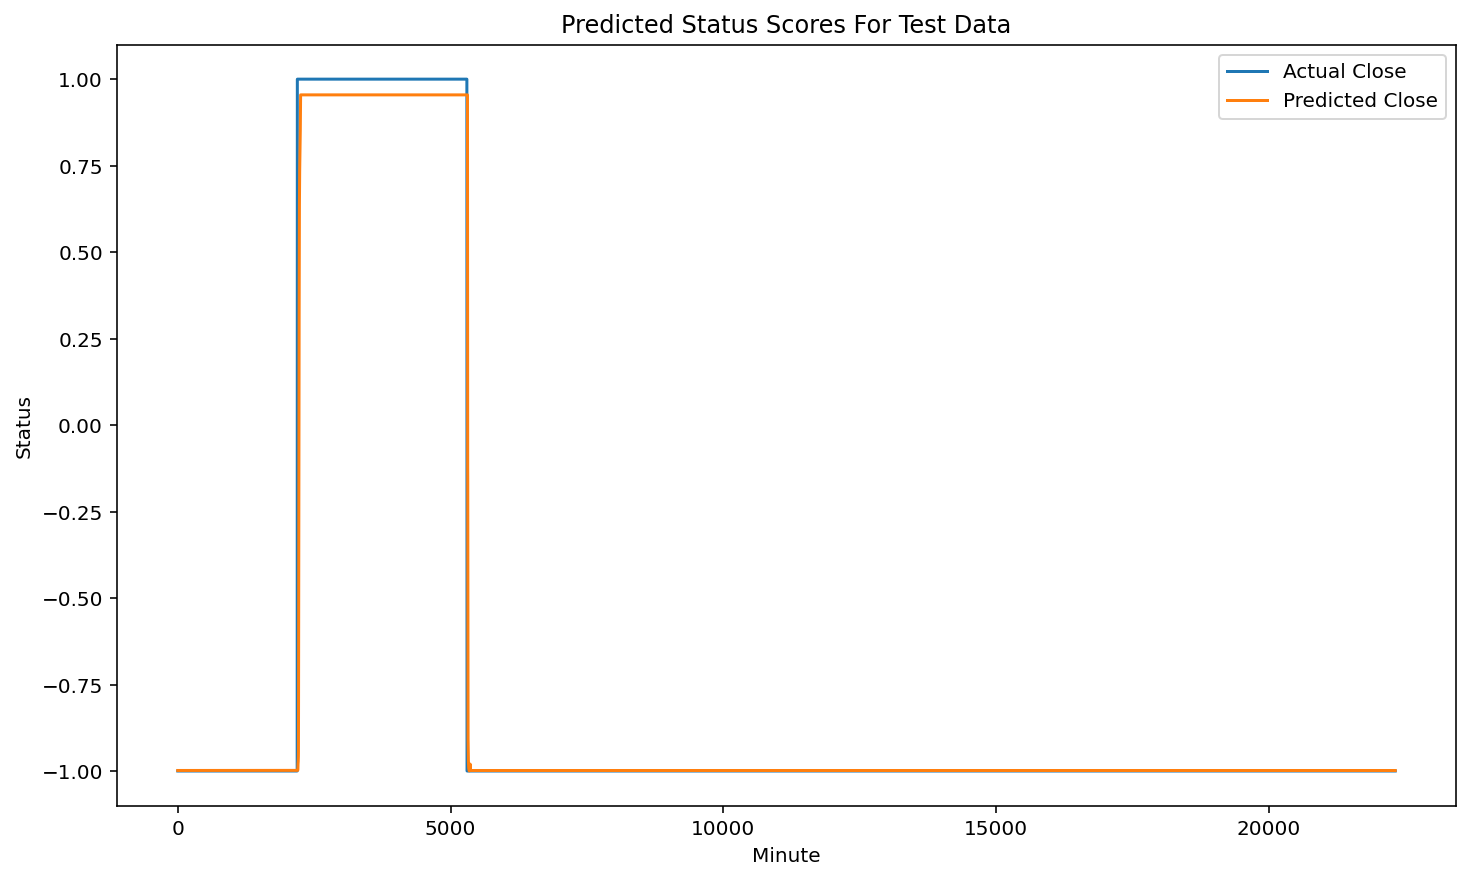

In [73]:
import matplotlib.pyplot as plt  

plt.plot(y_test, label='Actual Close')
plt.plot(predictions, label='Predicted Close')
plt.xlabel('Minute')
plt.ylabel('Status')
plt.legend()
plt.title("Predicted Status Scores For Test Data")
plt.show()

(22320, 1)
(22320,)
(22320,)


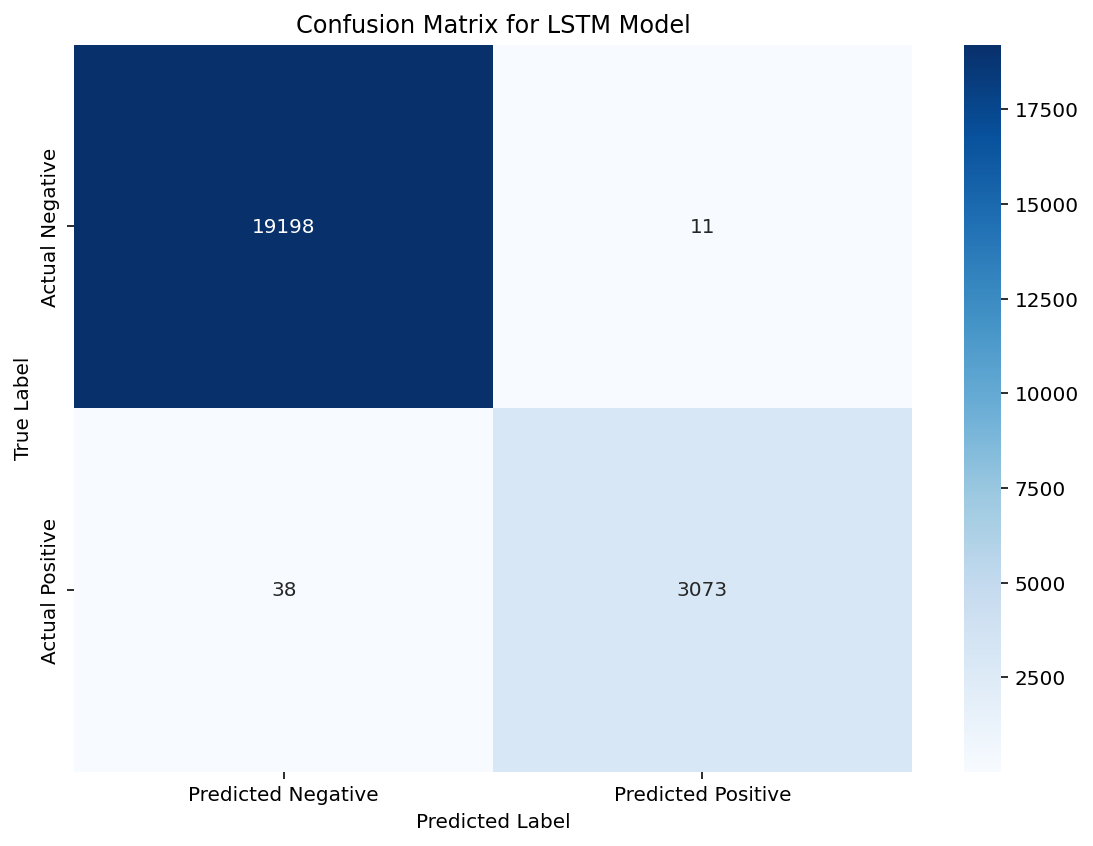


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19209
           1       1.00      0.99      0.99      3111

    accuracy                           1.00     22320
   macro avg       1.00      0.99      1.00     22320
weighted avg       1.00      1.00      1.00     22320


Confusion Matrix:
[[19198    11]
 [   38  3073]]


In [43]:
##Confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def create_confusion_matrix(y_true, y_pred, threshold=0.5):
    """
    Create a confusion matrix for regression predictions using a threshold.
    
    Parameters:
    - y_true: True labels/values
    - y_pred: Predicted values
    - threshold: Threshold for binary classification conversion
    
    Returns:
    - Confusion matrix and classification report
    """
    # Flatten the arrays if they are multi-dimensional
    y_true = y_true.flatten()
    print(y_pred.shape)
    y_pred = y_pred.flatten()
    
    # Convert to binary classification using threshold
    #y_true_binary = (y_true > np.median(y_true)).astype(int)
    #y_pred_binary = (y_pred > np.median(y_pred)).astype(int)
    y_true_binary = np.where(y_true > threshold, 1, 0)
    y_pred_binary = np.where(y_pred > threshold, 1, 0)
    print(y_true_binary.shape)
    print(y_pred_binary.shape)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix for LSTM Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_binary, y_pred_binary))
    
    return cm

# Assuming you have already trained the model and made predictions
# y_test and predictions should be numpy arrays
confusion_matrix_result = create_confusion_matrix(y_test, predictions)
print("\nConfusion Matrix:")
print(confusion_matrix_result)

In [74]:

# yeah this shit aint working
from explainerdashboard import ClassifierExplainer, RegressionExplainer


explainer = RegressionExplainer(model, X_test, y_test)

AttributeError: 'Tensor' object has no attribute 'copy'

In [18]:
#pearsons correlation
from scipy.stats import pearsonr

ynum = y_test.numpy()
y_reshape = ynum[:, 0]  # Shape: (22320,)
pred_reshape = predictions[:, 0]  # Shape: (22320,)


# Calculate Pearson's correlation
# r, p_value = pearsonr(pred_reshape, y_reshape)
r, p_value = pearsonr(initial_data['Temperature'],initial_data['Humidity'])
# r, p_value = pearsonr(initial_data['RPM'],initial_data['Vibrations'])
# r, p_value = pearsonr(initial_data['Vibrations'],initial_data['Pressure'])
print("Pearson's correlation coefficient:", r)
print("P-value:", p_value)

Pearson's correlation coefficient: 0.09614726793256023
P-value: 3.725887580570296e-92


In [22]:
#spearman correlation
from scipy.stats import spearmanr

# Calculate Spearman's correlation
rho, p_value = spearmanr(initial_data['Temperature'],initial_data['Humidity'])
print("Spearman's correlation coefficient:", rho)
print("P-value:", p_value)

Spearman's correlation coefficient: 0.26357977425542306
P-value: 0.0


In [24]:
#cross-correlation
cross_corr = np.correlate(predictions - np.mean(predictions), y_reshape - np.mean(y_reshape), mode='full')
lags = np.arange(-len(x) + 1, len(x))

print("Cross-correlation:", cross_corr)
print("Lags:", lags)

NameError: name 'predictions' is not defined